In [19]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [20]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [21]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [22]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [23]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [24]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
#     eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
#     aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [25]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [26]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [27]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [28]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [29]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [30]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [31]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [32]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 R:10.0000 rate:0.0200 aloss:0.7046 eloss:2.5153 aloss2:1.6932 exploreP:0.9990
Episode:1 meanR:10.5000 R:11.0000 rate:0.0220 aloss:0.7110 eloss:2.4267 aloss2:1.7376 exploreP:0.9979
Episode:2 meanR:18.0000 R:33.0000 rate:0.0660 aloss:0.7283 eloss:2.3506 aloss2:1.7375 exploreP:0.9947
Episode:3 meanR:20.7500 R:29.0000 rate:0.0580 aloss:0.7190 eloss:2.3632 aloss2:1.7660 exploreP:0.9918
Episode:4 meanR:22.4000 R:29.0000 rate:0.0580 aloss:0.7136 eloss:2.3702 aloss2:1.7361 exploreP:0.9890
Episode:5 meanR:25.5000 R:41.0000 rate:0.0820 aloss:0.7135 eloss:2.3288 aloss2:1.7796 exploreP:0.9850
Episode:6 meanR:24.5714 R:19.0000 rate:0.0380 aloss:0.7042 eloss:2.2700 aloss2:1.8644 exploreP:0.9831
Episode:7 meanR:24.6250 R:25.0000 rate:0.0500 aloss:0.7093 eloss:2.2465 aloss2:1.8484 exploreP:0.9807
Episode:8 meanR:24.2222 R:21.0000 rate:0.0420 aloss:0.7083 eloss:2.2442 aloss2:1.8640 exploreP:0.9787
Episode:9 meanR:23.3000 R:15.0000 rate:0.0300 aloss:0.7063 eloss:2.1272 aloss2:1.9

Episode:80 meanR:21.9012 R:40.0000 rate:0.0800 aloss:0.6953 eloss:0.9354 aloss2:3.3712 exploreP:0.8391
Episode:81 meanR:22.1829 R:45.0000 rate:0.0900 aloss:0.6935 eloss:0.8389 aloss2:3.5132 exploreP:0.8353
Episode:82 meanR:22.4217 R:42.0000 rate:0.0840 aloss:0.6875 eloss:0.8905 aloss2:3.3612 exploreP:0.8319
Episode:83 meanR:22.3452 R:16.0000 rate:0.0320 aloss:0.6888 eloss:0.7527 aloss2:3.5554 exploreP:0.8306
Episode:84 meanR:22.3176 R:20.0000 rate:0.0400 aloss:0.6829 eloss:0.8212 aloss2:3.4400 exploreP:0.8289
Episode:85 meanR:22.3837 R:28.0000 rate:0.0560 aloss:0.6847 eloss:0.8801 aloss2:3.4162 exploreP:0.8266
Episode:86 meanR:22.2874 R:14.0000 rate:0.0280 aloss:0.6903 eloss:0.9194 aloss2:3.3892 exploreP:0.8255
Episode:87 meanR:22.1932 R:14.0000 rate:0.0280 aloss:0.6864 eloss:0.6815 aloss2:3.6738 exploreP:0.8244
Episode:88 meanR:22.2247 R:25.0000 rate:0.0500 aloss:0.6823 eloss:0.8001 aloss2:3.5788 exploreP:0.8223
Episode:89 meanR:22.1667 R:17.0000 rate:0.0340 aloss:0.6805 eloss:0.8006 

Episode:159 meanR:34.7900 R:41.0000 rate:0.0820 aloss:0.6786 eloss:-2.0434 aloss2:9.9816 exploreP:0.6260
Episode:160 meanR:34.7900 R:24.0000 rate:0.0480 aloss:0.6821 eloss:-2.0700 aloss2:9.8785 exploreP:0.6246
Episode:161 meanR:34.9300 R:27.0000 rate:0.0540 aloss:0.7070 eloss:-1.7997 aloss2:10.3419 exploreP:0.6229
Episode:162 meanR:35.6700 R:91.0000 rate:0.1820 aloss:0.7036 eloss:-2.0836 aloss2:10.5480 exploreP:0.6173
Episode:163 meanR:35.7600 R:46.0000 rate:0.0920 aloss:0.6846 eloss:-2.2533 aloss2:10.5864 exploreP:0.6146
Episode:164 meanR:36.2300 R:64.0000 rate:0.1280 aloss:0.6878 eloss:-2.1025 aloss2:10.8072 exploreP:0.6107
Episode:165 meanR:37.7100 R:166.0000 rate:0.3320 aloss:0.7016 eloss:-2.3867 aloss2:11.4902 exploreP:0.6008
Episode:166 meanR:38.8400 R:122.0000 rate:0.2440 aloss:0.7189 eloss:-2.4408 aloss2:12.0949 exploreP:0.5937
Episode:167 meanR:39.6900 R:108.0000 rate:0.2160 aloss:0.7171 eloss:-2.4920 aloss2:12.4930 exploreP:0.5874
Episode:168 meanR:39.6000 R:52.0000 rate:0.10

Episode:236 meanR:133.5200 R:402.0000 rate:0.8040 aloss:0.7261 eloss:-6.8572 aloss2:44.8079 exploreP:0.1894
Episode:237 meanR:133.3200 R:10.0000 rate:0.0200 aloss:0.7410 eloss:-8.0544 aloss2:45.3713 exploreP:0.1892
Episode:238 meanR:133.0400 R:10.0000 rate:0.0200 aloss:0.7790 eloss:-7.5756 aloss2:45.5697 exploreP:0.1890
Episode:239 meanR:132.6900 R:11.0000 rate:0.0220 aloss:0.7134 eloss:-8.5803 aloss2:45.2486 exploreP:0.1888
Episode:240 meanR:132.4800 R:9.0000 rate:0.0180 aloss:0.7470 eloss:-7.8526 aloss2:45.3542 exploreP:0.1887
Episode:241 meanR:131.5800 R:8.0000 rate:0.0160 aloss:0.7017 eloss:-5.5757 aloss2:45.0384 exploreP:0.1885
Episode:242 meanR:136.1800 R:500.0000 rate:1.0000 aloss:0.7233 eloss:-6.7309 aloss2:45.1210 exploreP:0.1798
Episode:243 meanR:140.8500 R:500.0000 rate:1.0000 aloss:0.7075 eloss:-6.9497 aloss2:45.6744 exploreP:0.1715
Episode:244 meanR:143.9800 R:366.0000 rate:0.7320 aloss:0.7137 eloss:-5.7661 aloss2:46.3341 exploreP:0.1657
Episode:245 meanR:146.5900 R:332.00

Episode:312 meanR:301.1700 R:466.0000 rate:0.9320 aloss:0.6982 eloss:-4.2600 aloss2:46.7491 exploreP:0.0278
Episode:313 meanR:301.1700 R:500.0000 rate:1.0000 aloss:0.7013 eloss:-5.1483 aloss2:46.7462 exploreP:0.0269
Episode:314 meanR:300.4300 R:426.0000 rate:0.8520 aloss:0.7030 eloss:-4.1948 aloss2:46.5544 exploreP:0.0262
Episode:315 meanR:302.2700 R:384.0000 rate:0.7680 aloss:0.7176 eloss:-4.2821 aloss2:46.3860 exploreP:0.0256
Episode:316 meanR:302.7400 R:357.0000 rate:0.7140 aloss:0.7036 eloss:-5.0993 aloss2:46.2628 exploreP:0.0251
Episode:317 meanR:303.8100 R:500.0000 rate:1.0000 aloss:0.7254 eloss:-5.2121 aloss2:46.2695 exploreP:0.0243
Episode:318 meanR:305.3100 R:316.0000 rate:0.6320 aloss:0.7163 eloss:-4.4889 aloss2:46.3016 exploreP:0.0239
Episode:319 meanR:303.9300 R:362.0000 rate:0.7240 aloss:0.6915 eloss:-4.3042 aloss2:46.2544 exploreP:0.0234
Episode:320 meanR:303.9500 R:370.0000 rate:0.7400 aloss:0.7147 eloss:-4.2684 aloss2:46.3690 exploreP:0.0229
Episode:321 meanR:303.9800 R

Episode:388 meanR:256.8500 R:257.0000 rate:0.5140 aloss:0.6082 eloss:-4.1099 aloss2:46.3171 exploreP:0.0125
Episode:389 meanR:257.6300 R:305.0000 rate:0.6100 aloss:0.6233 eloss:-3.5420 aloss2:46.4213 exploreP:0.0124
Episode:390 meanR:258.2800 R:248.0000 rate:0.4960 aloss:0.6134 eloss:-4.4731 aloss2:46.5152 exploreP:0.0124
Episode:391 meanR:257.9900 R:188.0000 rate:0.3760 aloss:0.6190 eloss:-1.5775 aloss2:46.2159 exploreP:0.0123
Episode:392 meanR:257.8800 R:140.0000 rate:0.2800 aloss:0.6263 eloss:-3.1653 aloss2:45.8600 exploreP:0.0123
Episode:393 meanR:258.9700 R:175.0000 rate:0.3500 aloss:0.5964 eloss:-3.6977 aloss2:46.2632 exploreP:0.0122
Episode:394 meanR:258.5300 R:154.0000 rate:0.3080 aloss:0.5974 eloss:-3.9307 aloss2:45.8835 exploreP:0.0122
Episode:395 meanR:259.8800 R:261.0000 rate:0.5220 aloss:0.6073 eloss:-4.0101 aloss2:46.2444 exploreP:0.0122
Episode:396 meanR:260.4300 R:225.0000 rate:0.4500 aloss:0.6040 eloss:-3.7985 aloss2:46.2714 exploreP:0.0121
Episode:397 meanR:260.5700 R

Episode:464 meanR:191.2200 R:240.0000 rate:0.4800 aloss:0.5533 eloss:-3.2495 aloss2:47.2389 exploreP:0.0106
Episode:465 meanR:191.2600 R:208.0000 rate:0.4160 aloss:0.5529 eloss:-3.9718 aloss2:47.3530 exploreP:0.0106
Episode:466 meanR:190.3000 R:171.0000 rate:0.3420 aloss:0.5557 eloss:-2.9412 aloss2:47.8250 exploreP:0.0106
Episode:467 meanR:191.0900 R:211.0000 rate:0.4220 aloss:0.5621 eloss:-4.0395 aloss2:47.6931 exploreP:0.0106
Episode:468 meanR:190.9300 R:192.0000 rate:0.3840 aloss:0.5451 eloss:-3.0003 aloss2:47.5311 exploreP:0.0106
Episode:469 meanR:190.8700 R:172.0000 rate:0.3440 aloss:0.5627 eloss:-3.9124 aloss2:47.8311 exploreP:0.0106
Episode:470 meanR:191.0100 R:196.0000 rate:0.3920 aloss:0.5513 eloss:-2.6643 aloss2:47.4296 exploreP:0.0105
Episode:471 meanR:190.4200 R:157.0000 rate:0.3140 aloss:0.5583 eloss:-1.9666 aloss2:47.3655 exploreP:0.0105
Episode:472 meanR:189.3600 R:155.0000 rate:0.3100 aloss:0.5638 eloss:-3.3943 aloss2:47.6179 exploreP:0.0105
Episode:473 meanR:187.8600 R

Episode:540 meanR:175.6000 R:134.0000 rate:0.2680 aloss:0.5234 eloss:-2.9749 aloss2:47.8002 exploreP:0.0102
Episode:541 meanR:175.7900 R:259.0000 rate:0.5180 aloss:0.4738 eloss:-2.7993 aloss2:47.9443 exploreP:0.0102
Episode:542 meanR:176.1000 R:203.0000 rate:0.4060 aloss:0.5234 eloss:-3.3873 aloss2:47.7348 exploreP:0.0102
Episode:543 meanR:175.9700 R:189.0000 rate:0.3780 aloss:0.4834 eloss:-2.5904 aloss2:47.6570 exploreP:0.0102
Episode:544 meanR:176.6100 R:214.0000 rate:0.4280 aloss:0.4895 eloss:-3.5801 aloss2:47.7251 exploreP:0.0101
Episode:545 meanR:176.4100 R:169.0000 rate:0.3380 aloss:0.4917 eloss:-2.2668 aloss2:47.6720 exploreP:0.0101
Episode:546 meanR:175.6500 R:137.0000 rate:0.2740 aloss:0.4896 eloss:-3.7876 aloss2:47.6136 exploreP:0.0101
Episode:547 meanR:175.7000 R:144.0000 rate:0.2880 aloss:0.4907 eloss:-3.5050 aloss2:48.0309 exploreP:0.0101
Episode:548 meanR:175.6100 R:162.0000 rate:0.3240 aloss:0.4795 eloss:-3.5090 aloss2:48.2061 exploreP:0.0101
Episode:549 meanR:175.3600 R

Episode:616 meanR:167.2400 R:165.0000 rate:0.3300 aloss:0.4412 eloss:-0.3708 aloss2:52.6692 exploreP:0.0100
Episode:617 meanR:167.8000 R:133.0000 rate:0.2660 aloss:0.4291 eloss:-3.1771 aloss2:52.5878 exploreP:0.0100
Episode:618 meanR:167.7900 R:124.0000 rate:0.2480 aloss:0.4143 eloss:-2.4016 aloss2:53.0017 exploreP:0.0100
Episode:619 meanR:167.2400 R:158.0000 rate:0.3160 aloss:0.4516 eloss:-0.4976 aloss2:52.3547 exploreP:0.0100
Episode:620 meanR:166.9900 R:174.0000 rate:0.3480 aloss:0.4170 eloss:-2.1766 aloss2:52.4657 exploreP:0.0100
Episode:621 meanR:167.1400 R:155.0000 rate:0.3100 aloss:0.4323 eloss:-2.9262 aloss2:52.4064 exploreP:0.0100
Episode:622 meanR:166.6600 R:137.0000 rate:0.2740 aloss:0.4210 eloss:-3.1417 aloss2:52.2972 exploreP:0.0100
Episode:623 meanR:167.5800 R:208.0000 rate:0.4160 aloss:0.4243 eloss:-1.7979 aloss2:52.7009 exploreP:0.0100
Episode:624 meanR:168.3400 R:192.0000 rate:0.3840 aloss:0.4291 eloss:-1.5404 aloss2:52.3997 exploreP:0.0100
Episode:625 meanR:168.6000 R

Episode:692 meanR:156.1800 R:184.0000 rate:0.3680 aloss:0.3759 eloss:-2.9180 aloss2:54.2468 exploreP:0.0100
Episode:693 meanR:155.4700 R:126.0000 rate:0.2520 aloss:0.3665 eloss:-4.0033 aloss2:54.1994 exploreP:0.0100
Episode:694 meanR:154.7700 R:135.0000 rate:0.2700 aloss:0.3982 eloss:-2.5109 aloss2:53.5384 exploreP:0.0100
Episode:695 meanR:154.2800 R:154.0000 rate:0.3080 aloss:0.4103 eloss:0.4869 aloss2:53.2793 exploreP:0.0100
Episode:696 meanR:154.8300 R:202.0000 rate:0.4040 aloss:0.3839 eloss:-3.6539 aloss2:53.3332 exploreP:0.0100
Episode:697 meanR:154.5600 R:137.0000 rate:0.2740 aloss:0.3696 eloss:-4.1352 aloss2:53.8053 exploreP:0.0100
Episode:698 meanR:153.9900 R:84.0000 rate:0.1680 aloss:0.3275 eloss:-4.1440 aloss2:53.9429 exploreP:0.0100
Episode:699 meanR:153.3800 R:127.0000 rate:0.2540 aloss:0.3691 eloss:-4.6132 aloss2:53.9730 exploreP:0.0100
Episode:700 meanR:153.4300 R:182.0000 rate:0.3640 aloss:0.4017 eloss:-3.1421 aloss2:54.3323 exploreP:0.0100
Episode:701 meanR:153.5300 R:1

Episode:768 meanR:141.6300 R:136.0000 rate:0.2720 aloss:0.3253 eloss:-5.2233 aloss2:60.3534 exploreP:0.0100
Episode:769 meanR:141.2800 R:91.0000 rate:0.1820 aloss:0.3063 eloss:-5.0217 aloss2:59.0186 exploreP:0.0100
Episode:770 meanR:141.1400 R:183.0000 rate:0.3660 aloss:0.3040 eloss:-5.3839 aloss2:59.6408 exploreP:0.0100
Episode:771 meanR:141.3500 R:192.0000 rate:0.3840 aloss:0.3156 eloss:-6.3876 aloss2:60.2222 exploreP:0.0100
Episode:772 meanR:141.7000 R:169.0000 rate:0.3380 aloss:0.3251 eloss:-4.4609 aloss2:60.5287 exploreP:0.0100
Episode:773 meanR:141.5500 R:88.0000 rate:0.1760 aloss:0.2943 eloss:-7.7523 aloss2:60.4985 exploreP:0.0100
Episode:774 meanR:141.4200 R:103.0000 rate:0.2060 aloss:0.2999 eloss:-6.6065 aloss2:60.9320 exploreP:0.0100
Episode:775 meanR:140.8800 R:91.0000 rate:0.1820 aloss:0.3391 eloss:-1.1124 aloss2:60.3274 exploreP:0.0100
Episode:776 meanR:141.8500 R:183.0000 rate:0.3660 aloss:0.3175 eloss:-1.3796 aloss2:60.3953 exploreP:0.0100
Episode:777 meanR:141.1400 R:10

Episode:844 meanR:139.6700 R:146.0000 rate:0.2920 aloss:0.3067 eloss:-6.9018 aloss2:64.0247 exploreP:0.0100
Episode:845 meanR:139.9500 R:132.0000 rate:0.2640 aloss:0.2887 eloss:-5.7331 aloss2:64.3951 exploreP:0.0100
Episode:846 meanR:139.5200 R:103.0000 rate:0.2060 aloss:0.3002 eloss:-7.8479 aloss2:64.9030 exploreP:0.0100
Episode:847 meanR:139.3500 R:152.0000 rate:0.3040 aloss:0.2874 eloss:-6.8628 aloss2:65.0739 exploreP:0.0100
Episode:848 meanR:139.2500 R:87.0000 rate:0.1740 aloss:0.2839 eloss:-8.3468 aloss2:64.7016 exploreP:0.0100
Episode:849 meanR:139.1800 R:133.0000 rate:0.2660 aloss:0.2892 eloss:-6.6988 aloss2:64.8768 exploreP:0.0100
Episode:850 meanR:138.7700 R:92.0000 rate:0.1840 aloss:0.3366 eloss:-4.9827 aloss2:64.5240 exploreP:0.0100
Episode:851 meanR:138.9400 R:165.0000 rate:0.3300 aloss:0.2863 eloss:-6.1686 aloss2:64.7029 exploreP:0.0100
Episode:852 meanR:138.6900 R:148.0000 rate:0.2960 aloss:0.2832 eloss:-8.2801 aloss2:65.3871 exploreP:0.0100
Episode:853 meanR:139.2400 R:1

Episode:920 meanR:128.6900 R:110.0000 rate:0.2200 aloss:0.2989 eloss:-6.3623 aloss2:68.8763 exploreP:0.0100
Episode:921 meanR:129.0700 R:185.0000 rate:0.3700 aloss:0.2851 eloss:-8.9260 aloss2:69.3022 exploreP:0.0100
Episode:922 meanR:129.2800 R:118.0000 rate:0.2360 aloss:0.2964 eloss:-8.6129 aloss2:69.8542 exploreP:0.0100
Episode:923 meanR:129.4900 R:117.0000 rate:0.2340 aloss:0.2698 eloss:-6.5756 aloss2:68.5617 exploreP:0.0100
Episode:924 meanR:128.8400 R:91.0000 rate:0.1820 aloss:0.2659 eloss:-10.1183 aloss2:70.2730 exploreP:0.0100
Episode:925 meanR:129.3500 R:156.0000 rate:0.3120 aloss:0.2711 eloss:-6.2468 aloss2:70.3203 exploreP:0.0100
Episode:926 meanR:129.6200 R:155.0000 rate:0.3100 aloss:0.2287 eloss:-3.9218 aloss2:69.1669 exploreP:0.0100
Episode:927 meanR:130.2200 R:213.0000 rate:0.4260 aloss:0.2651 eloss:-8.7208 aloss2:69.3858 exploreP:0.0100
Episode:928 meanR:130.0000 R:145.0000 rate:0.2900 aloss:0.2515 eloss:-10.0077 aloss2:70.0310 exploreP:0.0100
Episode:929 meanR:129.5000 

Episode:996 meanR:126.7700 R:94.0000 rate:0.1880 aloss:0.2805 eloss:-8.0058 aloss2:73.1464 exploreP:0.0100
Episode:997 meanR:126.8100 R:115.0000 rate:0.2300 aloss:0.2700 eloss:-10.1034 aloss2:75.1515 exploreP:0.0100
Episode:998 meanR:126.8300 R:117.0000 rate:0.2340 aloss:0.2934 eloss:-8.1609 aloss2:74.4583 exploreP:0.0100
Episode:999 meanR:126.5000 R:121.0000 rate:0.2420 aloss:0.2645 eloss:-9.0690 aloss2:74.6560 exploreP:0.0100
Episode:1000 meanR:127.1700 R:191.0000 rate:0.3820 aloss:0.2471 eloss:-7.5014 aloss2:74.6612 exploreP:0.0100
Episode:1001 meanR:126.9200 R:135.0000 rate:0.2700 aloss:0.2568 eloss:-8.0332 aloss2:75.1097 exploreP:0.0100
Episode:1002 meanR:126.5000 R:88.0000 rate:0.1760 aloss:0.2467 eloss:-7.7949 aloss2:75.1978 exploreP:0.0100
Episode:1003 meanR:126.6600 R:131.0000 rate:0.2620 aloss:0.2508 eloss:-7.1011 aloss2:74.6445 exploreP:0.0100
Episode:1004 meanR:126.9400 R:196.0000 rate:0.3920 aloss:0.2401 eloss:-7.5372 aloss2:74.8233 exploreP:0.0100
Episode:1005 meanR:127.1

Episode:1072 meanR:122.3400 R:130.0000 rate:0.2600 aloss:0.2785 eloss:-9.4583 aloss2:74.9392 exploreP:0.0100
Episode:1073 meanR:121.5900 R:108.0000 rate:0.2160 aloss:0.2922 eloss:-10.7638 aloss2:75.8123 exploreP:0.0100
Episode:1074 meanR:121.1700 R:96.0000 rate:0.1920 aloss:0.2725 eloss:-0.1566 aloss2:74.2862 exploreP:0.0100
Episode:1075 meanR:121.4100 R:113.0000 rate:0.2260 aloss:0.2890 eloss:-2.2013 aloss2:74.3632 exploreP:0.0100
Episode:1076 meanR:120.6900 R:87.0000 rate:0.1740 aloss:0.2938 eloss:-1.6235 aloss2:73.5340 exploreP:0.0100
Episode:1077 meanR:120.2300 R:96.0000 rate:0.1920 aloss:0.2719 eloss:-12.2534 aloss2:74.2985 exploreP:0.0100
Episode:1078 meanR:119.8900 R:85.0000 rate:0.1700 aloss:0.2938 eloss:-8.6855 aloss2:73.7940 exploreP:0.0100
Episode:1079 meanR:119.6300 R:110.0000 rate:0.2200 aloss:0.3297 eloss:-7.7083 aloss2:75.0986 exploreP:0.0100
Episode:1080 meanR:119.2400 R:83.0000 rate:0.1660 aloss:0.3064 eloss:-7.8866 aloss2:73.4612 exploreP:0.0100
Episode:1081 meanR:119

Episode:1148 meanR:109.2700 R:126.0000 rate:0.2520 aloss:0.2536 eloss:-11.0873 aloss2:72.9266 exploreP:0.0100
Episode:1149 meanR:109.0700 R:109.0000 rate:0.2180 aloss:0.3302 eloss:-6.2835 aloss2:73.2127 exploreP:0.0100
Episode:1150 meanR:109.0700 R:85.0000 rate:0.1700 aloss:0.3049 eloss:-5.9054 aloss2:73.0135 exploreP:0.0100
Episode:1151 meanR:108.8300 R:99.0000 rate:0.1980 aloss:0.2725 eloss:-10.4001 aloss2:73.2319 exploreP:0.0100
Episode:1152 meanR:108.5700 R:83.0000 rate:0.1660 aloss:0.2803 eloss:-9.4539 aloss2:73.0576 exploreP:0.0100
Episode:1153 meanR:108.5800 R:107.0000 rate:0.2140 aloss:0.3087 eloss:-11.5544 aloss2:74.3578 exploreP:0.0100
Episode:1154 meanR:108.7600 R:99.0000 rate:0.1980 aloss:0.2686 eloss:-8.9824 aloss2:73.7190 exploreP:0.0100
Episode:1155 meanR:109.1600 R:153.0000 rate:0.3060 aloss:0.3191 eloss:-7.3294 aloss2:73.5267 exploreP:0.0100
Episode:1156 meanR:109.0900 R:92.0000 rate:0.1840 aloss:0.2739 eloss:-4.1108 aloss2:73.6842 exploreP:0.0100
Episode:1157 meanR:10

Episode:1224 meanR:111.2200 R:92.0000 rate:0.1840 aloss:0.2671 eloss:-10.9551 aloss2:73.4192 exploreP:0.0100
Episode:1225 meanR:111.1600 R:94.0000 rate:0.1880 aloss:0.3143 eloss:-10.1029 aloss2:73.6207 exploreP:0.0100
Episode:1226 meanR:111.0800 R:100.0000 rate:0.2000 aloss:0.2995 eloss:2.4189 aloss2:72.3413 exploreP:0.0100
Episode:1227 meanR:111.0600 R:94.0000 rate:0.1880 aloss:0.3340 eloss:-6.3199 aloss2:72.2606 exploreP:0.0100
Episode:1228 meanR:110.4100 R:81.0000 rate:0.1620 aloss:0.2846 eloss:-9.7914 aloss2:72.2465 exploreP:0.0100
Episode:1229 meanR:110.2200 R:80.0000 rate:0.1600 aloss:0.2912 eloss:-8.0527 aloss2:73.1824 exploreP:0.0100
Episode:1230 meanR:109.7300 R:90.0000 rate:0.1800 aloss:0.3072 eloss:-6.0298 aloss2:72.5558 exploreP:0.0100
Episode:1231 meanR:110.3000 R:155.0000 rate:0.3100 aloss:0.2833 eloss:-2.3527 aloss2:70.9076 exploreP:0.0100
Episode:1232 meanR:110.1500 R:79.0000 rate:0.1580 aloss:0.2792 eloss:-7.7527 aloss2:71.8649 exploreP:0.0100
Episode:1233 meanR:110.57

Episode:1300 meanR:109.8500 R:100.0000 rate:0.2000 aloss:0.2608 eloss:-9.7685 aloss2:71.5132 exploreP:0.0100
Episode:1301 meanR:109.3500 R:112.0000 rate:0.2240 aloss:0.3674 eloss:-6.9979 aloss2:71.3969 exploreP:0.0100
Episode:1302 meanR:109.6700 R:108.0000 rate:0.2160 aloss:0.2718 eloss:-10.1315 aloss2:70.9590 exploreP:0.0100
Episode:1303 meanR:109.5000 R:80.0000 rate:0.1600 aloss:0.2666 eloss:-9.3933 aloss2:71.5045 exploreP:0.0100
Episode:1304 meanR:109.3900 R:116.0000 rate:0.2320 aloss:0.2987 eloss:-9.8758 aloss2:72.1376 exploreP:0.0100
Episode:1305 meanR:109.5800 R:102.0000 rate:0.2040 aloss:0.2696 eloss:-8.9419 aloss2:71.1649 exploreP:0.0100
Episode:1306 meanR:109.6800 R:150.0000 rate:0.3000 aloss:0.2591 eloss:-11.0597 aloss2:71.1028 exploreP:0.0100
Episode:1307 meanR:109.5700 R:86.0000 rate:0.1720 aloss:0.2577 eloss:-11.0998 aloss2:71.3604 exploreP:0.0100
Episode:1308 meanR:109.3100 R:105.0000 rate:0.2100 aloss:0.2548 eloss:-9.6406 aloss2:71.4187 exploreP:0.0100
Episode:1309 meanR

Episode:1376 meanR:106.0700 R:99.0000 rate:0.1980 aloss:0.2994 eloss:-10.2592 aloss2:73.0146 exploreP:0.0100
Episode:1377 meanR:105.1600 R:123.0000 rate:0.2460 aloss:0.4060 eloss:-4.2566 aloss2:73.5414 exploreP:0.0100
Episode:1378 meanR:104.8600 R:82.0000 rate:0.1640 aloss:0.3439 eloss:-12.0058 aloss2:73.9933 exploreP:0.0100
Episode:1379 meanR:105.0600 R:103.0000 rate:0.2060 aloss:0.3619 eloss:-11.8607 aloss2:73.0978 exploreP:0.0100
Episode:1380 meanR:105.0000 R:85.0000 rate:0.1700 aloss:0.3315 eloss:-2.5738 aloss2:73.4002 exploreP:0.0100
Episode:1381 meanR:104.8300 R:93.0000 rate:0.1860 aloss:0.2831 eloss:-11.6378 aloss2:73.6979 exploreP:0.0100
Episode:1382 meanR:105.1400 R:111.0000 rate:0.2220 aloss:0.2757 eloss:-10.6542 aloss2:72.5100 exploreP:0.0100
Episode:1383 meanR:104.6000 R:91.0000 rate:0.1820 aloss:0.3167 eloss:-7.9595 aloss2:72.9161 exploreP:0.0100
Episode:1384 meanR:104.3100 R:100.0000 rate:0.2000 aloss:0.3414 eloss:-10.8539 aloss2:74.1749 exploreP:0.0100
Episode:1385 meanR

Episode:1452 meanR:92.6400 R:107.0000 rate:0.2140 aloss:0.3463 eloss:-12.3605 aloss2:75.1141 exploreP:0.0100
Episode:1453 meanR:92.6800 R:81.0000 rate:0.1620 aloss:0.3183 eloss:-6.5856 aloss2:74.1573 exploreP:0.0100
Episode:1454 meanR:92.9000 R:110.0000 rate:0.2200 aloss:0.3049 eloss:-4.8511 aloss2:73.0995 exploreP:0.0100
Episode:1455 meanR:92.9800 R:116.0000 rate:0.2320 aloss:0.3289 eloss:-11.7837 aloss2:74.7865 exploreP:0.0100
Episode:1456 meanR:91.9500 R:37.0000 rate:0.0740 aloss:0.3659 eloss:-10.6005 aloss2:74.5272 exploreP:0.0100
Episode:1457 meanR:92.1800 R:105.0000 rate:0.2100 aloss:0.3152 eloss:-12.2908 aloss2:74.5577 exploreP:0.0100
Episode:1458 meanR:91.4600 R:45.0000 rate:0.0900 aloss:0.2900 eloss:-10.5618 aloss2:74.1656 exploreP:0.0100
Episode:1459 meanR:91.0900 R:79.0000 rate:0.1580 aloss:0.3190 eloss:-4.8090 aloss2:74.9765 exploreP:0.0100
Episode:1460 meanR:90.8100 R:72.0000 rate:0.1440 aloss:0.3518 eloss:-12.5842 aloss2:75.1970 exploreP:0.0100
Episode:1461 meanR:90.7500 

Episode:1528 meanR:81.4900 R:109.0000 rate:0.2180 aloss:0.3238 eloss:-12.1456 aloss2:78.1239 exploreP:0.0100
Episode:1529 meanR:81.6000 R:77.0000 rate:0.1540 aloss:0.3580 eloss:-9.6425 aloss2:77.4953 exploreP:0.0100
Episode:1530 meanR:81.8100 R:97.0000 rate:0.1940 aloss:0.2834 eloss:-11.8949 aloss2:76.5716 exploreP:0.0100
Episode:1531 meanR:82.7100 R:148.0000 rate:0.2960 aloss:0.3396 eloss:-9.8791 aloss2:77.2821 exploreP:0.0100
Episode:1532 meanR:82.3400 R:75.0000 rate:0.1500 aloss:0.3038 eloss:-9.7755 aloss2:77.7745 exploreP:0.0100
Episode:1533 meanR:82.2600 R:89.0000 rate:0.1780 aloss:0.3075 eloss:-5.5903 aloss2:77.3029 exploreP:0.0100
Episode:1534 meanR:82.1500 R:103.0000 rate:0.2060 aloss:0.3444 eloss:-10.2286 aloss2:78.1495 exploreP:0.0100
Episode:1535 meanR:82.5900 R:99.0000 rate:0.1980 aloss:0.3483 eloss:-13.3497 aloss2:78.5370 exploreP:0.0100
Episode:1536 meanR:82.4100 R:59.0000 rate:0.1180 aloss:0.3170 eloss:-13.2213 aloss2:78.4044 exploreP:0.0100
Episode:1537 meanR:82.5400 R:

Episode:1604 meanR:74.7600 R:36.0000 rate:0.0720 aloss:0.3518 eloss:-1.5773 aloss2:83.1933 exploreP:0.0100
Episode:1605 meanR:74.5900 R:42.0000 rate:0.0840 aloss:0.3376 eloss:-9.0795 aloss2:81.3257 exploreP:0.0100
Episode:1606 meanR:74.2000 R:43.0000 rate:0.0860 aloss:0.4042 eloss:-12.6313 aloss2:81.5023 exploreP:0.0100
Episode:1607 meanR:74.1500 R:73.0000 rate:0.1460 aloss:0.2824 eloss:-11.0012 aloss2:82.0553 exploreP:0.0100
Episode:1608 meanR:73.8200 R:88.0000 rate:0.1760 aloss:0.3571 eloss:-12.2600 aloss2:82.9217 exploreP:0.0100
Episode:1609 meanR:74.6600 R:142.0000 rate:0.2840 aloss:0.4199 eloss:-11.1580 aloss2:82.6043 exploreP:0.0100
Episode:1610 meanR:74.5700 R:68.0000 rate:0.1360 aloss:0.2669 eloss:-12.8112 aloss2:82.4281 exploreP:0.0100
Episode:1611 meanR:73.9900 R:43.0000 rate:0.0860 aloss:0.4110 eloss:-14.0895 aloss2:84.1250 exploreP:0.0100
Episode:1612 meanR:73.3700 R:36.0000 rate:0.0720 aloss:0.3052 eloss:-11.2976 aloss2:81.1587 exploreP:0.0100
Episode:1613 meanR:73.3300 R:

Episode:1680 meanR:65.5100 R:30.0000 rate:0.0600 aloss:0.3664 eloss:-13.5887 aloss2:82.7084 exploreP:0.0100
Episode:1681 meanR:65.5400 R:77.0000 rate:0.1540 aloss:0.3861 eloss:-10.6426 aloss2:83.3552 exploreP:0.0100
Episode:1682 meanR:65.6800 R:88.0000 rate:0.1760 aloss:0.3512 eloss:-13.7111 aloss2:81.9557 exploreP:0.0100
Episode:1683 meanR:65.6600 R:49.0000 rate:0.0980 aloss:0.4090 eloss:-10.5219 aloss2:83.1279 exploreP:0.0100
Episode:1684 meanR:65.5600 R:83.0000 rate:0.1660 aloss:0.3630 eloss:-10.2253 aloss2:81.4298 exploreP:0.0100
Episode:1685 meanR:65.1100 R:35.0000 rate:0.0700 aloss:0.3924 eloss:-9.4759 aloss2:83.6742 exploreP:0.0100
Episode:1686 meanR:65.3100 R:71.0000 rate:0.1420 aloss:0.3127 eloss:-14.7728 aloss2:82.9124 exploreP:0.0100
Episode:1687 meanR:64.6600 R:27.0000 rate:0.0540 aloss:0.2278 eloss:-9.8614 aloss2:81.3867 exploreP:0.0100
Episode:1688 meanR:64.2400 R:38.0000 rate:0.0760 aloss:0.3567 eloss:-14.9447 aloss2:83.9424 exploreP:0.0100
Episode:1689 meanR:63.7800 R:3

Episode:1756 meanR:63.4600 R:32.0000 rate:0.0640 aloss:0.3999 eloss:-12.6773 aloss2:88.1014 exploreP:0.0100
Episode:1757 meanR:62.7700 R:40.0000 rate:0.0800 aloss:0.3326 eloss:-13.0588 aloss2:84.5761 exploreP:0.0100
Episode:1758 meanR:62.6100 R:77.0000 rate:0.1540 aloss:0.4448 eloss:-8.4086 aloss2:85.8807 exploreP:0.0100
Episode:1759 meanR:62.6400 R:34.0000 rate:0.0680 aloss:0.3653 eloss:-12.9464 aloss2:85.8116 exploreP:0.0100
Episode:1760 meanR:62.8400 R:117.0000 rate:0.2340 aloss:0.3170 eloss:-11.6609 aloss2:85.1776 exploreP:0.0100
Episode:1761 meanR:62.7600 R:88.0000 rate:0.1760 aloss:0.3446 eloss:-14.7274 aloss2:85.2497 exploreP:0.0100
Episode:1762 meanR:63.2600 R:84.0000 rate:0.1680 aloss:0.4374 eloss:-10.9737 aloss2:85.8205 exploreP:0.0100
Episode:1763 meanR:63.2900 R:77.0000 rate:0.1540 aloss:0.4459 eloss:-14.0628 aloss2:85.4778 exploreP:0.0100
Episode:1764 meanR:63.3100 R:105.0000 rate:0.2100 aloss:0.3399 eloss:-13.2014 aloss2:84.9117 exploreP:0.0100
Episode:1765 meanR:63.7400 

Episode:1832 meanR:62.9100 R:28.0000 rate:0.0560 aloss:0.3127 eloss:-14.3802 aloss2:85.7311 exploreP:0.0100
Episode:1833 meanR:62.8200 R:71.0000 rate:0.1420 aloss:0.3088 eloss:-14.4815 aloss2:87.3585 exploreP:0.0100
Episode:1834 meanR:62.3000 R:33.0000 rate:0.0660 aloss:0.3685 eloss:-15.2234 aloss2:86.3996 exploreP:0.0100
Episode:1835 meanR:62.2600 R:27.0000 rate:0.0540 aloss:0.3349 eloss:-15.2681 aloss2:86.9628 exploreP:0.0100
Episode:1836 meanR:62.5000 R:68.0000 rate:0.1360 aloss:0.4266 eloss:-9.1477 aloss2:87.0911 exploreP:0.0100
Episode:1837 meanR:62.4900 R:34.0000 rate:0.0680 aloss:0.3215 eloss:-15.9121 aloss2:87.1152 exploreP:0.0100
Episode:1838 meanR:61.9800 R:28.0000 rate:0.0560 aloss:0.2304 eloss:-14.4871 aloss2:85.4825 exploreP:0.0100
Episode:1839 meanR:62.1000 R:71.0000 rate:0.1420 aloss:0.3207 eloss:-15.4911 aloss2:86.2705 exploreP:0.0100
Episode:1840 meanR:62.0800 R:69.0000 rate:0.1380 aloss:0.3776 eloss:-8.6029 aloss2:88.0714 exploreP:0.0100
Episode:1841 meanR:62.8500 R:1

Episode:1908 meanR:61.7200 R:29.0000 rate:0.0580 aloss:0.2489 eloss:-15.4290 aloss2:88.5535 exploreP:0.0100
Episode:1909 meanR:62.1200 R:70.0000 rate:0.1400 aloss:0.2786 eloss:-14.4016 aloss2:86.1383 exploreP:0.0100
Episode:1910 meanR:62.5400 R:70.0000 rate:0.1400 aloss:0.3490 eloss:-14.0267 aloss2:88.6704 exploreP:0.0100
Episode:1911 meanR:62.4200 R:71.0000 rate:0.1420 aloss:0.2572 eloss:-16.6083 aloss2:88.0230 exploreP:0.0100
Episode:1912 meanR:62.3500 R:74.0000 rate:0.1480 aloss:0.3062 eloss:-13.2039 aloss2:87.4475 exploreP:0.0100
Episode:1913 meanR:62.4800 R:85.0000 rate:0.1700 aloss:0.3189 eloss:-13.4886 aloss2:88.6844 exploreP:0.0100
Episode:1914 meanR:62.4800 R:88.0000 rate:0.1760 aloss:0.3278 eloss:-12.7969 aloss2:87.3355 exploreP:0.0100
Episode:1915 meanR:62.9500 R:77.0000 rate:0.1540 aloss:0.2714 eloss:-14.3022 aloss2:88.9024 exploreP:0.0100
Episode:1916 meanR:63.8500 R:121.0000 rate:0.2420 aloss:0.2693 eloss:-10.2523 aloss2:86.1358 exploreP:0.0100
Episode:1917 meanR:63.8500 

Episode:1984 meanR:61.6100 R:71.0000 rate:0.1420 aloss:0.2748 eloss:-13.3442 aloss2:89.3653 exploreP:0.0100
Episode:1985 meanR:62.2200 R:97.0000 rate:0.1940 aloss:0.2970 eloss:-4.5946 aloss2:89.3960 exploreP:0.0100
Episode:1986 meanR:62.2300 R:74.0000 rate:0.1480 aloss:0.2864 eloss:-15.8829 aloss2:86.9512 exploreP:0.0100
Episode:1987 meanR:62.1800 R:24.0000 rate:0.0480 aloss:0.3272 eloss:-14.0728 aloss2:89.0406 exploreP:0.0100
Episode:1988 meanR:62.6400 R:88.0000 rate:0.1760 aloss:0.2915 eloss:-16.6401 aloss2:88.7756 exploreP:0.0100
Episode:1989 meanR:62.3600 R:43.0000 rate:0.0860 aloss:0.2887 eloss:-13.8647 aloss2:88.6114 exploreP:0.0100
Episode:1990 meanR:62.2700 R:74.0000 rate:0.1480 aloss:0.3690 eloss:-9.8223 aloss2:90.1079 exploreP:0.0100
Episode:1991 meanR:62.2200 R:68.0000 rate:0.1360 aloss:0.3358 eloss:-14.1047 aloss2:89.9846 exploreP:0.0100
Episode:1992 meanR:62.1600 R:68.0000 rate:0.1360 aloss:0.2783 eloss:-14.3264 aloss2:89.0523 exploreP:0.0100
Episode:1993 meanR:62.3400 R:9

Episode:2060 meanR:63.3400 R:28.0000 rate:0.0560 aloss:0.2321 eloss:-17.1407 aloss2:88.4352 exploreP:0.0100
Episode:2061 meanR:63.2100 R:71.0000 rate:0.1420 aloss:0.2884 eloss:-14.7380 aloss2:88.3970 exploreP:0.0100
Episode:2062 meanR:63.6500 R:71.0000 rate:0.1420 aloss:0.3091 eloss:-4.9854 aloss2:89.3132 exploreP:0.0100
Episode:2063 meanR:64.2200 R:82.0000 rate:0.1640 aloss:0.2758 eloss:-12.4465 aloss2:86.8356 exploreP:0.0100
Episode:2064 meanR:64.1600 R:26.0000 rate:0.0520 aloss:0.3208 eloss:-11.7489 aloss2:89.9992 exploreP:0.0100
Episode:2065 meanR:64.6800 R:84.0000 rate:0.1680 aloss:0.2615 eloss:-14.0357 aloss2:87.7540 exploreP:0.0100
Episode:2066 meanR:64.2200 R:23.0000 rate:0.0460 aloss:0.2345 eloss:-10.7822 aloss2:86.0137 exploreP:0.0100
Episode:2067 meanR:64.3800 R:90.0000 rate:0.1800 aloss:0.3007 eloss:-9.6744 aloss2:89.4418 exploreP:0.0100
Episode:2068 meanR:64.3400 R:78.0000 rate:0.1560 aloss:0.2942 eloss:-15.4773 aloss2:87.2098 exploreP:0.0100
Episode:2069 meanR:64.4100 R:8

Episode:2136 meanR:62.7700 R:21.0000 rate:0.0420 aloss:0.2876 eloss:-0.2978 aloss2:91.6223 exploreP:0.0100
Episode:2137 meanR:62.9100 R:89.0000 rate:0.1780 aloss:0.2540 eloss:-11.0328 aloss2:91.0524 exploreP:0.0100
Episode:2138 meanR:62.9900 R:88.0000 rate:0.1760 aloss:0.2565 eloss:-17.4215 aloss2:90.1892 exploreP:0.0100
Episode:2139 meanR:62.9500 R:73.0000 rate:0.1460 aloss:0.2595 eloss:-16.0503 aloss2:91.6543 exploreP:0.0100
Episode:2140 meanR:62.9600 R:87.0000 rate:0.1740 aloss:0.2523 eloss:-15.0613 aloss2:91.6374 exploreP:0.0100
Episode:2141 meanR:63.0000 R:75.0000 rate:0.1500 aloss:0.2239 eloss:-11.7195 aloss2:89.8093 exploreP:0.0100
Episode:2142 meanR:62.7700 R:46.0000 rate:0.0920 aloss:0.2511 eloss:-14.6409 aloss2:90.8458 exploreP:0.0100
Episode:2143 meanR:63.1100 R:74.0000 rate:0.1480 aloss:0.2556 eloss:-14.9695 aloss2:91.4711 exploreP:0.0100
Episode:2144 meanR:63.6700 R:82.0000 rate:0.1640 aloss:0.2795 eloss:-12.7476 aloss2:92.9349 exploreP:0.0100
Episode:2145 meanR:64.0000 R:

Episode:2212 meanR:58.6800 R:88.0000 rate:0.1760 aloss:0.2382 eloss:-16.8355 aloss2:92.7059 exploreP:0.0100
Episode:2213 meanR:59.3700 R:93.0000 rate:0.1860 aloss:0.2504 eloss:-8.7178 aloss2:91.1502 exploreP:0.0100
Episode:2214 meanR:59.0500 R:23.0000 rate:0.0460 aloss:0.2197 eloss:-13.7836 aloss2:90.9935 exploreP:0.0100
Episode:2215 meanR:59.2200 R:98.0000 rate:0.1960 aloss:0.2435 eloss:-16.1721 aloss2:91.8238 exploreP:0.0100
Episode:2216 meanR:58.7500 R:34.0000 rate:0.0680 aloss:0.2536 eloss:8.3747 aloss2:93.5967 exploreP:0.0100
Episode:2217 meanR:57.9500 R:21.0000 rate:0.0420 aloss:0.2279 eloss:-18.7095 aloss2:92.5421 exploreP:0.0100
Episode:2218 meanR:57.4100 R:19.0000 rate:0.0380 aloss:0.2835 eloss:-18.0835 aloss2:92.0654 exploreP:0.0100
Episode:2219 meanR:56.9900 R:27.0000 rate:0.0540 aloss:0.2088 eloss:-19.1578 aloss2:91.3782 exploreP:0.0100
Episode:2220 meanR:56.3600 R:34.0000 rate:0.0680 aloss:0.2540 eloss:-16.9235 aloss2:92.3597 exploreP:0.0100
Episode:2221 meanR:56.3000 R:18

Episode:2288 meanR:48.7500 R:24.0000 rate:0.0480 aloss:0.2058 eloss:-19.2637 aloss2:94.5033 exploreP:0.0100
Episode:2289 meanR:48.3700 R:48.0000 rate:0.0960 aloss:0.2274 eloss:-16.7026 aloss2:94.0333 exploreP:0.0100
Episode:2290 meanR:48.4400 R:28.0000 rate:0.0560 aloss:0.2912 eloss:-14.2081 aloss2:94.4096 exploreP:0.0100
Episode:2291 meanR:48.6400 R:39.0000 rate:0.0780 aloss:0.2165 eloss:-11.2730 aloss2:92.4280 exploreP:0.0100
Episode:2292 meanR:49.0800 R:67.0000 rate:0.1340 aloss:0.2235 eloss:-14.4792 aloss2:94.8444 exploreP:0.0100
Episode:2293 meanR:49.1100 R:30.0000 rate:0.0600 aloss:0.2398 eloss:-5.4856 aloss2:94.8876 exploreP:0.0100
Episode:2294 meanR:48.5400 R:69.0000 rate:0.1380 aloss:0.2514 eloss:-16.2430 aloss2:95.0304 exploreP:0.0100
Episode:2295 meanR:48.9700 R:71.0000 rate:0.1420 aloss:0.2425 eloss:-6.9346 aloss2:92.6823 exploreP:0.0100
Episode:2296 meanR:48.9800 R:22.0000 rate:0.0440 aloss:0.2020 eloss:-17.5151 aloss2:95.1775 exploreP:0.0100
Episode:2297 meanR:49.5400 R:8

Episode:2364 meanR:52.8900 R:27.0000 rate:0.0540 aloss:0.2383 eloss:-17.9698 aloss2:96.2797 exploreP:0.0100
Episode:2365 meanR:53.3500 R:70.0000 rate:0.1400 aloss:0.2268 eloss:-16.3695 aloss2:94.5203 exploreP:0.0100
Episode:2366 meanR:53.3500 R:78.0000 rate:0.1560 aloss:0.2308 eloss:-2.5109 aloss2:96.7800 exploreP:0.0100
Episode:2367 meanR:53.7700 R:70.0000 rate:0.1400 aloss:0.2303 eloss:-17.9959 aloss2:96.6109 exploreP:0.0100
Episode:2368 meanR:53.4900 R:34.0000 rate:0.0680 aloss:0.2268 eloss:-16.9957 aloss2:94.5360 exploreP:0.0100
Episode:2369 meanR:53.2100 R:21.0000 rate:0.0420 aloss:0.2208 eloss:-17.5676 aloss2:95.6388 exploreP:0.0100
Episode:2370 meanR:53.7400 R:76.0000 rate:0.1520 aloss:0.2259 eloss:-17.9481 aloss2:96.6320 exploreP:0.0100
Episode:2371 meanR:54.2600 R:78.0000 rate:0.1560 aloss:0.2355 eloss:-16.3976 aloss2:96.0241 exploreP:0.0100
Episode:2372 meanR:54.2500 R:26.0000 rate:0.0520 aloss:0.2521 eloss:-16.1894 aloss2:98.7479 exploreP:0.0100
Episode:2373 meanR:54.3300 R:

Episode:2440 meanR:55.5400 R:23.0000 rate:0.0460 aloss:0.2095 eloss:-20.5691 aloss2:95.8451 exploreP:0.0100
Episode:2441 meanR:55.6700 R:41.0000 rate:0.0820 aloss:0.2428 eloss:-4.0515 aloss2:98.2125 exploreP:0.0100
Episode:2442 meanR:55.6500 R:75.0000 rate:0.1500 aloss:0.2182 eloss:-19.7096 aloss2:97.3548 exploreP:0.0100
Episode:2443 meanR:56.0100 R:61.0000 rate:0.1220 aloss:0.2638 eloss:-13.7217 aloss2:98.3544 exploreP:0.0100
Episode:2444 meanR:56.4300 R:69.0000 rate:0.1380 aloss:0.2550 eloss:-10.3073 aloss2:96.0519 exploreP:0.0100
Episode:2445 meanR:57.0600 R:86.0000 rate:0.1720 aloss:0.2641 eloss:-16.4723 aloss2:98.0930 exploreP:0.0100
Episode:2446 meanR:56.6700 R:36.0000 rate:0.0720 aloss:0.2336 eloss:-12.2251 aloss2:97.1096 exploreP:0.0100
Episode:2447 meanR:56.6200 R:73.0000 rate:0.1460 aloss:0.2877 eloss:-9.5815 aloss2:97.7522 exploreP:0.0100
Episode:2448 meanR:56.6800 R:91.0000 rate:0.1820 aloss:0.2591 eloss:-16.7477 aloss2:98.6360 exploreP:0.0100
Episode:2449 meanR:57.3000 R:8

Episode:2516 meanR:51.9000 R:76.0000 rate:0.1520 aloss:0.2673 eloss:-13.4858 aloss2:98.8596 exploreP:0.0100
Episode:2517 meanR:51.8900 R:30.0000 rate:0.0600 aloss:0.2658 eloss:-19.0482 aloss2:99.5518 exploreP:0.0100
Episode:2518 meanR:51.8300 R:25.0000 rate:0.0500 aloss:0.2373 eloss:-19.3257 aloss2:98.3017 exploreP:0.0100
Episode:2519 meanR:51.5000 R:39.0000 rate:0.0780 aloss:0.2536 eloss:-19.2505 aloss2:101.3268 exploreP:0.0100
Episode:2520 meanR:51.2600 R:44.0000 rate:0.0880 aloss:0.2634 eloss:-16.5022 aloss2:99.7027 exploreP:0.0100
Episode:2521 meanR:51.9500 R:96.0000 rate:0.1920 aloss:0.2560 eloss:-17.4995 aloss2:100.2311 exploreP:0.0100
Episode:2522 meanR:52.2500 R:53.0000 rate:0.1060 aloss:0.2619 eloss:-17.2516 aloss2:99.1137 exploreP:0.0100
Episode:2523 meanR:52.2900 R:88.0000 rate:0.1760 aloss:0.3127 eloss:-12.2820 aloss2:103.0954 exploreP:0.0100
Episode:2524 meanR:51.8600 R:39.0000 rate:0.0780 aloss:0.2695 eloss:-6.7955 aloss2:96.7791 exploreP:0.0100
Episode:2525 meanR:51.8400

Episode:2592 meanR:49.7900 R:58.0000 rate:0.1160 aloss:0.2819 eloss:-18.7066 aloss2:100.3099 exploreP:0.0100
Episode:2593 meanR:50.3300 R:84.0000 rate:0.1680 aloss:0.2618 eloss:-18.6420 aloss2:99.9084 exploreP:0.0100
Episode:2594 meanR:50.7400 R:90.0000 rate:0.1800 aloss:0.2882 eloss:-10.6558 aloss2:99.9917 exploreP:0.0100
Episode:2595 meanR:50.7100 R:87.0000 rate:0.1740 aloss:0.2896 eloss:-11.0631 aloss2:100.5601 exploreP:0.0100
Episode:2596 meanR:51.2900 R:88.0000 rate:0.1760 aloss:0.3025 eloss:-17.4339 aloss2:100.5075 exploreP:0.0100
Episode:2597 meanR:51.3600 R:31.0000 rate:0.0620 aloss:0.2676 eloss:-14.8950 aloss2:96.5371 exploreP:0.0100
Episode:2598 meanR:51.6000 R:75.0000 rate:0.1500 aloss:0.3123 eloss:-15.7641 aloss2:101.0791 exploreP:0.0100
Episode:2599 meanR:51.8200 R:92.0000 rate:0.1840 aloss:0.3224 eloss:-11.6852 aloss2:100.9571 exploreP:0.0100
Episode:2600 meanR:52.2400 R:88.0000 rate:0.1760 aloss:0.2838 eloss:-17.0269 aloss2:98.5525 exploreP:0.0100
Episode:2601 meanR:52.6

Episode:2668 meanR:61.1900 R:33.0000 rate:0.0660 aloss:0.3241 eloss:-19.8586 aloss2:102.4613 exploreP:0.0100
Episode:2669 meanR:60.7400 R:30.0000 rate:0.0600 aloss:0.2950 eloss:-17.2342 aloss2:102.4982 exploreP:0.0100
Episode:2670 meanR:61.2300 R:77.0000 rate:0.1540 aloss:0.2932 eloss:-19.0933 aloss2:101.8374 exploreP:0.0100
Episode:2671 meanR:61.1200 R:28.0000 rate:0.0560 aloss:0.2597 eloss:-21.0498 aloss2:102.8086 exploreP:0.0100
Episode:2672 meanR:60.6000 R:30.0000 rate:0.0600 aloss:0.3520 eloss:-15.2716 aloss2:103.4867 exploreP:0.0100
Episode:2673 meanR:61.4300 R:108.0000 rate:0.2160 aloss:0.2962 eloss:-17.8440 aloss2:101.8335 exploreP:0.0100
Episode:2674 meanR:61.3100 R:57.0000 rate:0.1140 aloss:0.2780 eloss:-14.4298 aloss2:100.5138 exploreP:0.0100
Episode:2675 meanR:61.4400 R:43.0000 rate:0.0860 aloss:0.2821 eloss:-19.6981 aloss2:103.1729 exploreP:0.0100
Episode:2676 meanR:61.2900 R:54.0000 rate:0.1080 aloss:0.2862 eloss:-11.1241 aloss2:101.4509 exploreP:0.0100
Episode:2677 meanR

Episode:2744 meanR:58.4400 R:28.0000 rate:0.0560 aloss:0.3795 eloss:-12.2878 aloss2:106.2563 exploreP:0.0100
Episode:2745 meanR:58.5200 R:39.0000 rate:0.0780 aloss:0.3534 eloss:9.4044 aloss2:103.6438 exploreP:0.0100
Episode:2746 meanR:59.0600 R:86.0000 rate:0.1720 aloss:0.2942 eloss:-16.3225 aloss2:103.0036 exploreP:0.0100
Episode:2747 meanR:59.0200 R:94.0000 rate:0.1880 aloss:0.3355 eloss:-6.4730 aloss2:105.0454 exploreP:0.0100
Episode:2748 meanR:59.3500 R:114.0000 rate:0.2280 aloss:0.3404 eloss:-17.9698 aloss2:104.5700 exploreP:0.0100
Episode:2749 meanR:58.9300 R:32.0000 rate:0.0640 aloss:0.2621 eloss:-20.8793 aloss2:102.8615 exploreP:0.0100
Episode:2750 meanR:58.8600 R:33.0000 rate:0.0660 aloss:0.3027 eloss:-20.3620 aloss2:103.8182 exploreP:0.0100
Episode:2751 meanR:59.6000 R:104.0000 rate:0.2080 aloss:0.2825 eloss:-18.3076 aloss2:102.9460 exploreP:0.0100
Episode:2752 meanR:59.8500 R:52.0000 rate:0.1040 aloss:0.3543 eloss:-19.0857 aloss2:105.8612 exploreP:0.0100
Episode:2753 meanR:5

Episode:2820 meanR:69.3300 R:77.0000 rate:0.1540 aloss:0.2563 eloss:-20.2938 aloss2:104.8209 exploreP:0.0100
Episode:2821 meanR:69.6800 R:111.0000 rate:0.2220 aloss:0.2654 eloss:-13.4103 aloss2:103.7604 exploreP:0.0100
Episode:2822 meanR:69.5700 R:76.0000 rate:0.1520 aloss:0.2353 eloss:-12.6766 aloss2:102.6162 exploreP:0.0100
Episode:2823 meanR:69.6800 R:40.0000 rate:0.0800 aloss:0.2508 eloss:-17.8510 aloss2:104.2086 exploreP:0.0100
Episode:2824 meanR:69.5900 R:83.0000 rate:0.1660 aloss:0.2488 eloss:-17.5828 aloss2:103.4391 exploreP:0.0100
Episode:2825 meanR:69.3100 R:54.0000 rate:0.1080 aloss:0.2399 eloss:-8.6207 aloss2:103.5401 exploreP:0.0100
Episode:2826 meanR:68.8300 R:30.0000 rate:0.0600 aloss:0.2246 eloss:-21.6711 aloss2:102.8042 exploreP:0.0100
Episode:2827 meanR:69.5800 R:101.0000 rate:0.2020 aloss:0.2303 eloss:-21.0141 aloss2:103.8549 exploreP:0.0100
Episode:2828 meanR:70.0900 R:79.0000 rate:0.1580 aloss:0.3028 eloss:-15.4905 aloss2:106.0625 exploreP:0.0100
Episode:2829 meanR

Episode:2896 meanR:73.0200 R:55.0000 rate:0.1100 aloss:0.2373 eloss:-16.4581 aloss2:104.4954 exploreP:0.0100
Episode:2897 meanR:73.4800 R:126.0000 rate:0.2520 aloss:0.2275 eloss:-11.4041 aloss2:105.8064 exploreP:0.0100
Episode:2898 meanR:73.1500 R:56.0000 rate:0.1120 aloss:0.2551 eloss:-5.6884 aloss2:105.7690 exploreP:0.0100
Episode:2899 meanR:73.2100 R:96.0000 rate:0.1920 aloss:0.2504 eloss:-10.8734 aloss2:103.9814 exploreP:0.0100
Episode:2900 meanR:73.1100 R:88.0000 rate:0.1760 aloss:0.2155 eloss:-20.6936 aloss2:104.1489 exploreP:0.0100
Episode:2901 meanR:72.6200 R:44.0000 rate:0.0880 aloss:0.2159 eloss:-19.0489 aloss2:103.9753 exploreP:0.0100
Episode:2902 meanR:72.6200 R:85.0000 rate:0.1700 aloss:0.2264 eloss:-18.2843 aloss2:104.8410 exploreP:0.0100
Episode:2903 meanR:73.2900 R:103.0000 rate:0.2060 aloss:0.2278 eloss:-15.8014 aloss2:104.3700 exploreP:0.0100
Episode:2904 meanR:72.8700 R:38.0000 rate:0.0760 aloss:0.2361 eloss:-7.7988 aloss2:103.5542 exploreP:0.0100
Episode:2905 meanR:

Episode:2972 meanR:69.7300 R:118.0000 rate:0.2360 aloss:0.2186 eloss:-13.8838 aloss2:106.0384 exploreP:0.0100
Episode:2973 meanR:69.4900 R:24.0000 rate:0.0480 aloss:0.2655 eloss:-13.3358 aloss2:105.5161 exploreP:0.0100
Episode:2974 meanR:68.9300 R:28.0000 rate:0.0560 aloss:0.2398 eloss:-17.6497 aloss2:105.0501 exploreP:0.0100
Episode:2975 meanR:69.5600 R:95.0000 rate:0.1900 aloss:0.2287 eloss:-13.8934 aloss2:104.4210 exploreP:0.0100
Episode:2976 meanR:69.4500 R:68.0000 rate:0.1360 aloss:0.2331 eloss:-21.5091 aloss2:105.4028 exploreP:0.0100
Episode:2977 meanR:68.7600 R:29.0000 rate:0.0580 aloss:0.2196 eloss:-22.1270 aloss2:105.3792 exploreP:0.0100
Episode:2978 meanR:68.7300 R:88.0000 rate:0.1760 aloss:0.2353 eloss:-20.8329 aloss2:105.6137 exploreP:0.0100
Episode:2979 meanR:68.0800 R:33.0000 rate:0.0660 aloss:0.2419 eloss:-21.3092 aloss2:105.4614 exploreP:0.0100
Episode:2980 meanR:67.5500 R:29.0000 rate:0.0580 aloss:0.2205 eloss:-18.5397 aloss2:103.4349 exploreP:0.0100
Episode:2981 meanR

Episode:3048 meanR:59.9000 R:84.0000 rate:0.1680 aloss:0.2415 eloss:-20.4160 aloss2:105.4989 exploreP:0.0100
Episode:3049 meanR:59.4200 R:44.0000 rate:0.0880 aloss:0.2265 eloss:-20.4205 aloss2:105.2591 exploreP:0.0100
Episode:3050 meanR:59.7400 R:85.0000 rate:0.1700 aloss:0.2342 eloss:-19.2163 aloss2:106.0935 exploreP:0.0100
Episode:3051 meanR:59.4100 R:33.0000 rate:0.0660 aloss:0.2135 eloss:-20.0770 aloss2:104.6398 exploreP:0.0100
Episode:3052 meanR:58.8700 R:48.0000 rate:0.0960 aloss:0.2245 eloss:-19.9321 aloss2:105.3867 exploreP:0.0100
Episode:3053 meanR:58.6400 R:54.0000 rate:0.1080 aloss:0.2265 eloss:-17.0084 aloss2:105.8124 exploreP:0.0100
Episode:3054 meanR:59.0500 R:76.0000 rate:0.1520 aloss:0.2204 eloss:-16.2268 aloss2:106.7426 exploreP:0.0100
Episode:3055 meanR:58.6400 R:39.0000 rate:0.0780 aloss:0.2261 eloss:-21.2673 aloss2:104.9368 exploreP:0.0100
Episode:3056 meanR:58.9100 R:80.0000 rate:0.1600 aloss:0.2297 eloss:-19.1359 aloss2:105.4260 exploreP:0.0100
Episode:3057 meanR:

Episode:3124 meanR:65.8900 R:87.0000 rate:0.1740 aloss:0.2278 eloss:-9.2414 aloss2:109.4114 exploreP:0.0100
Episode:3125 meanR:66.1500 R:116.0000 rate:0.2320 aloss:0.2184 eloss:-18.8820 aloss2:109.2972 exploreP:0.0100
Episode:3126 meanR:67.1900 R:135.0000 rate:0.2700 aloss:0.2291 eloss:-20.7273 aloss2:109.5184 exploreP:0.0100
Episode:3127 meanR:67.3600 R:95.0000 rate:0.1900 aloss:0.2440 eloss:-12.1866 aloss2:108.8073 exploreP:0.0100
Episode:3128 meanR:67.9100 R:88.0000 rate:0.1760 aloss:0.2324 eloss:-18.4783 aloss2:108.6633 exploreP:0.0100
Episode:3129 meanR:68.1400 R:55.0000 rate:0.1100 aloss:0.2224 eloss:-18.4833 aloss2:108.1497 exploreP:0.0100
Episode:3130 meanR:67.7500 R:39.0000 rate:0.0780 aloss:0.2241 eloss:-23.3693 aloss2:108.2321 exploreP:0.0100
Episode:3131 meanR:68.2700 R:95.0000 rate:0.1900 aloss:0.2314 eloss:-15.8750 aloss2:108.1837 exploreP:0.0100
Episode:3132 meanR:68.8600 R:98.0000 rate:0.1960 aloss:0.2417 eloss:-18.2830 aloss2:109.2581 exploreP:0.0100
Episode:3133 meanR

Episode:3200 meanR:75.2500 R:77.0000 rate:0.1540 aloss:0.2712 eloss:-18.0286 aloss2:108.1902 exploreP:0.0100
Episode:3201 meanR:75.7700 R:88.0000 rate:0.1760 aloss:0.2564 eloss:-20.7418 aloss2:108.1869 exploreP:0.0100
Episode:3202 meanR:75.4600 R:79.0000 rate:0.1580 aloss:0.2626 eloss:-16.5233 aloss2:108.6764 exploreP:0.0100
Episode:3203 meanR:75.1600 R:62.0000 rate:0.1240 aloss:0.2671 eloss:-20.6047 aloss2:108.4770 exploreP:0.0100
Episode:3204 meanR:74.9900 R:52.0000 rate:0.1040 aloss:0.2869 eloss:2.9281 aloss2:105.4494 exploreP:0.0100
Episode:3205 meanR:74.3800 R:86.0000 rate:0.1720 aloss:0.3034 eloss:-19.4633 aloss2:107.6320 exploreP:0.0100
Episode:3206 meanR:74.9600 R:89.0000 rate:0.1780 aloss:0.2613 eloss:-17.1339 aloss2:106.4240 exploreP:0.0100
Episode:3207 meanR:75.6700 R:101.0000 rate:0.2020 aloss:0.2975 eloss:-20.2255 aloss2:108.0742 exploreP:0.0100
Episode:3208 meanR:76.0200 R:78.0000 rate:0.1560 aloss:0.3239 eloss:-19.7789 aloss2:108.1474 exploreP:0.0100
Episode:3209 meanR:7

Episode:3276 meanR:75.8500 R:61.0000 rate:0.1220 aloss:0.3167 eloss:-21.2119 aloss2:105.6319 exploreP:0.0100
Episode:3277 meanR:76.0400 R:84.0000 rate:0.1680 aloss:0.3442 eloss:-17.9040 aloss2:105.2308 exploreP:0.0100
Episode:3278 meanR:75.9200 R:72.0000 rate:0.1440 aloss:0.3183 eloss:-20.5570 aloss2:105.8972 exploreP:0.0100
Episode:3279 meanR:76.4900 R:89.0000 rate:0.1780 aloss:0.3367 eloss:-21.0037 aloss2:105.8090 exploreP:0.0100
Episode:3280 meanR:76.6400 R:98.0000 rate:0.1960 aloss:0.3228 eloss:-17.9005 aloss2:106.1660 exploreP:0.0100
Episode:3281 meanR:76.4500 R:86.0000 rate:0.1720 aloss:0.3583 eloss:-15.7627 aloss2:106.1241 exploreP:0.0100
Episode:3282 meanR:76.2700 R:63.0000 rate:0.1260 aloss:0.3890 eloss:-17.5358 aloss2:105.8467 exploreP:0.0100
Episode:3283 meanR:77.0300 R:108.0000 rate:0.2160 aloss:0.2924 eloss:-20.4219 aloss2:106.0239 exploreP:0.0100
Episode:3284 meanR:77.0100 R:86.0000 rate:0.1720 aloss:0.3340 eloss:-19.8413 aloss2:106.7271 exploreP:0.0100
Episode:3285 meanR

Episode:3352 meanR:76.4300 R:24.0000 rate:0.0480 aloss:0.4850 eloss:-18.3981 aloss2:103.8897 exploreP:0.0100
Episode:3353 meanR:76.4400 R:64.0000 rate:0.1280 aloss:0.3659 eloss:-21.6497 aloss2:103.6819 exploreP:0.0100
Episode:3354 meanR:76.5300 R:94.0000 rate:0.1880 aloss:0.3615 eloss:-15.2759 aloss2:102.9793 exploreP:0.0100
Episode:3355 meanR:76.7400 R:87.0000 rate:0.1740 aloss:0.4256 eloss:-14.8312 aloss2:103.9304 exploreP:0.0100
Episode:3356 meanR:75.8700 R:25.0000 rate:0.0500 aloss:0.2813 eloss:-18.9675 aloss2:104.5733 exploreP:0.0100
Episode:3357 meanR:75.1800 R:20.0000 rate:0.0400 aloss:0.4085 eloss:-14.8580 aloss2:103.6473 exploreP:0.0100
Episode:3358 meanR:75.1900 R:72.0000 rate:0.1440 aloss:0.3515 eloss:-19.4554 aloss2:103.6171 exploreP:0.0100
Episode:3359 meanR:75.0800 R:77.0000 rate:0.1540 aloss:0.2910 eloss:-19.9484 aloss2:104.4379 exploreP:0.0100
Episode:3360 meanR:75.1300 R:80.0000 rate:0.1600 aloss:0.3571 eloss:-16.8438 aloss2:103.2077 exploreP:0.0100
Episode:3361 meanR:

Episode:3428 meanR:69.4700 R:67.0000 rate:0.1340 aloss:0.2946 eloss:-12.0451 aloss2:102.9918 exploreP:0.0100
Episode:3429 meanR:69.5500 R:74.0000 rate:0.1480 aloss:0.2951 eloss:-16.0580 aloss2:102.4009 exploreP:0.0100
Episode:3430 meanR:69.7600 R:82.0000 rate:0.1640 aloss:0.3232 eloss:-17.3764 aloss2:101.8693 exploreP:0.0100
Episode:3431 meanR:69.7900 R:70.0000 rate:0.1400 aloss:0.3141 eloss:-20.5683 aloss2:103.0539 exploreP:0.0100
Episode:3432 meanR:70.0200 R:98.0000 rate:0.1960 aloss:0.2980 eloss:-16.6005 aloss2:102.1241 exploreP:0.0100
Episode:3433 meanR:70.1000 R:66.0000 rate:0.1320 aloss:0.3200 eloss:-13.9088 aloss2:102.6490 exploreP:0.0100
Episode:3434 meanR:70.3000 R:83.0000 rate:0.1660 aloss:0.2976 eloss:-18.4592 aloss2:102.5910 exploreP:0.0100
Episode:3435 meanR:69.7600 R:77.0000 rate:0.1540 aloss:0.2996 eloss:-19.8552 aloss2:103.1747 exploreP:0.0100
Episode:3436 meanR:69.8800 R:80.0000 rate:0.1600 aloss:0.4267 eloss:-15.8618 aloss2:102.4746 exploreP:0.0100
Episode:3437 meanR:

Episode:3504 meanR:71.8000 R:75.0000 rate:0.1500 aloss:0.4082 eloss:-18.6636 aloss2:104.3060 exploreP:0.0100
Episode:3505 meanR:71.7600 R:68.0000 rate:0.1360 aloss:0.3113 eloss:-21.6507 aloss2:104.9219 exploreP:0.0100
Episode:3506 meanR:72.1200 R:75.0000 rate:0.1500 aloss:0.3841 eloss:-20.5273 aloss2:103.6957 exploreP:0.0100
Episode:3507 meanR:72.0600 R:61.0000 rate:0.1220 aloss:0.4303 eloss:-19.1831 aloss2:105.1403 exploreP:0.0100
Episode:3508 meanR:71.9000 R:58.0000 rate:0.1160 aloss:0.3310 eloss:-2.6667 aloss2:105.7258 exploreP:0.0100
Episode:3509 meanR:71.6100 R:53.0000 rate:0.1060 aloss:0.4988 eloss:-19.2900 aloss2:104.2598 exploreP:0.0100
Episode:3510 meanR:71.5500 R:72.0000 rate:0.1440 aloss:0.4770 eloss:-11.7013 aloss2:102.2489 exploreP:0.0100
Episode:3511 meanR:71.4900 R:69.0000 rate:0.1380 aloss:0.3770 eloss:-21.4946 aloss2:104.0200 exploreP:0.0100
Episode:3512 meanR:71.3100 R:56.0000 rate:0.1120 aloss:0.3896 eloss:-19.3371 aloss2:103.2648 exploreP:0.0100
Episode:3513 meanR:7

Episode:3580 meanR:72.3400 R:81.0000 rate:0.1620 aloss:0.3112 eloss:-20.1912 aloss2:104.8288 exploreP:0.0100
Episode:3581 meanR:72.4200 R:73.0000 rate:0.1460 aloss:0.2494 eloss:-23.4167 aloss2:105.6292 exploreP:0.0100
Episode:3582 meanR:72.3200 R:60.0000 rate:0.1200 aloss:0.2260 eloss:-19.0562 aloss2:105.5476 exploreP:0.0100
Episode:3583 meanR:73.1400 R:132.0000 rate:0.2640 aloss:0.4056 eloss:-6.8675 aloss2:105.0525 exploreP:0.0100
Episode:3584 meanR:73.1200 R:68.0000 rate:0.1360 aloss:0.3570 eloss:-19.3972 aloss2:104.0989 exploreP:0.0100
Episode:3585 meanR:73.2500 R:90.0000 rate:0.1800 aloss:0.3256 eloss:-20.1674 aloss2:104.4913 exploreP:0.0100
Episode:3586 meanR:73.5700 R:82.0000 rate:0.1640 aloss:0.2745 eloss:-18.8264 aloss2:104.5953 exploreP:0.0100
Episode:3587 meanR:73.6900 R:92.0000 rate:0.1840 aloss:0.2911 eloss:-17.2736 aloss2:105.4854 exploreP:0.0100
Episode:3588 meanR:73.8900 R:86.0000 rate:0.1720 aloss:0.2969 eloss:-19.1713 aloss2:104.3881 exploreP:0.0100
Episode:3589 meanR:

Episode:3656 meanR:77.1900 R:74.0000 rate:0.1480 aloss:0.2716 eloss:-18.2405 aloss2:105.6264 exploreP:0.0100
Episode:3657 meanR:77.3400 R:109.0000 rate:0.2180 aloss:0.2972 eloss:-19.8414 aloss2:105.4837 exploreP:0.0100
Episode:3658 meanR:77.3600 R:74.0000 rate:0.1480 aloss:0.3296 eloss:-20.9891 aloss2:105.7932 exploreP:0.0100
Episode:3659 meanR:77.5400 R:82.0000 rate:0.1640 aloss:0.2957 eloss:-13.3449 aloss2:106.8846 exploreP:0.0100
Episode:3660 meanR:77.4700 R:60.0000 rate:0.1200 aloss:0.2880 eloss:-19.2067 aloss2:106.4118 exploreP:0.0100
Episode:3661 meanR:77.8400 R:102.0000 rate:0.2040 aloss:0.3156 eloss:-20.9041 aloss2:106.0296 exploreP:0.0100
Episode:3662 meanR:77.2800 R:78.0000 rate:0.1560 aloss:0.3146 eloss:-22.1739 aloss2:106.7370 exploreP:0.0100
Episode:3663 meanR:77.2400 R:59.0000 rate:0.1180 aloss:0.3111 eloss:-20.8911 aloss2:107.1691 exploreP:0.0100
Episode:3664 meanR:77.1500 R:56.0000 rate:0.1120 aloss:0.4235 eloss:-20.3782 aloss2:107.0262 exploreP:0.0100
Episode:3665 mean

Episode:3732 meanR:77.0100 R:74.0000 rate:0.1480 aloss:0.2625 eloss:-18.6317 aloss2:106.8457 exploreP:0.0100
Episode:3733 meanR:77.1900 R:90.0000 rate:0.1800 aloss:0.2821 eloss:-19.2470 aloss2:107.6667 exploreP:0.0100
Episode:3734 meanR:77.3300 R:79.0000 rate:0.1580 aloss:0.2660 eloss:-18.7465 aloss2:108.2291 exploreP:0.0100
Episode:3735 meanR:77.2800 R:78.0000 rate:0.1560 aloss:0.2639 eloss:-22.4932 aloss2:108.0915 exploreP:0.0100
Episode:3736 meanR:76.9500 R:59.0000 rate:0.1180 aloss:0.3803 eloss:-7.9397 aloss2:108.1947 exploreP:0.0100
Episode:3737 meanR:76.9300 R:73.0000 rate:0.1460 aloss:0.2997 eloss:-19.7469 aloss2:108.5270 exploreP:0.0100
Episode:3738 meanR:76.6600 R:56.0000 rate:0.1120 aloss:0.3033 eloss:-21.1573 aloss2:108.4339 exploreP:0.0100
Episode:3739 meanR:76.8400 R:90.0000 rate:0.1800 aloss:0.2811 eloss:-21.1983 aloss2:108.1771 exploreP:0.0100
Episode:3740 meanR:77.1800 R:104.0000 rate:0.2080 aloss:0.2969 eloss:-20.9455 aloss2:109.1988 exploreP:0.0100
Episode:3741 meanR:

Episode:3808 meanR:83.1200 R:107.0000 rate:0.2140 aloss:0.3077 eloss:-18.3369 aloss2:110.2495 exploreP:0.0100
Episode:3809 meanR:83.1500 R:72.0000 rate:0.1440 aloss:0.2386 eloss:-23.4799 aloss2:110.6271 exploreP:0.0100
Episode:3810 meanR:82.8400 R:95.0000 rate:0.1900 aloss:0.3484 eloss:-18.0018 aloss2:110.8495 exploreP:0.0100
Episode:3811 meanR:83.1900 R:98.0000 rate:0.1960 aloss:0.2829 eloss:-22.3428 aloss2:110.1361 exploreP:0.0100
Episode:3812 meanR:83.0300 R:86.0000 rate:0.1720 aloss:0.2788 eloss:-12.9821 aloss2:110.0581 exploreP:0.0100
Episode:3813 meanR:83.3600 R:101.0000 rate:0.2020 aloss:0.2447 eloss:-21.1239 aloss2:110.9247 exploreP:0.0100
Episode:3814 meanR:83.3700 R:80.0000 rate:0.1600 aloss:0.3067 eloss:-20.8260 aloss2:110.4457 exploreP:0.0100
Episode:3815 meanR:83.2200 R:76.0000 rate:0.1520 aloss:0.2845 eloss:-20.0000 aloss2:109.1804 exploreP:0.0100
Episode:3816 meanR:83.5300 R:94.0000 rate:0.1880 aloss:0.2773 eloss:-22.1824 aloss2:110.2626 exploreP:0.0100
Episode:3817 mean

Episode:3883 meanR:87.3700 R:108.0000 rate:0.2160 aloss:0.2910 eloss:-19.1975 aloss2:113.7746 exploreP:0.0100
Episode:3884 meanR:87.2500 R:92.0000 rate:0.1840 aloss:0.3344 eloss:-20.7651 aloss2:112.6951 exploreP:0.0100
Episode:3885 meanR:87.0600 R:80.0000 rate:0.1600 aloss:0.2554 eloss:-22.3183 aloss2:113.4142 exploreP:0.0100
Episode:3886 meanR:87.7000 R:122.0000 rate:0.2440 aloss:0.3064 eloss:-22.7782 aloss2:113.2967 exploreP:0.0100
Episode:3887 meanR:87.7700 R:71.0000 rate:0.1420 aloss:0.3448 eloss:-18.0514 aloss2:114.1867 exploreP:0.0100
Episode:3888 meanR:87.4700 R:61.0000 rate:0.1220 aloss:0.2975 eloss:-21.6210 aloss2:112.7800 exploreP:0.0100
Episode:3889 meanR:87.5000 R:103.0000 rate:0.2060 aloss:0.3373 eloss:-18.2194 aloss2:112.9943 exploreP:0.0100
Episode:3890 meanR:87.0000 R:57.0000 rate:0.1140 aloss:0.4099 eloss:-21.1035 aloss2:112.7956 exploreP:0.0100
Episode:3891 meanR:87.2000 R:87.0000 rate:0.1740 aloss:0.3731 eloss:-19.4717 aloss2:113.3640 exploreP:0.0100
Episode:3892 mea

Episode:3958 meanR:79.9900 R:51.0000 rate:0.1020 aloss:0.4264 eloss:-18.0746 aloss2:116.7614 exploreP:0.0100
Episode:3959 meanR:79.7400 R:83.0000 rate:0.1660 aloss:0.3808 eloss:-24.0730 aloss2:119.4969 exploreP:0.0100
Episode:3960 meanR:79.8000 R:97.0000 rate:0.1940 aloss:0.3721 eloss:-22.8799 aloss2:119.3822 exploreP:0.0100
Episode:3961 meanR:79.7800 R:113.0000 rate:0.2260 aloss:0.3708 eloss:-24.8263 aloss2:118.9374 exploreP:0.0100
Episode:3962 meanR:79.4200 R:66.0000 rate:0.1320 aloss:0.3311 eloss:-25.1106 aloss2:120.1231 exploreP:0.0100
Episode:3963 meanR:78.9700 R:52.0000 rate:0.1040 aloss:0.3732 eloss:-25.7886 aloss2:120.0533 exploreP:0.0100
Episode:3964 meanR:78.7900 R:51.0000 rate:0.1020 aloss:0.5041 eloss:-20.1813 aloss2:118.5496 exploreP:0.0100
Episode:3965 meanR:78.5800 R:64.0000 rate:0.1280 aloss:0.4622 eloss:-24.1011 aloss2:119.1658 exploreP:0.0100
Episode:3966 meanR:78.4500 R:58.0000 rate:0.1160 aloss:0.3728 eloss:-25.0117 aloss2:119.9474 exploreP:0.0100
Episode:3967 meanR

Episode:4034 meanR:71.2300 R:55.0000 rate:0.1100 aloss:0.3670 eloss:-27.4876 aloss2:122.7287 exploreP:0.0100
Episode:4035 meanR:71.3000 R:57.0000 rate:0.1140 aloss:0.3758 eloss:-26.2375 aloss2:123.5389 exploreP:0.0100
Episode:4036 meanR:71.1700 R:52.0000 rate:0.1040 aloss:0.4211 eloss:-20.5340 aloss2:120.7629 exploreP:0.0100
Episode:4037 meanR:71.0200 R:69.0000 rate:0.1380 aloss:0.4399 eloss:-21.3644 aloss2:120.4441 exploreP:0.0100
Episode:4038 meanR:71.0000 R:56.0000 rate:0.1120 aloss:0.4828 eloss:-20.9239 aloss2:122.2333 exploreP:0.0100
Episode:4039 meanR:71.3800 R:107.0000 rate:0.2140 aloss:0.4407 eloss:-24.6784 aloss2:122.4874 exploreP:0.0100
Episode:4040 meanR:71.2500 R:87.0000 rate:0.1740 aloss:0.4207 eloss:-25.5880 aloss2:122.3322 exploreP:0.0100
Episode:4041 meanR:70.8300 R:52.0000 rate:0.1040 aloss:0.8067 eloss:-20.0785 aloss2:120.8886 exploreP:0.0100
Episode:4042 meanR:71.2100 R:92.0000 rate:0.1840 aloss:0.4529 eloss:-26.5886 aloss2:122.8220 exploreP:0.0100
Episode:4043 meanR

Episode:4110 meanR:68.7300 R:58.0000 rate:0.1160 aloss:0.5067 eloss:-17.1673 aloss2:130.0265 exploreP:0.0100
Episode:4111 meanR:68.5700 R:48.0000 rate:0.0960 aloss:0.5412 eloss:-26.6399 aloss2:129.5202 exploreP:0.0100
Episode:4112 meanR:68.5300 R:61.0000 rate:0.1220 aloss:0.5258 eloss:-28.9209 aloss2:130.2735 exploreP:0.0100
Episode:4113 meanR:68.1900 R:67.0000 rate:0.1340 aloss:0.4184 eloss:-27.7291 aloss2:128.9615 exploreP:0.0100
Episode:4114 meanR:67.8000 R:55.0000 rate:0.1100 aloss:0.5027 eloss:-27.6840 aloss2:130.4015 exploreP:0.0100
Episode:4115 meanR:68.5400 R:140.0000 rate:0.2800 aloss:0.5050 eloss:-25.8181 aloss2:130.8821 exploreP:0.0100
Episode:4116 meanR:68.4200 R:54.0000 rate:0.1080 aloss:0.4056 eloss:-25.7955 aloss2:129.5297 exploreP:0.0100
Episode:4117 meanR:68.5200 R:68.0000 rate:0.1360 aloss:0.5885 eloss:-24.2476 aloss2:128.7713 exploreP:0.0100
Episode:4118 meanR:68.2500 R:57.0000 rate:0.1140 aloss:0.4298 eloss:-24.9893 aloss2:131.2462 exploreP:0.0100
Episode:4119 meanR

Episode:4186 meanR:70.6300 R:126.0000 rate:0.2520 aloss:0.4530 eloss:-27.8881 aloss2:134.4469 exploreP:0.0100
Episode:4187 meanR:70.2800 R:57.0000 rate:0.1140 aloss:0.5480 eloss:-27.6430 aloss2:134.4566 exploreP:0.0100
Episode:4188 meanR:70.2300 R:65.0000 rate:0.1300 aloss:0.6503 eloss:-22.6673 aloss2:133.5029 exploreP:0.0100
Episode:4189 meanR:70.3200 R:86.0000 rate:0.1720 aloss:0.3958 eloss:-29.9862 aloss2:134.7487 exploreP:0.0100
Episode:4190 meanR:70.7000 R:102.0000 rate:0.2040 aloss:0.4182 eloss:-28.1765 aloss2:135.4000 exploreP:0.0100
Episode:4191 meanR:70.7800 R:63.0000 rate:0.1260 aloss:0.5767 eloss:-27.1223 aloss2:134.7118 exploreP:0.0100
Episode:4192 meanR:71.1100 R:113.0000 rate:0.2260 aloss:0.5131 eloss:-28.8394 aloss2:135.2101 exploreP:0.0100
Episode:4193 meanR:71.2400 R:75.0000 rate:0.1500 aloss:0.5613 eloss:-26.0891 aloss2:137.0322 exploreP:0.0100
Episode:4194 meanR:71.1500 R:99.0000 rate:0.1980 aloss:0.5416 eloss:-24.8423 aloss2:135.0233 exploreP:0.0100
Episode:4195 mea

Episode:4262 meanR:74.3300 R:76.0000 rate:0.1520 aloss:0.5260 eloss:-32.4125 aloss2:144.9731 exploreP:0.0100
Episode:4263 meanR:74.6300 R:84.0000 rate:0.1680 aloss:0.5680 eloss:-30.9710 aloss2:143.4504 exploreP:0.0100
Episode:4264 meanR:74.5300 R:55.0000 rate:0.1100 aloss:0.3193 eloss:-29.7570 aloss2:145.2394 exploreP:0.0100
Episode:4265 meanR:74.7400 R:83.0000 rate:0.1660 aloss:0.3682 eloss:-34.4154 aloss2:146.0863 exploreP:0.0100
Episode:4266 meanR:74.7000 R:66.0000 rate:0.1320 aloss:0.2838 eloss:-29.9882 aloss2:145.1345 exploreP:0.0100
Episode:4267 meanR:74.6000 R:55.0000 rate:0.1100 aloss:0.4939 eloss:-33.7545 aloss2:147.2326 exploreP:0.0100
Episode:4268 meanR:74.3500 R:79.0000 rate:0.1580 aloss:0.5942 eloss:-24.6012 aloss2:143.9621 exploreP:0.0100
Episode:4269 meanR:74.4200 R:66.0000 rate:0.1320 aloss:0.3558 eloss:-31.8871 aloss2:145.2188 exploreP:0.0100
Episode:4270 meanR:73.9400 R:54.0000 rate:0.1080 aloss:0.2908 eloss:-34.8462 aloss2:147.9480 exploreP:0.0100
Episode:4271 meanR:

Episode:4338 meanR:70.7700 R:59.0000 rate:0.1180 aloss:0.2893 eloss:-21.5403 aloss2:147.7711 exploreP:0.0100
Episode:4339 meanR:70.6800 R:69.0000 rate:0.1380 aloss:0.4081 eloss:-29.2313 aloss2:148.5745 exploreP:0.0100
Episode:4340 meanR:70.8800 R:71.0000 rate:0.1420 aloss:0.3820 eloss:-33.7643 aloss2:150.5330 exploreP:0.0100
Episode:4341 meanR:70.4300 R:59.0000 rate:0.1180 aloss:0.4156 eloss:-31.2282 aloss2:151.0644 exploreP:0.0100
Episode:4342 meanR:70.6800 R:89.0000 rate:0.1780 aloss:0.4366 eloss:-30.3615 aloss2:149.1917 exploreP:0.0100
Episode:4343 meanR:70.7900 R:73.0000 rate:0.1460 aloss:0.3761 eloss:-33.7781 aloss2:150.1138 exploreP:0.0100
Episode:4344 meanR:70.6100 R:69.0000 rate:0.1380 aloss:0.5121 eloss:-34.2567 aloss2:151.5274 exploreP:0.0100
Episode:4345 meanR:69.5100 R:14.0000 rate:0.0280 aloss:0.3338 eloss:-34.4500 aloss2:153.5598 exploreP:0.0100
Episode:4346 meanR:70.0100 R:105.0000 rate:0.2100 aloss:0.4152 eloss:-29.8081 aloss2:151.7536 exploreP:0.0100
Episode:4347 meanR

Episode:4414 meanR:70.4200 R:51.0000 rate:0.1020 aloss:0.3335 eloss:-38.0985 aloss2:165.1200 exploreP:0.0100
Episode:4415 meanR:70.1800 R:71.0000 rate:0.1420 aloss:0.2913 eloss:-40.0005 aloss2:167.3238 exploreP:0.0100
Episode:4416 meanR:69.3600 R:53.0000 rate:0.1060 aloss:0.3200 eloss:-35.8278 aloss2:164.4692 exploreP:0.0100
Episode:4417 meanR:70.2200 R:95.0000 rate:0.1900 aloss:0.2732 eloss:-35.6128 aloss2:165.0535 exploreP:0.0100
Episode:4418 meanR:70.7000 R:59.0000 rate:0.1180 aloss:0.3212 eloss:-35.0354 aloss2:166.8111 exploreP:0.0100
Episode:4419 meanR:71.2500 R:113.0000 rate:0.2260 aloss:0.3004 eloss:-37.3686 aloss2:165.8624 exploreP:0.0100
Episode:4420 meanR:71.3600 R:92.0000 rate:0.1840 aloss:0.2462 eloss:-34.6935 aloss2:167.3407 exploreP:0.0100
Episode:4421 meanR:71.6800 R:88.0000 rate:0.1760 aloss:0.2779 eloss:-39.7772 aloss2:168.5877 exploreP:0.0100
Episode:4422 meanR:71.9700 R:115.0000 rate:0.2300 aloss:0.3074 eloss:-33.9612 aloss2:165.9216 exploreP:0.0100
Episode:4423 mean

Episode:4490 meanR:68.5300 R:62.0000 rate:0.1240 aloss:0.2537 eloss:-41.3753 aloss2:178.5151 exploreP:0.0100
Episode:4491 meanR:67.8500 R:13.0000 rate:0.0260 aloss:0.2197 eloss:-43.6908 aloss2:180.9885 exploreP:0.0100
Episode:4492 meanR:68.1800 R:84.0000 rate:0.1680 aloss:0.2699 eloss:-36.6337 aloss2:177.4762 exploreP:0.0100
Episode:4493 meanR:68.0700 R:38.0000 rate:0.0760 aloss:0.3298 eloss:-39.2554 aloss2:178.6644 exploreP:0.0100
Episode:4494 meanR:68.9600 R:138.0000 rate:0.2760 aloss:0.2407 eloss:-41.8288 aloss2:179.6745 exploreP:0.0100
Episode:4495 meanR:68.5000 R:64.0000 rate:0.1280 aloss:0.2793 eloss:-37.8580 aloss2:176.7256 exploreP:0.0100
Episode:4496 meanR:68.5100 R:70.0000 rate:0.1400 aloss:0.2904 eloss:-36.3829 aloss2:179.2894 exploreP:0.0100
Episode:4497 meanR:67.5200 R:9.0000 rate:0.0180 aloss:0.3124 eloss:-43.6493 aloss2:182.8013 exploreP:0.0100
Episode:4498 meanR:67.8100 R:87.0000 rate:0.1740 aloss:0.2663 eloss:-32.1200 aloss2:178.6817 exploreP:0.0100
Episode:4499 meanR:

Episode:4566 meanR:63.6300 R:9.0000 rate:0.0180 aloss:0.2656 eloss:-41.0465 aloss2:186.7542 exploreP:0.0100
Episode:4567 meanR:63.9700 R:82.0000 rate:0.1640 aloss:0.2279 eloss:-39.2074 aloss2:185.2215 exploreP:0.0100
Episode:4568 meanR:63.5700 R:20.0000 rate:0.0400 aloss:0.2609 eloss:-36.5839 aloss2:183.9388 exploreP:0.0100
Episode:4569 meanR:62.9600 R:29.0000 rate:0.0580 aloss:0.1936 eloss:-40.4164 aloss2:185.3887 exploreP:0.0100
Episode:4570 meanR:63.3700 R:107.0000 rate:0.2140 aloss:0.2139 eloss:-42.5518 aloss2:188.3712 exploreP:0.0100
Episode:4571 meanR:63.4200 R:16.0000 rate:0.0320 aloss:0.2177 eloss:-38.4471 aloss2:184.9386 exploreP:0.0100
Episode:4572 meanR:62.6600 R:9.0000 rate:0.0180 aloss:0.2857 eloss:-40.4162 aloss2:184.5995 exploreP:0.0100
Episode:4573 meanR:61.9400 R:18.0000 rate:0.0360 aloss:0.1935 eloss:-42.6904 aloss2:187.5294 exploreP:0.0100
Episode:4574 meanR:61.0400 R:43.0000 rate:0.0860 aloss:0.2542 eloss:-37.7435 aloss2:182.4985 exploreP:0.0100
Episode:4575 meanR:6

Episode:4642 meanR:54.3200 R:66.0000 rate:0.1320 aloss:0.2175 eloss:-38.9465 aloss2:189.1462 exploreP:0.0100
Episode:4643 meanR:53.5000 R:12.0000 rate:0.0240 aloss:0.2735 eloss:-45.7509 aloss2:186.1405 exploreP:0.0100
Episode:4644 meanR:52.9200 R:19.0000 rate:0.0380 aloss:0.2319 eloss:-45.8754 aloss2:187.7592 exploreP:0.0100
Episode:4645 meanR:52.5500 R:18.0000 rate:0.0360 aloss:0.2616 eloss:-47.5272 aloss2:193.5524 exploreP:0.0100
Episode:4646 meanR:52.7500 R:89.0000 rate:0.1780 aloss:0.3082 eloss:-32.4457 aloss2:189.3427 exploreP:0.0100
Episode:4647 meanR:52.8000 R:120.0000 rate:0.2400 aloss:0.2650 eloss:-38.4554 aloss2:188.7679 exploreP:0.0100
Episode:4648 meanR:52.3400 R:8.0000 rate:0.0160 aloss:0.1613 eloss:-45.3070 aloss2:191.8487 exploreP:0.0100
Episode:4649 meanR:51.7400 R:15.0000 rate:0.0300 aloss:0.2662 eloss:-40.0590 aloss2:182.1838 exploreP:0.0100
Episode:4650 meanR:51.1500 R:8.0000 rate:0.0160 aloss:0.1651 eloss:-37.9220 aloss2:186.8233 exploreP:0.0100
Episode:4651 meanR:5

Episode:4718 meanR:36.2600 R:44.0000 rate:0.0880 aloss:0.3623 eloss:-41.3416 aloss2:190.0729 exploreP:0.0100
Episode:4719 meanR:36.2800 R:24.0000 rate:0.0480 aloss:0.2447 eloss:-41.0171 aloss2:192.8878 exploreP:0.0100
Episode:4720 meanR:35.7600 R:23.0000 rate:0.0460 aloss:0.2816 eloss:-46.8957 aloss2:190.6617 exploreP:0.0100
Episode:4721 meanR:35.8700 R:22.0000 rate:0.0440 aloss:0.2654 eloss:-45.0418 aloss2:191.2914 exploreP:0.0100
Episode:4722 meanR:35.2800 R:11.0000 rate:0.0220 aloss:0.2380 eloss:-42.0387 aloss2:188.5137 exploreP:0.0100
Episode:4723 meanR:35.3100 R:20.0000 rate:0.0400 aloss:0.2226 eloss:-39.9151 aloss2:192.5555 exploreP:0.0100
Episode:4724 meanR:35.3900 R:19.0000 rate:0.0380 aloss:0.2372 eloss:-44.6331 aloss2:195.3693 exploreP:0.0100
Episode:4725 meanR:34.5000 R:11.0000 rate:0.0220 aloss:0.2487 eloss:-43.5997 aloss2:194.3580 exploreP:0.0100
Episode:4726 meanR:35.6600 R:127.0000 rate:0.2540 aloss:0.2536 eloss:-39.1473 aloss2:189.8491 exploreP:0.0100
Episode:4727 meanR

Episode:4794 meanR:36.0200 R:54.0000 rate:0.1080 aloss:0.2839 eloss:-44.9182 aloss2:197.9176 exploreP:0.0100
Episode:4795 meanR:36.0400 R:28.0000 rate:0.0560 aloss:0.4075 eloss:-19.6389 aloss2:189.9734 exploreP:0.0100
Episode:4796 meanR:36.1900 R:27.0000 rate:0.0540 aloss:0.2826 eloss:-44.7046 aloss2:195.2154 exploreP:0.0100
Episode:4797 meanR:36.6000 R:49.0000 rate:0.0980 aloss:0.3056 eloss:-43.7989 aloss2:197.9674 exploreP:0.0100
Episode:4798 meanR:36.3900 R:25.0000 rate:0.0500 aloss:0.2864 eloss:-42.8831 aloss2:196.4545 exploreP:0.0100
Episode:4799 meanR:35.8400 R:29.0000 rate:0.0580 aloss:0.2816 eloss:-45.1470 aloss2:199.6152 exploreP:0.0100
Episode:4800 meanR:35.7400 R:16.0000 rate:0.0320 aloss:0.2266 eloss:-50.2049 aloss2:197.1527 exploreP:0.0100
Episode:4801 meanR:35.7800 R:12.0000 rate:0.0240 aloss:0.2495 eloss:-24.8939 aloss2:180.4952 exploreP:0.0100
Episode:4802 meanR:35.6400 R:60.0000 rate:0.1200 aloss:0.3066 eloss:-44.8919 aloss2:199.2013 exploreP:0.0100
Episode:4803 meanR:

Episode:4870 meanR:38.7800 R:99.0000 rate:0.1980 aloss:0.3198 eloss:-39.0736 aloss2:202.4736 exploreP:0.0100
Episode:4871 meanR:38.8100 R:17.0000 rate:0.0340 aloss:0.2579 eloss:-49.6531 aloss2:204.4267 exploreP:0.0100
Episode:4872 meanR:38.7500 R:16.0000 rate:0.0320 aloss:0.2533 eloss:-39.6675 aloss2:201.1655 exploreP:0.0100
Episode:4873 meanR:38.9700 R:54.0000 rate:0.1080 aloss:0.2760 eloss:-50.5988 aloss2:206.1128 exploreP:0.0100
Episode:4874 meanR:38.7900 R:15.0000 rate:0.0300 aloss:0.2518 eloss:-45.9210 aloss2:208.2680 exploreP:0.0100
Episode:4875 meanR:38.9400 R:27.0000 rate:0.0540 aloss:0.2459 eloss:-51.1514 aloss2:210.1671 exploreP:0.0100
Episode:4876 meanR:39.3100 R:64.0000 rate:0.1280 aloss:0.3098 eloss:-45.6374 aloss2:209.2794 exploreP:0.0100
Episode:4877 meanR:39.7100 R:63.0000 rate:0.1260 aloss:0.2798 eloss:-47.4409 aloss2:205.8982 exploreP:0.0100
Episode:4878 meanR:38.9900 R:18.0000 rate:0.0360 aloss:0.3653 eloss:-44.2741 aloss2:208.2560 exploreP:0.0100
Episode:4879 meanR:

Episode:4946 meanR:49.8000 R:20.0000 rate:0.0400 aloss:0.2711 eloss:-47.4488 aloss2:206.7751 exploreP:0.0100
Episode:4947 meanR:50.5000 R:84.0000 rate:0.1680 aloss:0.3379 eloss:-26.6752 aloss2:206.2029 exploreP:0.0100
Episode:4948 meanR:51.1000 R:101.0000 rate:0.2020 aloss:0.3176 eloss:-39.6302 aloss2:207.7136 exploreP:0.0100
Episode:4949 meanR:51.2300 R:25.0000 rate:0.0500 aloss:0.2613 eloss:-47.8218 aloss2:209.9539 exploreP:0.0100
Episode:4950 meanR:50.8000 R:28.0000 rate:0.0560 aloss:0.3755 eloss:-45.8132 aloss2:211.6971 exploreP:0.0100
Episode:4951 meanR:50.6100 R:16.0000 rate:0.0320 aloss:0.5076 eloss:-32.1350 aloss2:212.6895 exploreP:0.0100
Episode:4952 meanR:51.2200 R:91.0000 rate:0.1820 aloss:0.2794 eloss:-49.7402 aloss2:211.1752 exploreP:0.0100
Episode:4953 meanR:51.1900 R:16.0000 rate:0.0320 aloss:0.2712 eloss:-52.5035 aloss2:215.7341 exploreP:0.0100
Episode:4954 meanR:50.8100 R:17.0000 rate:0.0340 aloss:0.2956 eloss:-45.2500 aloss2:204.8402 exploreP:0.0100
Episode:4955 meanR

Episode:5022 meanR:51.4800 R:12.0000 rate:0.0240 aloss:0.3765 eloss:-49.3049 aloss2:204.9638 exploreP:0.0100
Episode:5023 meanR:50.8600 R:10.0000 rate:0.0200 aloss:0.3070 eloss:-49.2474 aloss2:208.0234 exploreP:0.0100
Episode:5024 meanR:50.8500 R:16.0000 rate:0.0320 aloss:0.2762 eloss:-45.7693 aloss2:217.5326 exploreP:0.0100
Episode:5025 meanR:50.2300 R:50.0000 rate:0.1000 aloss:0.3164 eloss:-47.9513 aloss2:214.8177 exploreP:0.0100
Episode:5026 meanR:49.4200 R:14.0000 rate:0.0280 aloss:0.3220 eloss:-57.6227 aloss2:222.2624 exploreP:0.0100
Episode:5027 meanR:49.6000 R:38.0000 rate:0.0760 aloss:0.3298 eloss:-48.8908 aloss2:218.4760 exploreP:0.0100
Episode:5028 meanR:48.7300 R:18.0000 rate:0.0360 aloss:0.2620 eloss:-56.6637 aloss2:220.8695 exploreP:0.0100
Episode:5029 meanR:49.4200 R:88.0000 rate:0.1760 aloss:0.2888 eloss:-56.5820 aloss2:221.9619 exploreP:0.0100
Episode:5030 meanR:48.8500 R:8.0000 rate:0.0160 aloss:0.3109 eloss:-59.1264 aloss2:227.4221 exploreP:0.0100
Episode:5031 meanR:4

Episode:5098 meanR:38.4500 R:22.0000 rate:0.0440 aloss:0.4052 eloss:-49.0939 aloss2:221.3082 exploreP:0.0100
Episode:5099 meanR:38.0600 R:65.0000 rate:0.1300 aloss:0.3859 eloss:-34.1649 aloss2:221.0993 exploreP:0.0100
Episode:5100 meanR:38.2400 R:92.0000 rate:0.1840 aloss:0.3870 eloss:-43.9917 aloss2:218.3828 exploreP:0.0100
Episode:5101 meanR:38.0200 R:17.0000 rate:0.0340 aloss:0.5144 eloss:-39.7847 aloss2:214.2210 exploreP:0.0100
Episode:5102 meanR:37.8400 R:10.0000 rate:0.0200 aloss:0.6080 eloss:-30.0059 aloss2:223.3029 exploreP:0.0100
Episode:5103 meanR:37.4800 R:28.0000 rate:0.0560 aloss:0.3475 eloss:-49.0403 aloss2:220.4406 exploreP:0.0100
Episode:5104 meanR:38.0300 R:76.0000 rate:0.1520 aloss:0.4112 eloss:-36.9740 aloss2:216.7767 exploreP:0.0100
Episode:5105 meanR:38.0000 R:57.0000 rate:0.1140 aloss:0.3558 eloss:-51.0420 aloss2:219.7034 exploreP:0.0100
Episode:5106 meanR:37.8300 R:9.0000 rate:0.0180 aloss:0.2097 eloss:-57.3452 aloss2:234.6660 exploreP:0.0100
Episode:5107 meanR:3

Episode:5174 meanR:44.9100 R:59.0000 rate:0.1180 aloss:0.3255 eloss:-44.7243 aloss2:224.3370 exploreP:0.0100
Episode:5175 meanR:45.2500 R:62.0000 rate:0.1240 aloss:0.3779 eloss:-47.8344 aloss2:230.3432 exploreP:0.0100
Episode:5176 meanR:45.3700 R:24.0000 rate:0.0480 aloss:0.3553 eloss:-50.4911 aloss2:231.9371 exploreP:0.0100
Episode:5177 meanR:46.0000 R:71.0000 rate:0.1420 aloss:0.3649 eloss:-42.9127 aloss2:233.5312 exploreP:0.0100
Episode:5178 meanR:46.1200 R:22.0000 rate:0.0440 aloss:0.3179 eloss:-6.9547 aloss2:231.1003 exploreP:0.0100
Episode:5179 meanR:46.6500 R:61.0000 rate:0.1220 aloss:0.3743 eloss:-40.5429 aloss2:231.9960 exploreP:0.0100
Episode:5180 meanR:47.0700 R:65.0000 rate:0.1300 aloss:0.3422 eloss:-48.5546 aloss2:234.2542 exploreP:0.0100
Episode:5181 meanR:47.6700 R:70.0000 rate:0.1400 aloss:0.3597 eloss:-46.5919 aloss2:229.1196 exploreP:0.0100
Episode:5182 meanR:47.8900 R:65.0000 rate:0.1300 aloss:0.4355 eloss:-45.7114 aloss2:229.2935 exploreP:0.0100
Episode:5183 meanR:4

Episode:5250 meanR:46.0000 R:8.0000 rate:0.0160 aloss:0.3157 eloss:-33.6166 aloss2:239.6702 exploreP:0.0100
Episode:5251 meanR:45.9500 R:9.0000 rate:0.0180 aloss:0.3555 eloss:-36.8436 aloss2:226.8213 exploreP:0.0100
Episode:5252 meanR:45.3500 R:11.0000 rate:0.0220 aloss:0.4021 eloss:-54.0466 aloss2:234.0951 exploreP:0.0100
Episode:5253 meanR:45.6600 R:73.0000 rate:0.1460 aloss:0.3235 eloss:-52.5698 aloss2:236.0399 exploreP:0.0100
Episode:5254 meanR:46.0200 R:80.0000 rate:0.1600 aloss:0.3138 eloss:-54.2530 aloss2:232.6432 exploreP:0.0100
Episode:5255 meanR:46.3400 R:59.0000 rate:0.1180 aloss:0.4110 eloss:-36.5229 aloss2:229.0077 exploreP:0.0100
Episode:5256 meanR:46.7300 R:65.0000 rate:0.1300 aloss:0.6555 eloss:40.5868 aloss2:238.4856 exploreP:0.0100
Episode:5257 meanR:45.8700 R:9.0000 rate:0.0180 aloss:0.5524 eloss:-53.1343 aloss2:226.1800 exploreP:0.0100
Episode:5258 meanR:45.4300 R:71.0000 rate:0.1420 aloss:0.3360 eloss:-51.2398 aloss2:237.4178 exploreP:0.0100
Episode:5259 meanR:45.6

Episode:5326 meanR:44.0900 R:31.0000 rate:0.0620 aloss:0.2631 eloss:-52.1920 aloss2:239.4389 exploreP:0.0100
Episode:5327 meanR:44.5300 R:54.0000 rate:0.1080 aloss:0.3246 eloss:-59.4339 aloss2:245.7972 exploreP:0.0100
Episode:5328 meanR:44.7700 R:81.0000 rate:0.1620 aloss:0.3190 eloss:-53.5756 aloss2:238.6040 exploreP:0.0100
Episode:5329 meanR:44.5900 R:73.0000 rate:0.1460 aloss:0.3529 eloss:-29.2972 aloss2:234.9358 exploreP:0.0100
Episode:5330 meanR:44.4400 R:13.0000 rate:0.0260 aloss:0.3776 eloss:-39.8280 aloss2:235.6058 exploreP:0.0100
Episode:5331 meanR:44.4300 R:13.0000 rate:0.0260 aloss:0.4163 eloss:-31.9313 aloss2:218.6511 exploreP:0.0100
Episode:5332 meanR:44.5300 R:82.0000 rate:0.1640 aloss:0.4145 eloss:-44.3566 aloss2:239.8761 exploreP:0.0100
Episode:5333 meanR:44.4200 R:35.0000 rate:0.0700 aloss:0.3792 eloss:-51.4962 aloss2:239.8183 exploreP:0.0100
Episode:5334 meanR:44.5900 R:29.0000 rate:0.0580 aloss:0.3843 eloss:-45.7794 aloss2:233.4763 exploreP:0.0100
Episode:5335 meanR:

Episode:5402 meanR:51.1500 R:13.0000 rate:0.0260 aloss:0.2475 eloss:-61.9127 aloss2:235.8019 exploreP:0.0100
Episode:5403 meanR:51.9700 R:92.0000 rate:0.1840 aloss:0.2734 eloss:-48.9212 aloss2:232.3601 exploreP:0.0100
Episode:5404 meanR:52.6200 R:73.0000 rate:0.1460 aloss:0.3089 eloss:-40.6157 aloss2:233.2479 exploreP:0.0100
Episode:5405 meanR:53.5200 R:105.0000 rate:0.2100 aloss:0.3019 eloss:-42.1444 aloss2:228.9885 exploreP:0.0100
Episode:5406 meanR:53.3000 R:55.0000 rate:0.1100 aloss:0.3241 eloss:-58.0338 aloss2:236.6346 exploreP:0.0100
Episode:5407 meanR:52.7100 R:8.0000 rate:0.0160 aloss:0.2757 eloss:-63.5341 aloss2:232.3702 exploreP:0.0100
Episode:5408 meanR:53.6000 R:101.0000 rate:0.2020 aloss:0.3055 eloss:-42.8630 aloss2:240.0983 exploreP:0.0100
Episode:5409 meanR:54.2700 R:79.0000 rate:0.1580 aloss:0.3216 eloss:-49.5700 aloss2:235.1616 exploreP:0.0100
Episode:5410 meanR:53.3100 R:12.0000 rate:0.0240 aloss:0.2306 eloss:-41.5811 aloss2:227.7779 exploreP:0.0100
Episode:5411 meanR

Episode:5478 meanR:69.9500 R:69.0000 rate:0.1380 aloss:0.2700 eloss:-47.0040 aloss2:243.2302 exploreP:0.0100
Episode:5479 meanR:69.0700 R:10.0000 rate:0.0200 aloss:0.2108 eloss:-59.8104 aloss2:241.5280 exploreP:0.0100
Episode:5480 meanR:68.4000 R:9.0000 rate:0.0180 aloss:0.5065 eloss:-41.5480 aloss2:228.1266 exploreP:0.0100
Episode:5481 meanR:67.6200 R:11.0000 rate:0.0220 aloss:0.2451 eloss:-43.4293 aloss2:249.7459 exploreP:0.0100
Episode:5482 meanR:67.8900 R:81.0000 rate:0.1620 aloss:0.3244 eloss:-43.3855 aloss2:240.5941 exploreP:0.0100
Episode:5483 meanR:67.0800 R:10.0000 rate:0.0200 aloss:0.4212 eloss:-40.9747 aloss2:222.5060 exploreP:0.0100
Episode:5484 meanR:66.6800 R:73.0000 rate:0.1460 aloss:0.2932 eloss:-2.7164 aloss2:238.8017 exploreP:0.0100
Episode:5485 meanR:66.3800 R:9.0000 rate:0.0180 aloss:0.3456 eloss:-43.5647 aloss2:237.6756 exploreP:0.0100
Episode:5486 meanR:66.0500 R:46.0000 rate:0.0920 aloss:0.3115 eloss:-40.7591 aloss2:238.4270 exploreP:0.0100
Episode:5487 meanR:66.

Episode:5554 meanR:40.9800 R:105.0000 rate:0.2100 aloss:0.3861 eloss:-40.4548 aloss2:238.8867 exploreP:0.0100
Episode:5555 meanR:41.3400 R:44.0000 rate:0.0880 aloss:0.3322 eloss:-36.0010 aloss2:238.1333 exploreP:0.0100
Episode:5556 meanR:40.5100 R:14.0000 rate:0.0280 aloss:0.3700 eloss:-58.2469 aloss2:233.4451 exploreP:0.0100
Episode:5557 meanR:39.8400 R:18.0000 rate:0.0360 aloss:0.3061 eloss:-55.0400 aloss2:249.4511 exploreP:0.0100
Episode:5558 meanR:40.0300 R:27.0000 rate:0.0540 aloss:0.4038 eloss:-34.0920 aloss2:240.2693 exploreP:0.0100
Episode:5559 meanR:40.3500 R:46.0000 rate:0.0920 aloss:0.3436 eloss:-50.6119 aloss2:235.0902 exploreP:0.0100
Episode:5560 meanR:40.4700 R:22.0000 rate:0.0440 aloss:0.3670 eloss:-47.7910 aloss2:227.0994 exploreP:0.0100
Episode:5561 meanR:39.5900 R:26.0000 rate:0.0520 aloss:0.5121 eloss:-37.1652 aloss2:226.4503 exploreP:0.0100
Episode:5562 meanR:39.8300 R:38.0000 rate:0.0760 aloss:0.2836 eloss:-47.9768 aloss2:247.0456 exploreP:0.0100
Episode:5563 meanR

Episode:5630 meanR:36.5600 R:11.0000 rate:0.0220 aloss:0.2849 eloss:-59.1241 aloss2:237.5189 exploreP:0.0100
Episode:5631 meanR:36.6300 R:22.0000 rate:0.0440 aloss:0.3618 eloss:-43.7190 aloss2:243.3027 exploreP:0.0100
Episode:5632 meanR:36.1200 R:18.0000 rate:0.0360 aloss:0.3969 eloss:-39.5460 aloss2:237.5128 exploreP:0.0100
Episode:5633 meanR:36.2400 R:29.0000 rate:0.0580 aloss:0.3385 eloss:-49.8525 aloss2:248.1307 exploreP:0.0100
Episode:5634 meanR:35.8800 R:35.0000 rate:0.0700 aloss:0.3950 eloss:-54.6462 aloss2:245.7218 exploreP:0.0100
Episode:5635 meanR:35.7800 R:19.0000 rate:0.0380 aloss:0.3048 eloss:-44.8584 aloss2:255.9308 exploreP:0.0100
Episode:5636 meanR:35.8700 R:44.0000 rate:0.0880 aloss:0.3130 eloss:-43.1027 aloss2:234.0878 exploreP:0.0100
Episode:5637 meanR:35.6600 R:17.0000 rate:0.0340 aloss:0.4208 eloss:-51.4802 aloss2:233.8550 exploreP:0.0100
Episode:5638 meanR:35.4500 R:27.0000 rate:0.0540 aloss:0.2940 eloss:-59.9913 aloss2:246.1939 exploreP:0.0100
Episode:5639 meanR:

Episode:5706 meanR:33.8500 R:40.0000 rate:0.0800 aloss:0.4136 eloss:-36.1800 aloss2:245.2926 exploreP:0.0100
Episode:5707 meanR:34.1900 R:55.0000 rate:0.1100 aloss:0.3985 eloss:9.9485 aloss2:239.5308 exploreP:0.0100
Episode:5708 meanR:34.1700 R:43.0000 rate:0.0860 aloss:0.4070 eloss:-19.2957 aloss2:253.2028 exploreP:0.0100
Episode:5709 meanR:33.8600 R:26.0000 rate:0.0520 aloss:0.3216 eloss:-43.6120 aloss2:229.8516 exploreP:0.0100
Episode:5710 meanR:34.1500 R:43.0000 rate:0.0860 aloss:0.3083 eloss:-35.0551 aloss2:243.9193 exploreP:0.0100
Episode:5711 meanR:33.9600 R:21.0000 rate:0.0420 aloss:0.3470 eloss:-37.2067 aloss2:237.1888 exploreP:0.0100
Episode:5712 meanR:33.6900 R:23.0000 rate:0.0460 aloss:0.3554 eloss:-48.0366 aloss2:248.4677 exploreP:0.0100
Episode:5713 meanR:33.1700 R:35.0000 rate:0.0700 aloss:0.2760 eloss:-53.4187 aloss2:245.5012 exploreP:0.0100
Episode:5714 meanR:33.2200 R:27.0000 rate:0.0540 aloss:0.4033 eloss:-48.2073 aloss2:228.1797 exploreP:0.0100
Episode:5715 meanR:33

Episode:5782 meanR:32.8300 R:20.0000 rate:0.0400 aloss:0.3193 eloss:-65.2345 aloss2:241.1476 exploreP:0.0100
Episode:5783 meanR:32.8500 R:40.0000 rate:0.0800 aloss:0.4129 eloss:-40.3192 aloss2:237.8811 exploreP:0.0100
Episode:5784 meanR:32.7100 R:22.0000 rate:0.0440 aloss:0.3169 eloss:-31.7337 aloss2:239.0755 exploreP:0.0100
Episode:5785 meanR:32.5900 R:17.0000 rate:0.0340 aloss:0.2875 eloss:-26.2370 aloss2:246.1027 exploreP:0.0100
Episode:5786 meanR:32.5400 R:29.0000 rate:0.0580 aloss:0.3396 eloss:25.7073 aloss2:227.6517 exploreP:0.0100
Episode:5787 meanR:32.9700 R:73.0000 rate:0.1460 aloss:0.3500 eloss:-33.5966 aloss2:231.2840 exploreP:0.0100
Episode:5788 meanR:32.7000 R:10.0000 rate:0.0200 aloss:0.3222 eloss:-65.6670 aloss2:241.2481 exploreP:0.0100
Episode:5789 meanR:32.3900 R:14.0000 rate:0.0280 aloss:0.4004 eloss:-35.3029 aloss2:230.4829 exploreP:0.0100
Episode:5790 meanR:32.1500 R:8.0000 rate:0.0160 aloss:0.2750 eloss:-60.5429 aloss2:234.6086 exploreP:0.0100
Episode:5791 meanR:31

Episode:5858 meanR:33.5200 R:53.0000 rate:0.1060 aloss:0.3177 eloss:-46.8902 aloss2:233.3254 exploreP:0.0100
Episode:5859 meanR:33.5900 R:63.0000 rate:0.1260 aloss:0.3104 eloss:-46.8026 aloss2:234.0643 exploreP:0.0100
Episode:5860 meanR:33.9000 R:45.0000 rate:0.0900 aloss:0.4157 eloss:-41.4477 aloss2:222.8741 exploreP:0.0100
Episode:5861 meanR:33.7700 R:33.0000 rate:0.0660 aloss:0.3779 eloss:-34.0743 aloss2:230.5936 exploreP:0.0100
Episode:5862 meanR:33.7900 R:20.0000 rate:0.0400 aloss:0.3279 eloss:-48.2174 aloss2:228.0996 exploreP:0.0100
Episode:5863 meanR:33.5200 R:23.0000 rate:0.0460 aloss:0.3258 eloss:-42.1127 aloss2:229.9427 exploreP:0.0100
Episode:5864 meanR:33.4300 R:18.0000 rate:0.0360 aloss:0.3719 eloss:-38.4029 aloss2:222.5111 exploreP:0.0100
Episode:5865 meanR:33.2300 R:28.0000 rate:0.0560 aloss:0.3602 eloss:-32.7927 aloss2:239.4069 exploreP:0.0100
Episode:5866 meanR:33.2300 R:31.0000 rate:0.0620 aloss:0.3008 eloss:-34.7873 aloss2:238.2153 exploreP:0.0100
Episode:5867 meanR:

Episode:5934 meanR:38.6100 R:18.0000 rate:0.0360 aloss:0.3686 eloss:-44.0150 aloss2:234.3204 exploreP:0.0100
Episode:5935 meanR:38.6700 R:34.0000 rate:0.0680 aloss:0.3049 eloss:-27.8705 aloss2:243.8530 exploreP:0.0100
Episode:5936 meanR:38.4300 R:27.0000 rate:0.0540 aloss:0.4207 eloss:0.5078 aloss2:234.4893 exploreP:0.0100
Episode:5937 meanR:38.0200 R:22.0000 rate:0.0440 aloss:0.3355 eloss:-6.1354 aloss2:245.3070 exploreP:0.0100
Episode:5938 meanR:37.7900 R:30.0000 rate:0.0600 aloss:0.3666 eloss:-40.8148 aloss2:234.4404 exploreP:0.0100
Episode:5939 meanR:37.7000 R:17.0000 rate:0.0340 aloss:0.4018 eloss:-41.4837 aloss2:215.3064 exploreP:0.0100
Episode:5940 meanR:37.8000 R:32.0000 rate:0.0640 aloss:0.3887 eloss:-31.5697 aloss2:232.3954 exploreP:0.0100
Episode:5941 meanR:38.0100 R:69.0000 rate:0.1380 aloss:0.3853 eloss:-23.6675 aloss2:224.1745 exploreP:0.0100
Episode:5942 meanR:37.5000 R:27.0000 rate:0.0540 aloss:0.3849 eloss:-36.2903 aloss2:225.7130 exploreP:0.0100
Episode:5943 meanR:37.

Episode:6010 meanR:41.0800 R:54.0000 rate:0.1080 aloss:0.4197 eloss:-22.2067 aloss2:218.8951 exploreP:0.0100
Episode:6011 meanR:41.1400 R:16.0000 rate:0.0320 aloss:0.4503 eloss:-28.2067 aloss2:232.4142 exploreP:0.0100
Episode:6012 meanR:41.1400 R:10.0000 rate:0.0200 aloss:0.3151 eloss:-39.1661 aloss2:225.7230 exploreP:0.0100
Episode:6013 meanR:41.0000 R:12.0000 rate:0.0240 aloss:0.3686 eloss:-62.7168 aloss2:230.8918 exploreP:0.0100
Episode:6014 meanR:41.2400 R:42.0000 rate:0.0840 aloss:0.3519 eloss:-44.7076 aloss2:229.7498 exploreP:0.0100
Episode:6015 meanR:41.1000 R:51.0000 rate:0.1020 aloss:0.3280 eloss:-32.0105 aloss2:222.7381 exploreP:0.0100
Episode:6016 meanR:42.0400 R:103.0000 rate:0.2060 aloss:0.3376 eloss:-47.7780 aloss2:225.5895 exploreP:0.0100
Episode:6017 meanR:42.0800 R:15.0000 rate:0.0300 aloss:0.2898 eloss:-42.1835 aloss2:221.3426 exploreP:0.0100
Episode:6018 meanR:42.2700 R:35.0000 rate:0.0700 aloss:0.3729 eloss:-29.0408 aloss2:223.5330 exploreP:0.0100
Episode:6019 meanR

Episode:6086 meanR:46.0300 R:10.0000 rate:0.0200 aloss:0.3988 eloss:-56.1143 aloss2:226.8263 exploreP:0.0100
Episode:6087 meanR:45.5400 R:13.0000 rate:0.0260 aloss:0.3201 eloss:-35.6924 aloss2:220.2997 exploreP:0.0100
Episode:6088 meanR:46.1600 R:72.0000 rate:0.1440 aloss:0.3120 eloss:-21.6854 aloss2:222.9919 exploreP:0.0100
Episode:6089 meanR:45.6200 R:8.0000 rate:0.0160 aloss:0.3450 eloss:-39.9814 aloss2:237.8926 exploreP:0.0100
Episode:6090 meanR:45.4900 R:10.0000 rate:0.0200 aloss:0.3011 eloss:-12.4086 aloss2:215.9875 exploreP:0.0100
Episode:6091 meanR:45.2600 R:61.0000 rate:0.1220 aloss:0.3705 eloss:-33.7761 aloss2:219.4669 exploreP:0.0100
Episode:6092 meanR:45.2500 R:9.0000 rate:0.0180 aloss:0.2954 eloss:-54.7523 aloss2:230.4832 exploreP:0.0100
Episode:6093 meanR:45.9000 R:75.0000 rate:0.1500 aloss:0.3257 eloss:-34.8132 aloss2:222.0587 exploreP:0.0100
Episode:6094 meanR:45.7800 R:61.0000 rate:0.1220 aloss:0.3418 eloss:-30.5883 aloss2:217.0523 exploreP:0.0100
Episode:6095 meanR:45

Episode:6162 meanR:32.8800 R:13.0000 rate:0.0260 aloss:0.3189 eloss:-64.1411 aloss2:233.4311 exploreP:0.0100
Episode:6163 meanR:32.3700 R:10.0000 rate:0.0200 aloss:0.3173 eloss:-59.6176 aloss2:217.8306 exploreP:0.0100
Episode:6164 meanR:31.9800 R:36.0000 rate:0.0720 aloss:0.3553 eloss:-46.9775 aloss2:214.8723 exploreP:0.0100
Episode:6165 meanR:32.1700 R:29.0000 rate:0.0580 aloss:0.3479 eloss:-53.9026 aloss2:224.8047 exploreP:0.0100
Episode:6166 meanR:32.1400 R:10.0000 rate:0.0200 aloss:0.4077 eloss:-54.0227 aloss2:220.4565 exploreP:0.0100
Episode:6167 meanR:32.3500 R:30.0000 rate:0.0600 aloss:0.3689 eloss:-31.0157 aloss2:214.9014 exploreP:0.0100
Episode:6168 meanR:31.7400 R:10.0000 rate:0.0200 aloss:0.3830 eloss:-18.4851 aloss2:217.9149 exploreP:0.0100
Episode:6169 meanR:31.7100 R:9.0000 rate:0.0180 aloss:0.3551 eloss:-33.8530 aloss2:227.6783 exploreP:0.0100
Episode:6170 meanR:31.3900 R:67.0000 rate:0.1340 aloss:0.3094 eloss:-33.7729 aloss2:225.1898 exploreP:0.0100
Episode:6171 meanR:3

Episode:6238 meanR:40.7300 R:63.0000 rate:0.1260 aloss:0.3511 eloss:-50.4235 aloss2:217.2887 exploreP:0.0100
Episode:6239 meanR:40.7300 R:10.0000 rate:0.0200 aloss:0.2614 eloss:-55.4411 aloss2:219.7109 exploreP:0.0100
Episode:6240 meanR:41.2000 R:90.0000 rate:0.1800 aloss:0.3323 eloss:7.1296 aloss2:219.8966 exploreP:0.0100
Episode:6241 meanR:41.1600 R:35.0000 rate:0.0700 aloss:0.3412 eloss:-49.6616 aloss2:219.4745 exploreP:0.0100
Episode:6242 meanR:40.5800 R:10.0000 rate:0.0200 aloss:0.3504 eloss:-39.3634 aloss2:217.1127 exploreP:0.0100
Episode:6243 meanR:41.3300 R:83.0000 rate:0.1660 aloss:0.3377 eloss:-41.5089 aloss2:219.3138 exploreP:0.0100
Episode:6244 meanR:42.0600 R:83.0000 rate:0.1660 aloss:0.3397 eloss:-46.7780 aloss2:219.2041 exploreP:0.0100
Episode:6245 meanR:42.0500 R:9.0000 rate:0.0180 aloss:0.2925 eloss:-51.3098 aloss2:222.8331 exploreP:0.0100
Episode:6246 meanR:42.6400 R:84.0000 rate:0.1680 aloss:0.3884 eloss:-12.1506 aloss2:219.6839 exploreP:0.0100
Episode:6247 meanR:43.

Episode:6314 meanR:47.4900 R:48.0000 rate:0.0960 aloss:0.3535 eloss:-35.6437 aloss2:218.4096 exploreP:0.0100
Episode:6315 meanR:47.4800 R:9.0000 rate:0.0180 aloss:0.3510 eloss:-34.2599 aloss2:233.6274 exploreP:0.0100
Episode:6316 meanR:46.9300 R:10.0000 rate:0.0200 aloss:0.3540 eloss:-47.1648 aloss2:226.7903 exploreP:0.0100
Episode:6317 meanR:46.2000 R:10.0000 rate:0.0200 aloss:0.2893 eloss:-21.3151 aloss2:214.6994 exploreP:0.0100
Episode:6318 meanR:46.1900 R:62.0000 rate:0.1240 aloss:0.3496 eloss:-39.5549 aloss2:219.1122 exploreP:0.0100
Episode:6319 meanR:46.1300 R:68.0000 rate:0.1360 aloss:0.4397 eloss:-40.1557 aloss2:217.9716 exploreP:0.0100
Episode:6320 meanR:45.5200 R:10.0000 rate:0.0200 aloss:0.3359 eloss:-31.3485 aloss2:221.6384 exploreP:0.0100
Episode:6321 meanR:44.7700 R:10.0000 rate:0.0200 aloss:0.4607 eloss:-28.6580 aloss2:217.6671 exploreP:0.0100
Episode:6322 meanR:45.2700 R:93.0000 rate:0.1860 aloss:0.4048 eloss:6.5590 aloss2:224.6453 exploreP:0.0100
Episode:6323 meanR:44.

Episode:6390 meanR:38.5800 R:82.0000 rate:0.1640 aloss:0.3977 eloss:-41.9171 aloss2:214.1958 exploreP:0.0100
Episode:6391 meanR:37.9000 R:9.0000 rate:0.0180 aloss:0.4002 eloss:-14.7279 aloss2:220.3479 exploreP:0.0100
Episode:6392 meanR:37.2700 R:9.0000 rate:0.0180 aloss:0.3429 eloss:-52.3143 aloss2:211.9877 exploreP:0.0100
Episode:6393 meanR:37.2700 R:10.0000 rate:0.0200 aloss:0.4088 eloss:-44.8309 aloss2:222.6491 exploreP:0.0100
Episode:6394 meanR:37.2700 R:10.0000 rate:0.0200 aloss:0.3738 eloss:-39.3995 aloss2:231.9643 exploreP:0.0100
Episode:6395 meanR:37.2400 R:10.0000 rate:0.0200 aloss:0.3855 eloss:-34.6941 aloss2:223.7247 exploreP:0.0100
Episode:6396 meanR:37.1800 R:61.0000 rate:0.1220 aloss:0.4218 eloss:-30.9564 aloss2:218.4883 exploreP:0.0100
Episode:6397 meanR:37.1700 R:9.0000 rate:0.0180 aloss:0.2943 eloss:-51.8688 aloss2:206.7202 exploreP:0.0100
Episode:6398 meanR:36.5200 R:8.0000 rate:0.0160 aloss:0.5299 eloss:-6.6247 aloss2:213.8280 exploreP:0.0100
Episode:6399 meanR:36.44

Episode:6466 meanR:37.7200 R:10.0000 rate:0.0200 aloss:0.3191 eloss:-48.9223 aloss2:214.5282 exploreP:0.0100
Episode:6467 meanR:37.3900 R:10.0000 rate:0.0200 aloss:0.4541 eloss:-32.3850 aloss2:205.4654 exploreP:0.0100
Episode:6468 meanR:37.5300 R:23.0000 rate:0.0460 aloss:0.4166 eloss:-41.7400 aloss2:209.4334 exploreP:0.0100
Episode:6469 meanR:37.2300 R:10.0000 rate:0.0200 aloss:0.3695 eloss:-56.6012 aloss2:216.2070 exploreP:0.0100
Episode:6470 meanR:37.5700 R:44.0000 rate:0.0880 aloss:0.3661 eloss:-35.6048 aloss2:222.8836 exploreP:0.0100
Episode:6471 meanR:36.7800 R:14.0000 rate:0.0280 aloss:0.3703 eloss:-35.2692 aloss2:206.6235 exploreP:0.0100
Episode:6472 meanR:36.7900 R:10.0000 rate:0.0200 aloss:0.3257 eloss:-44.8946 aloss2:218.9813 exploreP:0.0100
Episode:6473 meanR:36.3700 R:36.0000 rate:0.0720 aloss:0.3579 eloss:-32.4139 aloss2:212.4868 exploreP:0.0100
Episode:6474 meanR:36.7200 R:44.0000 rate:0.0880 aloss:0.3879 eloss:-31.1304 aloss2:219.3195 exploreP:0.0100
Episode:6475 meanR:

Episode:6542 meanR:39.0900 R:89.0000 rate:0.1780 aloss:0.3777 eloss:-50.0124 aloss2:212.8364 exploreP:0.0100
Episode:6543 meanR:39.4300 R:43.0000 rate:0.0860 aloss:0.3783 eloss:-50.2753 aloss2:212.8897 exploreP:0.0100
Episode:6544 meanR:38.8500 R:9.0000 rate:0.0180 aloss:0.4821 eloss:74.3503 aloss2:217.7335 exploreP:0.0100
Episode:6545 meanR:38.5000 R:9.0000 rate:0.0180 aloss:0.5710 eloss:-26.9797 aloss2:204.2686 exploreP:0.0100
Episode:6546 meanR:38.5500 R:15.0000 rate:0.0300 aloss:0.4290 eloss:-23.4790 aloss2:209.5990 exploreP:0.0100
Episode:6547 meanR:38.5800 R:15.0000 rate:0.0300 aloss:0.4127 eloss:-60.1871 aloss2:212.2805 exploreP:0.0100
Episode:6548 meanR:38.9100 R:43.0000 rate:0.0860 aloss:0.3964 eloss:-40.3141 aloss2:215.9922 exploreP:0.0100
Episode:6549 meanR:38.3600 R:10.0000 rate:0.0200 aloss:0.5174 eloss:-56.1293 aloss2:205.8383 exploreP:0.0100
Episode:6550 meanR:38.3500 R:9.0000 rate:0.0180 aloss:0.4288 eloss:-50.6070 aloss2:222.7975 exploreP:0.0100
Episode:6551 meanR:38.7

Episode:6618 meanR:47.3900 R:38.0000 rate:0.0760 aloss:0.4293 eloss:-37.0272 aloss2:205.5941 exploreP:0.0100
Episode:6619 meanR:47.2000 R:44.0000 rate:0.0880 aloss:0.3540 eloss:-36.0708 aloss2:205.2868 exploreP:0.0100
Episode:6620 meanR:46.6800 R:24.0000 rate:0.0480 aloss:0.3788 eloss:-40.3552 aloss2:207.7681 exploreP:0.0100
Episode:6621 meanR:46.2500 R:37.0000 rate:0.0740 aloss:0.4308 eloss:-35.0953 aloss2:203.6580 exploreP:0.0100
Episode:6622 meanR:46.6300 R:48.0000 rate:0.0960 aloss:0.3806 eloss:-54.8835 aloss2:205.4500 exploreP:0.0100
Episode:6623 meanR:45.9100 R:25.0000 rate:0.0500 aloss:0.3858 eloss:-38.2914 aloss2:215.7944 exploreP:0.0100
Episode:6624 meanR:45.8300 R:66.0000 rate:0.1320 aloss:0.3876 eloss:-45.2618 aloss2:213.7311 exploreP:0.0100
Episode:6625 meanR:46.0000 R:86.0000 rate:0.1720 aloss:0.3942 eloss:-52.7142 aloss2:222.8333 exploreP:0.0100
Episode:6626 meanR:46.5900 R:75.0000 rate:0.1500 aloss:0.4140 eloss:-32.6460 aloss2:210.5772 exploreP:0.0100
Episode:6627 meanR:

Episode:6694 meanR:53.4600 R:48.0000 rate:0.0960 aloss:0.4404 eloss:-19.5703 aloss2:199.5999 exploreP:0.0100
Episode:6695 meanR:54.0400 R:85.0000 rate:0.1700 aloss:0.4073 eloss:-38.6850 aloss2:206.1114 exploreP:0.0100
Episode:6696 meanR:54.4000 R:75.0000 rate:0.1500 aloss:0.3846 eloss:-46.6017 aloss2:206.3923 exploreP:0.0100
Episode:6697 meanR:54.6100 R:41.0000 rate:0.0820 aloss:0.3972 eloss:-51.6907 aloss2:209.9835 exploreP:0.0100
Episode:6698 meanR:54.2200 R:45.0000 rate:0.0900 aloss:0.3782 eloss:-38.2323 aloss2:197.0678 exploreP:0.0100
Episode:6699 meanR:54.2500 R:45.0000 rate:0.0900 aloss:0.3651 eloss:-43.0210 aloss2:203.3680 exploreP:0.0100
Episode:6700 meanR:54.7000 R:70.0000 rate:0.1400 aloss:0.3458 eloss:-52.4410 aloss2:218.4495 exploreP:0.0100
Episode:6701 meanR:54.8200 R:34.0000 rate:0.0680 aloss:0.3680 eloss:-42.7273 aloss2:215.6372 exploreP:0.0100
Episode:6702 meanR:54.3700 R:47.0000 rate:0.0940 aloss:0.4512 eloss:-45.6797 aloss2:210.5864 exploreP:0.0100
Episode:6703 meanR:

Episode:6770 meanR:50.4100 R:60.0000 rate:0.1200 aloss:0.4890 eloss:-46.8506 aloss2:222.5126 exploreP:0.0100
Episode:6771 meanR:49.9000 R:31.0000 rate:0.0620 aloss:0.3756 eloss:-51.1232 aloss2:230.5257 exploreP:0.0100
Episode:6772 meanR:49.4100 R:30.0000 rate:0.0600 aloss:0.3843 eloss:-43.0451 aloss2:219.8000 exploreP:0.0100
Episode:6773 meanR:49.5600 R:43.0000 rate:0.0860 aloss:0.4266 eloss:-31.2712 aloss2:212.3257 exploreP:0.0100
Episode:6774 meanR:49.5600 R:26.0000 rate:0.0520 aloss:0.6097 eloss:-40.6548 aloss2:213.9470 exploreP:0.0100
Episode:6775 meanR:49.4600 R:26.0000 rate:0.0520 aloss:0.4143 eloss:-22.6488 aloss2:206.1479 exploreP:0.0100
Episode:6776 meanR:49.3400 R:28.0000 rate:0.0560 aloss:0.4963 eloss:-8.6254 aloss2:219.5416 exploreP:0.0100
Episode:6777 meanR:49.4000 R:42.0000 rate:0.0840 aloss:0.4189 eloss:-45.1137 aloss2:210.3513 exploreP:0.0100
Episode:6778 meanR:49.0200 R:57.0000 rate:0.1140 aloss:0.4642 eloss:-27.5075 aloss2:219.3667 exploreP:0.0100
Episode:6779 meanR:4

Episode:6846 meanR:42.9500 R:39.0000 rate:0.0780 aloss:0.3812 eloss:-41.4721 aloss2:207.0210 exploreP:0.0100
Episode:6847 meanR:42.7900 R:46.0000 rate:0.0920 aloss:0.4693 eloss:-30.5638 aloss2:214.5874 exploreP:0.0100
Episode:6848 meanR:42.8100 R:29.0000 rate:0.0580 aloss:0.4185 eloss:-45.6628 aloss2:216.0657 exploreP:0.0100
Episode:6849 meanR:42.6300 R:32.0000 rate:0.0640 aloss:0.4553 eloss:-34.3523 aloss2:196.9986 exploreP:0.0100
Episode:6850 meanR:42.3300 R:28.0000 rate:0.0560 aloss:0.3975 eloss:-43.9786 aloss2:224.7347 exploreP:0.0100
Episode:6851 meanR:42.7000 R:67.0000 rate:0.1340 aloss:0.4688 eloss:-41.7199 aloss2:211.2534 exploreP:0.0100
Episode:6852 meanR:42.7600 R:48.0000 rate:0.0960 aloss:0.3881 eloss:-37.9708 aloss2:209.6479 exploreP:0.0100
Episode:6853 meanR:42.5500 R:31.0000 rate:0.0620 aloss:0.3169 eloss:-21.1753 aloss2:225.4213 exploreP:0.0100
Episode:6854 meanR:42.6000 R:40.0000 rate:0.0800 aloss:0.4226 eloss:-46.2783 aloss2:212.6404 exploreP:0.0100
Episode:6855 meanR:

Episode:6922 meanR:46.3200 R:44.0000 rate:0.0880 aloss:0.3300 eloss:-39.9242 aloss2:218.4495 exploreP:0.0100
Episode:6923 meanR:46.0800 R:50.0000 rate:0.1000 aloss:0.3947 eloss:-48.1960 aloss2:215.6487 exploreP:0.0100
Episode:6924 meanR:46.0300 R:57.0000 rate:0.1140 aloss:0.2906 eloss:-49.6838 aloss2:218.1860 exploreP:0.0100
Episode:6925 meanR:45.9800 R:49.0000 rate:0.0980 aloss:0.3566 eloss:-30.9354 aloss2:219.8823 exploreP:0.0100
Episode:6926 meanR:45.7400 R:43.0000 rate:0.0860 aloss:0.4359 eloss:-41.6050 aloss2:222.8279 exploreP:0.0100
Episode:6927 meanR:45.9700 R:65.0000 rate:0.1300 aloss:0.4089 eloss:-33.9018 aloss2:223.9347 exploreP:0.0100
Episode:6928 meanR:46.1500 R:51.0000 rate:0.1020 aloss:0.3563 eloss:-50.2461 aloss2:224.4530 exploreP:0.0100
Episode:6929 meanR:46.1300 R:54.0000 rate:0.1080 aloss:0.3003 eloss:-43.2277 aloss2:219.2225 exploreP:0.0100
Episode:6930 meanR:46.1500 R:45.0000 rate:0.0900 aloss:0.3186 eloss:-39.3360 aloss2:210.4990 exploreP:0.0100
Episode:6931 meanR:

Episode:6998 meanR:50.2500 R:60.0000 rate:0.1200 aloss:0.3334 eloss:-42.7304 aloss2:203.9702 exploreP:0.0100
Episode:6999 meanR:50.0600 R:39.0000 rate:0.0780 aloss:0.2809 eloss:-37.0511 aloss2:215.0630 exploreP:0.0100
Episode:7000 meanR:50.2500 R:66.0000 rate:0.1320 aloss:0.3276 eloss:-32.0091 aloss2:223.2335 exploreP:0.0100
Episode:7001 meanR:50.1200 R:37.0000 rate:0.0740 aloss:0.4301 eloss:-12.6677 aloss2:222.5219 exploreP:0.0100
Episode:7002 meanR:49.9200 R:43.0000 rate:0.0860 aloss:0.2980 eloss:-27.3606 aloss2:219.1698 exploreP:0.0100
Episode:7003 meanR:50.2700 R:64.0000 rate:0.1280 aloss:0.3198 eloss:-34.9578 aloss2:218.1302 exploreP:0.0100
Episode:7004 meanR:50.6100 R:62.0000 rate:0.1240 aloss:0.3807 eloss:-47.3194 aloss2:216.5503 exploreP:0.0100
Episode:7005 meanR:50.2800 R:32.0000 rate:0.0640 aloss:0.3540 eloss:-49.8928 aloss2:216.7291 exploreP:0.0100
Episode:7006 meanR:49.9900 R:32.0000 rate:0.0640 aloss:0.3588 eloss:71.7943 aloss2:219.4456 exploreP:0.0100
Episode:7007 meanR:5

Episode:7074 meanR:49.2300 R:31.0000 rate:0.0620 aloss:0.3961 eloss:-39.0568 aloss2:215.6071 exploreP:0.0100
Episode:7075 meanR:49.0000 R:37.0000 rate:0.0740 aloss:0.2975 eloss:-35.3937 aloss2:213.3171 exploreP:0.0100
Episode:7076 meanR:48.9400 R:37.0000 rate:0.0740 aloss:0.3555 eloss:-44.5762 aloss2:199.1011 exploreP:0.0100
Episode:7077 meanR:48.7700 R:39.0000 rate:0.0780 aloss:0.3530 eloss:-29.9776 aloss2:204.2273 exploreP:0.0100
Episode:7078 meanR:48.3800 R:21.0000 rate:0.0420 aloss:0.3631 eloss:-40.9195 aloss2:219.4906 exploreP:0.0100
Episode:7079 meanR:48.2500 R:31.0000 rate:0.0620 aloss:0.3999 eloss:-44.3206 aloss2:214.4768 exploreP:0.0100
Episode:7080 meanR:48.1500 R:51.0000 rate:0.1020 aloss:0.3950 eloss:-48.8854 aloss2:211.1063 exploreP:0.0100
Episode:7081 meanR:47.9900 R:42.0000 rate:0.0840 aloss:0.3483 eloss:-32.0129 aloss2:216.8815 exploreP:0.0100
Episode:7082 meanR:48.0400 R:42.0000 rate:0.0840 aloss:0.3434 eloss:-54.7651 aloss2:211.6551 exploreP:0.0100
Episode:7083 meanR:

Episode:7150 meanR:34.8500 R:12.0000 rate:0.0240 aloss:0.3180 eloss:-53.6276 aloss2:216.9242 exploreP:0.0100
Episode:7151 meanR:34.9300 R:40.0000 rate:0.0800 aloss:0.3281 eloss:-43.9107 aloss2:197.4463 exploreP:0.0100
Episode:7152 meanR:35.0700 R:46.0000 rate:0.0920 aloss:0.3135 eloss:-30.0379 aloss2:212.0108 exploreP:0.0100
Episode:7153 meanR:34.9200 R:41.0000 rate:0.0820 aloss:0.3306 eloss:-46.1632 aloss2:214.1866 exploreP:0.0100
Episode:7154 meanR:34.8900 R:39.0000 rate:0.0780 aloss:0.3449 eloss:-48.1215 aloss2:206.6357 exploreP:0.0100
Episode:7155 meanR:34.7600 R:22.0000 rate:0.0440 aloss:0.3285 eloss:-4.5364 aloss2:227.2034 exploreP:0.0100
Episode:7156 meanR:34.1200 R:39.0000 rate:0.0780 aloss:0.4651 eloss:-18.2606 aloss2:210.7894 exploreP:0.0100
Episode:7157 meanR:34.0600 R:47.0000 rate:0.0940 aloss:0.4052 eloss:-49.2934 aloss2:213.2949 exploreP:0.0100
Episode:7158 meanR:33.7500 R:9.0000 rate:0.0180 aloss:0.4275 eloss:-35.0758 aloss2:214.4761 exploreP:0.0100
Episode:7159 meanR:33

Episode:7226 meanR:37.8400 R:45.0000 rate:0.0900 aloss:0.3624 eloss:-29.7585 aloss2:208.9843 exploreP:0.0100
Episode:7227 meanR:38.0900 R:35.0000 rate:0.0700 aloss:0.3734 eloss:-27.5478 aloss2:206.7910 exploreP:0.0100
Episode:7228 meanR:38.5300 R:61.0000 rate:0.1220 aloss:0.4092 eloss:-39.6181 aloss2:205.1730 exploreP:0.0100
Episode:7229 meanR:38.6400 R:49.0000 rate:0.0980 aloss:0.4047 eloss:-44.0434 aloss2:201.9547 exploreP:0.0100
Episode:7230 meanR:38.6300 R:46.0000 rate:0.0920 aloss:0.4030 eloss:0.0309 aloss2:215.9150 exploreP:0.0100
Episode:7231 meanR:38.8600 R:36.0000 rate:0.0720 aloss:0.3742 eloss:-40.8533 aloss2:200.8474 exploreP:0.0100
Episode:7232 meanR:39.1500 R:81.0000 rate:0.1620 aloss:0.3960 eloss:14.9870 aloss2:204.0165 exploreP:0.0100
Episode:7233 meanR:39.4500 R:40.0000 rate:0.0800 aloss:0.3669 eloss:-36.5531 aloss2:211.9348 exploreP:0.0100
Episode:7234 meanR:39.4900 R:53.0000 rate:0.1060 aloss:0.3956 eloss:5.8512 aloss2:199.3876 exploreP:0.0100
Episode:7235 meanR:39.82

Episode:7302 meanR:41.2900 R:48.0000 rate:0.0960 aloss:0.4990 eloss:-31.3864 aloss2:212.2844 exploreP:0.0100
Episode:7303 meanR:41.2600 R:19.0000 rate:0.0380 aloss:0.3938 eloss:-8.8681 aloss2:215.0087 exploreP:0.0100
Episode:7304 meanR:41.3300 R:49.0000 rate:0.0980 aloss:0.4139 eloss:-49.2793 aloss2:204.6798 exploreP:0.0100
Episode:7305 meanR:41.1400 R:34.0000 rate:0.0680 aloss:0.4607 eloss:-32.7095 aloss2:200.9573 exploreP:0.0100
Episode:7306 meanR:41.0900 R:40.0000 rate:0.0800 aloss:0.4109 eloss:-38.3080 aloss2:202.5481 exploreP:0.0100
Episode:7307 meanR:41.1100 R:28.0000 rate:0.0560 aloss:0.4001 eloss:-36.9985 aloss2:185.2263 exploreP:0.0100
Episode:7308 meanR:41.3700 R:37.0000 rate:0.0740 aloss:0.4476 eloss:-21.9519 aloss2:201.1151 exploreP:0.0100
Episode:7309 meanR:41.5000 R:45.0000 rate:0.0900 aloss:0.3422 eloss:-26.8767 aloss2:201.9182 exploreP:0.0100
Episode:7310 meanR:41.5800 R:47.0000 rate:0.0940 aloss:0.4523 eloss:-19.4650 aloss2:207.8676 exploreP:0.0100
Episode:7311 meanR:4

Episode:7378 meanR:40.6800 R:42.0000 rate:0.0840 aloss:0.4804 eloss:6.6074 aloss2:194.9385 exploreP:0.0100
Episode:7379 meanR:40.4200 R:24.0000 rate:0.0480 aloss:0.5034 eloss:-23.5546 aloss2:196.3812 exploreP:0.0100
Episode:7380 meanR:40.4500 R:43.0000 rate:0.0860 aloss:0.4507 eloss:-25.2704 aloss2:201.9310 exploreP:0.0100
Episode:7381 meanR:40.3000 R:29.0000 rate:0.0580 aloss:0.4887 eloss:-43.6202 aloss2:189.8486 exploreP:0.0100
Episode:7382 meanR:39.9900 R:21.0000 rate:0.0420 aloss:0.4672 eloss:-39.9552 aloss2:185.3902 exploreP:0.0100
Episode:7383 meanR:40.0500 R:42.0000 rate:0.0840 aloss:0.4813 eloss:-33.4302 aloss2:204.3014 exploreP:0.0100
Episode:7384 meanR:40.3200 R:52.0000 rate:0.1040 aloss:0.4330 eloss:-35.6009 aloss2:195.9862 exploreP:0.0100
Episode:7385 meanR:40.5400 R:62.0000 rate:0.1240 aloss:0.5966 eloss:-28.5984 aloss2:203.9621 exploreP:0.0100
Episode:7386 meanR:40.5100 R:40.0000 rate:0.0800 aloss:0.5120 eloss:-37.5014 aloss2:194.6552 exploreP:0.0100
Episode:7387 meanR:40

Episode:7454 meanR:40.3500 R:36.0000 rate:0.0720 aloss:0.5055 eloss:-38.4013 aloss2:193.8505 exploreP:0.0100
Episode:7455 meanR:40.2100 R:47.0000 rate:0.0940 aloss:0.5330 eloss:-20.5587 aloss2:196.7132 exploreP:0.0100
Episode:7456 meanR:40.2500 R:29.0000 rate:0.0580 aloss:0.6176 eloss:-34.8990 aloss2:188.9293 exploreP:0.0100
Episode:7457 meanR:40.3000 R:53.0000 rate:0.1060 aloss:0.4831 eloss:-32.2889 aloss2:190.5386 exploreP:0.0100
Episode:7458 meanR:40.1900 R:35.0000 rate:0.0700 aloss:0.5136 eloss:-19.4560 aloss2:202.5463 exploreP:0.0100
Episode:7459 meanR:40.2300 R:42.0000 rate:0.0840 aloss:0.4659 eloss:-35.3831 aloss2:192.8880 exploreP:0.0100
Episode:7460 meanR:40.0300 R:18.0000 rate:0.0360 aloss:0.5024 eloss:-30.2618 aloss2:186.7263 exploreP:0.0100
Episode:7461 meanR:40.0900 R:44.0000 rate:0.0880 aloss:0.6354 eloss:-27.9921 aloss2:195.7422 exploreP:0.0100
Episode:7462 meanR:40.2100 R:60.0000 rate:0.1200 aloss:0.4717 eloss:-31.5907 aloss2:195.1323 exploreP:0.0100
Episode:7463 meanR:

Episode:7530 meanR:38.9400 R:37.0000 rate:0.0740 aloss:0.5016 eloss:-20.3601 aloss2:196.0409 exploreP:0.0100
Episode:7531 meanR:39.1100 R:43.0000 rate:0.0860 aloss:0.5808 eloss:-6.0532 aloss2:190.8100 exploreP:0.0100
Episode:7532 meanR:39.1700 R:50.0000 rate:0.1000 aloss:0.5457 eloss:-29.0206 aloss2:189.2101 exploreP:0.0100
Episode:7533 meanR:38.9500 R:42.0000 rate:0.0840 aloss:0.5552 eloss:-38.0655 aloss2:189.6034 exploreP:0.0100
Episode:7534 meanR:38.9400 R:28.0000 rate:0.0560 aloss:0.4879 eloss:-40.3563 aloss2:190.1564 exploreP:0.0100
Episode:7535 meanR:38.8400 R:36.0000 rate:0.0720 aloss:0.4947 eloss:-32.0729 aloss2:176.8386 exploreP:0.0100
Episode:7536 meanR:38.6100 R:31.0000 rate:0.0620 aloss:0.4763 eloss:-32.9429 aloss2:189.5119 exploreP:0.0100
Episode:7537 meanR:38.7500 R:63.0000 rate:0.1260 aloss:0.5186 eloss:-32.0386 aloss2:192.2189 exploreP:0.0100
Episode:7538 meanR:38.7200 R:30.0000 rate:0.0600 aloss:0.6597 eloss:-10.8647 aloss2:186.6449 exploreP:0.0100
Episode:7539 meanR:3

Episode:7606 meanR:39.6300 R:44.0000 rate:0.0880 aloss:0.4944 eloss:-15.6264 aloss2:193.2798 exploreP:0.0100
Episode:7607 meanR:39.8600 R:52.0000 rate:0.1040 aloss:0.5279 eloss:-36.3345 aloss2:179.4063 exploreP:0.0100
Episode:7608 meanR:40.1400 R:61.0000 rate:0.1220 aloss:0.5312 eloss:-31.0995 aloss2:186.7594 exploreP:0.0100
Episode:7609 meanR:40.2100 R:40.0000 rate:0.0800 aloss:0.5431 eloss:-25.4162 aloss2:186.9064 exploreP:0.0100
Episode:7610 meanR:39.9500 R:23.0000 rate:0.0460 aloss:0.5243 eloss:-37.8632 aloss2:191.4241 exploreP:0.0100
Episode:7611 meanR:39.8500 R:32.0000 rate:0.0640 aloss:0.4726 eloss:-29.8307 aloss2:189.2301 exploreP:0.0100
Episode:7612 meanR:39.7700 R:17.0000 rate:0.0340 aloss:0.4601 eloss:-37.6723 aloss2:189.4600 exploreP:0.0100
Episode:7613 meanR:39.6800 R:29.0000 rate:0.0580 aloss:0.6217 eloss:-6.1930 aloss2:183.8746 exploreP:0.0100
Episode:7614 meanR:39.5500 R:33.0000 rate:0.0660 aloss:0.5451 eloss:-37.9295 aloss2:191.8489 exploreP:0.0100
Episode:7615 meanR:3

Episode:7682 meanR:41.0100 R:31.0000 rate:0.0620 aloss:0.5014 eloss:-29.4705 aloss2:179.4473 exploreP:0.0100
Episode:7683 meanR:40.9300 R:33.0000 rate:0.0660 aloss:0.5109 eloss:-24.2184 aloss2:176.7083 exploreP:0.0100
Episode:7684 meanR:40.9400 R:44.0000 rate:0.0880 aloss:0.5822 eloss:-38.7676 aloss2:174.8489 exploreP:0.0100
Episode:7685 meanR:40.7800 R:16.0000 rate:0.0320 aloss:0.5038 eloss:-22.9691 aloss2:196.4967 exploreP:0.0100
Episode:7686 meanR:40.3200 R:36.0000 rate:0.0720 aloss:0.5079 eloss:-32.5493 aloss2:179.5645 exploreP:0.0100
Episode:7687 meanR:40.5400 R:49.0000 rate:0.0980 aloss:0.5826 eloss:-26.9247 aloss2:186.5566 exploreP:0.0100
Episode:7688 meanR:40.5500 R:46.0000 rate:0.0920 aloss:0.5611 eloss:-19.8321 aloss2:183.9970 exploreP:0.0100
Episode:7689 meanR:40.5100 R:34.0000 rate:0.0680 aloss:0.5381 eloss:-26.8655 aloss2:178.1991 exploreP:0.0100
Episode:7690 meanR:40.6000 R:45.0000 rate:0.0900 aloss:0.5135 eloss:-35.5565 aloss2:183.5698 exploreP:0.0100
Episode:7691 meanR:

Episode:7758 meanR:38.9500 R:52.0000 rate:0.1040 aloss:0.6212 eloss:-30.4979 aloss2:168.1382 exploreP:0.0100
Episode:7759 meanR:38.8400 R:48.0000 rate:0.0960 aloss:0.5527 eloss:-34.0214 aloss2:182.5186 exploreP:0.0100
Episode:7760 meanR:39.0000 R:43.0000 rate:0.0860 aloss:0.5198 eloss:-24.7448 aloss2:188.1101 exploreP:0.0100
Episode:7761 meanR:39.0300 R:44.0000 rate:0.0880 aloss:0.5147 eloss:-15.6583 aloss2:184.2384 exploreP:0.0100
Episode:7762 meanR:38.5200 R:28.0000 rate:0.0560 aloss:0.5234 eloss:21.2212 aloss2:175.5628 exploreP:0.0100
Episode:7763 meanR:38.5400 R:32.0000 rate:0.0640 aloss:0.4864 eloss:-29.1072 aloss2:181.8378 exploreP:0.0100
Episode:7764 meanR:38.3900 R:33.0000 rate:0.0660 aloss:0.5133 eloss:-19.0844 aloss2:173.9077 exploreP:0.0100
Episode:7765 meanR:38.4500 R:43.0000 rate:0.0860 aloss:0.5455 eloss:-30.2518 aloss2:176.9395 exploreP:0.0100
Episode:7766 meanR:38.5600 R:55.0000 rate:0.1100 aloss:0.5063 eloss:-32.1026 aloss2:170.0186 exploreP:0.0100
Episode:7767 meanR:3

Episode:7834 meanR:49.2100 R:123.0000 rate:0.2460 aloss:0.5604 eloss:-3.6246 aloss2:167.6807 exploreP:0.0100
Episode:7835 meanR:49.4000 R:42.0000 rate:0.0840 aloss:0.6113 eloss:-31.5505 aloss2:164.0615 exploreP:0.0100
Episode:7836 meanR:49.6200 R:46.0000 rate:0.0920 aloss:0.5746 eloss:-30.5989 aloss2:159.4811 exploreP:0.0100
Episode:7837 meanR:49.8000 R:42.0000 rate:0.0840 aloss:0.5687 eloss:-34.7828 aloss2:156.9776 exploreP:0.0100
Episode:7838 meanR:51.1100 R:170.0000 rate:0.3400 aloss:0.5409 eloss:-27.7739 aloss2:167.1644 exploreP:0.0100
Episode:7839 meanR:52.0800 R:132.0000 rate:0.2640 aloss:0.5072 eloss:-20.0299 aloss2:174.3437 exploreP:0.0100
Episode:7840 meanR:52.3800 R:58.0000 rate:0.1160 aloss:0.5450 eloss:-20.4771 aloss2:166.1076 exploreP:0.0100
Episode:7841 meanR:52.3000 R:40.0000 rate:0.0800 aloss:0.5583 eloss:-20.0273 aloss2:172.3130 exploreP:0.0100
Episode:7842 meanR:53.6200 R:165.0000 rate:0.3300 aloss:0.5605 eloss:-25.4994 aloss2:167.6502 exploreP:0.0100
Episode:7843 mea

Episode:7910 meanR:62.1800 R:70.0000 rate:0.1400 aloss:0.5444 eloss:-24.2601 aloss2:166.5970 exploreP:0.0100
Episode:7911 meanR:62.0900 R:48.0000 rate:0.0960 aloss:0.4911 eloss:-14.0567 aloss2:169.0011 exploreP:0.0100
Episode:7912 meanR:62.2900 R:50.0000 rate:0.1000 aloss:0.5770 eloss:-32.4707 aloss2:160.1275 exploreP:0.0100
Episode:7913 meanR:62.0800 R:44.0000 rate:0.0880 aloss:0.5765 eloss:-21.3016 aloss2:167.6140 exploreP:0.0100
Episode:7914 meanR:61.9200 R:34.0000 rate:0.0680 aloss:0.5233 eloss:-26.8817 aloss2:177.7619 exploreP:0.0100
Episode:7915 meanR:61.9400 R:47.0000 rate:0.0940 aloss:0.5296 eloss:-30.8340 aloss2:167.4555 exploreP:0.0100
Episode:7916 meanR:61.9600 R:46.0000 rate:0.0920 aloss:0.6069 eloss:-29.6177 aloss2:159.9784 exploreP:0.0100
Episode:7917 meanR:61.6400 R:48.0000 rate:0.0960 aloss:0.5602 eloss:-25.3601 aloss2:157.9392 exploreP:0.0100
Episode:7918 meanR:61.5500 R:51.0000 rate:0.1020 aloss:0.5543 eloss:-21.5188 aloss2:151.1987 exploreP:0.0100
Episode:7919 meanR:

Episode:7986 meanR:43.4800 R:28.0000 rate:0.0560 aloss:0.5400 eloss:-21.7106 aloss2:163.8596 exploreP:0.0100
Episode:7987 meanR:43.4700 R:39.0000 rate:0.0780 aloss:0.6669 eloss:-30.1774 aloss2:152.5007 exploreP:0.0100
Episode:7988 meanR:43.3800 R:47.0000 rate:0.0940 aloss:0.7116 eloss:-29.9871 aloss2:155.1292 exploreP:0.0100
Episode:7989 meanR:43.3100 R:28.0000 rate:0.0560 aloss:0.6325 eloss:-30.3576 aloss2:157.8488 exploreP:0.0100
Episode:7990 meanR:42.6900 R:27.0000 rate:0.0540 aloss:0.6273 eloss:-30.2779 aloss2:157.6058 exploreP:0.0100
Episode:7991 meanR:42.5900 R:29.0000 rate:0.0580 aloss:0.5435 eloss:-27.1777 aloss2:163.4133 exploreP:0.0100
Episode:7992 meanR:42.6800 R:45.0000 rate:0.0900 aloss:0.6943 eloss:-28.7052 aloss2:152.5561 exploreP:0.0100
Episode:7993 meanR:41.9000 R:12.0000 rate:0.0240 aloss:0.5639 eloss:-36.9122 aloss2:163.5692 exploreP:0.0100
Episode:7994 meanR:41.8300 R:25.0000 rate:0.0500 aloss:0.7100 eloss:-28.5544 aloss2:153.8591 exploreP:0.0100
Episode:7995 meanR:

Episode:8062 meanR:28.7800 R:9.0000 rate:0.0180 aloss:0.7869 eloss:-41.6483 aloss2:156.1883 exploreP:0.0100
Episode:8063 meanR:28.8500 R:15.0000 rate:0.0300 aloss:0.5566 eloss:-32.2352 aloss2:160.7385 exploreP:0.0100
Episode:8064 meanR:28.7000 R:11.0000 rate:0.0220 aloss:0.6754 eloss:-31.0724 aloss2:176.1469 exploreP:0.0100
Episode:8065 meanR:28.5500 R:17.0000 rate:0.0340 aloss:0.6719 eloss:-25.8685 aloss2:168.8578 exploreP:0.0100
Episode:8066 meanR:28.6100 R:39.0000 rate:0.0780 aloss:0.6472 eloss:-26.0679 aloss2:164.7064 exploreP:0.0100
Episode:8067 meanR:28.1300 R:16.0000 rate:0.0320 aloss:0.6606 eloss:-39.2964 aloss2:152.0617 exploreP:0.0100
Episode:8068 meanR:27.8100 R:8.0000 rate:0.0160 aloss:0.6109 eloss:-29.7563 aloss2:155.6820 exploreP:0.0100
Episode:8069 meanR:27.8000 R:18.0000 rate:0.0360 aloss:0.6031 eloss:3.5442 aloss2:152.8736 exploreP:0.0100
Episode:8070 meanR:27.6600 R:29.0000 rate:0.0580 aloss:0.6723 eloss:-34.8711 aloss2:157.6506 exploreP:0.0100
Episode:8071 meanR:27.0

Episode:8138 meanR:24.5800 R:29.0000 rate:0.0580 aloss:0.7305 eloss:-30.4937 aloss2:152.5401 exploreP:0.0100
Episode:8139 meanR:24.4400 R:32.0000 rate:0.0640 aloss:0.6415 eloss:29.1764 aloss2:155.8562 exploreP:0.0100
Episode:8140 meanR:24.4300 R:30.0000 rate:0.0600 aloss:0.7528 eloss:-24.1626 aloss2:155.9311 exploreP:0.0100
Episode:8141 meanR:24.5100 R:52.0000 rate:0.1040 aloss:0.6717 eloss:-25.7102 aloss2:162.6448 exploreP:0.0100
Episode:8142 meanR:24.3500 R:15.0000 rate:0.0300 aloss:0.7195 eloss:-43.0117 aloss2:155.8893 exploreP:0.0100
Episode:8143 meanR:24.2500 R:26.0000 rate:0.0520 aloss:0.7515 eloss:-24.6335 aloss2:154.8651 exploreP:0.0100
Episode:8144 meanR:24.2100 R:15.0000 rate:0.0300 aloss:0.6655 eloss:-24.7321 aloss2:160.5160 exploreP:0.0100
Episode:8145 meanR:24.2200 R:32.0000 rate:0.0640 aloss:0.6381 eloss:-21.6637 aloss2:163.2253 exploreP:0.0100
Episode:8146 meanR:24.3800 R:26.0000 rate:0.0520 aloss:0.6988 eloss:-25.6326 aloss2:154.5550 exploreP:0.0100
Episode:8147 meanR:2

Episode:8214 meanR:24.4000 R:38.0000 rate:0.0760 aloss:0.6733 eloss:-30.5415 aloss2:160.2980 exploreP:0.0100
Episode:8215 meanR:24.4900 R:28.0000 rate:0.0560 aloss:0.9000 eloss:-26.8750 aloss2:154.2876 exploreP:0.0100
Episode:8216 meanR:24.4400 R:17.0000 rate:0.0340 aloss:0.6846 eloss:-36.9044 aloss2:150.1503 exploreP:0.0100
Episode:8217 meanR:24.4200 R:14.0000 rate:0.0280 aloss:0.7469 eloss:-27.6582 aloss2:142.7612 exploreP:0.0100
Episode:8218 meanR:24.3600 R:35.0000 rate:0.0700 aloss:0.6410 eloss:-24.4119 aloss2:161.2373 exploreP:0.0100
Episode:8219 meanR:24.4300 R:16.0000 rate:0.0320 aloss:0.7654 eloss:-36.9438 aloss2:145.8542 exploreP:0.0100
Episode:8220 meanR:23.5900 R:13.0000 rate:0.0260 aloss:0.6361 eloss:-27.3690 aloss2:168.8161 exploreP:0.0100
Episode:8221 meanR:23.3100 R:21.0000 rate:0.0420 aloss:0.6466 eloss:-18.5025 aloss2:163.3306 exploreP:0.0100
Episode:8222 meanR:23.3300 R:13.0000 rate:0.0260 aloss:0.7960 eloss:172.2056 aloss2:130.7387 exploreP:0.0100
Episode:8223 meanR:

Episode:8290 meanR:21.3300 R:27.0000 rate:0.0540 aloss:0.7876 eloss:-9.9217 aloss2:155.9863 exploreP:0.0100
Episode:8291 meanR:21.6500 R:43.0000 rate:0.0860 aloss:0.8609 eloss:11.9205 aloss2:153.9893 exploreP:0.0100
Episode:8292 meanR:21.7100 R:20.0000 rate:0.0400 aloss:0.7151 eloss:-34.2687 aloss2:161.5761 exploreP:0.0100
Episode:8293 meanR:21.5800 R:11.0000 rate:0.0220 aloss:0.6853 eloss:-35.4547 aloss2:148.1377 exploreP:0.0100
Episode:8294 meanR:21.5400 R:12.0000 rate:0.0240 aloss:0.7117 eloss:-35.9234 aloss2:154.8353 exploreP:0.0100
Episode:8295 meanR:21.1800 R:12.0000 rate:0.0240 aloss:0.7709 eloss:-34.6547 aloss2:141.7739 exploreP:0.0100
Episode:8296 meanR:21.0700 R:14.0000 rate:0.0280 aloss:0.7906 eloss:-35.1731 aloss2:142.6964 exploreP:0.0100
Episode:8297 meanR:20.9800 R:11.0000 rate:0.0220 aloss:0.6915 eloss:-35.6652 aloss2:153.6809 exploreP:0.0100
Episode:8298 meanR:21.0700 R:19.0000 rate:0.0380 aloss:0.8708 eloss:-29.2905 aloss2:136.5155 exploreP:0.0100
Episode:8299 meanR:21

Episode:8366 meanR:21.4300 R:14.0000 rate:0.0280 aloss:0.6959 eloss:-12.3381 aloss2:154.0038 exploreP:0.0100
Episode:8367 meanR:21.3800 R:9.0000 rate:0.0180 aloss:0.7324 eloss:14.3448 aloss2:151.2503 exploreP:0.0100
Episode:8368 meanR:21.1600 R:10.0000 rate:0.0200 aloss:0.6892 eloss:-26.9782 aloss2:160.2266 exploreP:0.0100
Episode:8369 meanR:21.1800 R:21.0000 rate:0.0420 aloss:0.7273 eloss:-27.2673 aloss2:151.9747 exploreP:0.0100
Episode:8370 meanR:20.9800 R:17.0000 rate:0.0340 aloss:0.6506 eloss:-31.0599 aloss2:156.2941 exploreP:0.0100
Episode:8371 meanR:21.1700 R:31.0000 rate:0.0620 aloss:0.6629 eloss:-30.9136 aloss2:150.0994 exploreP:0.0100
Episode:8372 meanR:21.1400 R:11.0000 rate:0.0220 aloss:0.8039 eloss:-24.0751 aloss2:148.5410 exploreP:0.0100
Episode:8373 meanR:21.1200 R:13.0000 rate:0.0260 aloss:0.8780 eloss:-25.0084 aloss2:144.1033 exploreP:0.0100
Episode:8374 meanR:21.0000 R:13.0000 rate:0.0260 aloss:0.6507 eloss:-36.5041 aloss2:158.3897 exploreP:0.0100
Episode:8375 meanR:20

Episode:8442 meanR:20.6100 R:105.0000 rate:0.2100 aloss:0.6250 eloss:-28.6599 aloss2:147.7564 exploreP:0.0100
Episode:8443 meanR:20.7900 R:28.0000 rate:0.0560 aloss:0.6339 eloss:-36.3087 aloss2:148.7685 exploreP:0.0100
Episode:8444 meanR:21.0600 R:38.0000 rate:0.0760 aloss:0.7283 eloss:-32.7568 aloss2:153.5208 exploreP:0.0100
Episode:8445 meanR:21.0900 R:13.0000 rate:0.0260 aloss:0.6483 eloss:-29.5476 aloss2:150.9864 exploreP:0.0100
Episode:8446 meanR:21.1400 R:14.0000 rate:0.0280 aloss:0.7290 eloss:-30.0643 aloss2:146.1474 exploreP:0.0100
Episode:8447 meanR:21.1600 R:15.0000 rate:0.0300 aloss:0.8295 eloss:-26.3951 aloss2:136.0836 exploreP:0.0100
Episode:8448 meanR:21.0400 R:16.0000 rate:0.0320 aloss:0.6289 eloss:-35.8600 aloss2:158.4223 exploreP:0.0100
Episode:8449 meanR:20.9700 R:15.0000 rate:0.0300 aloss:0.6679 eloss:-29.4827 aloss2:160.2270 exploreP:0.0100
Episode:8450 meanR:20.8500 R:12.0000 rate:0.0240 aloss:0.5786 eloss:-31.8948 aloss2:161.3614 exploreP:0.0100
Episode:8451 meanR

Episode:8518 meanR:21.5800 R:28.0000 rate:0.0560 aloss:0.7646 eloss:-30.0348 aloss2:142.8871 exploreP:0.0100
Episode:8519 meanR:21.6800 R:24.0000 rate:0.0480 aloss:0.6682 eloss:-25.6531 aloss2:154.0532 exploreP:0.0100
Episode:8520 meanR:21.7300 R:29.0000 rate:0.0580 aloss:0.7650 eloss:-26.4271 aloss2:144.0909 exploreP:0.0100
Episode:8521 meanR:21.6400 R:22.0000 rate:0.0440 aloss:0.6603 eloss:-27.1609 aloss2:158.1963 exploreP:0.0100
Episode:8522 meanR:21.6600 R:14.0000 rate:0.0280 aloss:0.6796 eloss:-35.0205 aloss2:137.7297 exploreP:0.0100
Episode:8523 meanR:21.4400 R:14.0000 rate:0.0280 aloss:0.9777 eloss:0.4673 aloss2:128.6183 exploreP:0.0100
Episode:8524 meanR:21.6200 R:30.0000 rate:0.0600 aloss:0.6943 eloss:-35.2154 aloss2:159.4257 exploreP:0.0100
Episode:8525 meanR:21.7200 R:24.0000 rate:0.0480 aloss:0.6982 eloss:-32.3578 aloss2:138.4483 exploreP:0.0100
Episode:8526 meanR:21.8300 R:38.0000 rate:0.0760 aloss:0.6800 eloss:-28.6160 aloss2:148.6832 exploreP:0.0100
Episode:8527 meanR:21

Episode:8594 meanR:24.7700 R:19.0000 rate:0.0380 aloss:0.7082 eloss:-28.3023 aloss2:139.2323 exploreP:0.0100
Episode:8595 meanR:24.7600 R:29.0000 rate:0.0580 aloss:0.6518 eloss:-26.4682 aloss2:151.6012 exploreP:0.0100
Episode:8596 meanR:24.4600 R:11.0000 rate:0.0220 aloss:0.7599 eloss:-25.2663 aloss2:144.5705 exploreP:0.0100
Episode:8597 meanR:24.5300 R:32.0000 rate:0.0640 aloss:0.7280 eloss:-28.7110 aloss2:154.2016 exploreP:0.0100
Episode:8598 meanR:24.4700 R:26.0000 rate:0.0520 aloss:0.7607 eloss:-21.8597 aloss2:156.0057 exploreP:0.0100
Episode:8599 meanR:24.7900 R:45.0000 rate:0.0900 aloss:0.8146 eloss:-13.6116 aloss2:153.0424 exploreP:0.0100
Episode:8600 meanR:24.8500 R:20.0000 rate:0.0400 aloss:0.7363 eloss:-19.3327 aloss2:146.6820 exploreP:0.0100
Episode:8601 meanR:24.6800 R:16.0000 rate:0.0320 aloss:0.7997 eloss:-20.5290 aloss2:151.3689 exploreP:0.0100
Episode:8602 meanR:24.8600 R:32.0000 rate:0.0640 aloss:0.7352 eloss:-23.3797 aloss2:153.2345 exploreP:0.0100
Episode:8603 meanR:

Episode:8670 meanR:25.3500 R:51.0000 rate:0.1020 aloss:0.6650 eloss:-27.2956 aloss2:149.5441 exploreP:0.0100
Episode:8671 meanR:25.2700 R:23.0000 rate:0.0460 aloss:0.7313 eloss:-29.0232 aloss2:144.1759 exploreP:0.0100
Episode:8672 meanR:25.3100 R:16.0000 rate:0.0320 aloss:0.5359 eloss:-20.4616 aloss2:154.4947 exploreP:0.0100
Episode:8673 meanR:25.3000 R:32.0000 rate:0.0640 aloss:0.7208 eloss:-21.5141 aloss2:144.8654 exploreP:0.0100
Episode:8674 meanR:25.4700 R:36.0000 rate:0.0720 aloss:0.6243 eloss:-20.9660 aloss2:154.9035 exploreP:0.0100
Episode:8675 meanR:25.5700 R:46.0000 rate:0.0920 aloss:0.6939 eloss:-30.9040 aloss2:149.5107 exploreP:0.0100
Episode:8676 meanR:25.6200 R:25.0000 rate:0.0500 aloss:0.8350 eloss:-20.0971 aloss2:147.7706 exploreP:0.0100
Episode:8677 meanR:25.6200 R:15.0000 rate:0.0300 aloss:0.8362 eloss:-36.5811 aloss2:152.1948 exploreP:0.0100
Episode:8678 meanR:25.6800 R:30.0000 rate:0.0600 aloss:0.7577 eloss:-21.8438 aloss2:154.6438 exploreP:0.0100
Episode:8679 meanR:

Episode:8746 meanR:23.1400 R:16.0000 rate:0.0320 aloss:0.5701 eloss:-25.3935 aloss2:149.7523 exploreP:0.0100
Episode:8747 meanR:23.3900 R:37.0000 rate:0.0740 aloss:0.6921 eloss:-22.7280 aloss2:155.2207 exploreP:0.0100
Episode:8748 meanR:23.4300 R:21.0000 rate:0.0420 aloss:0.7400 eloss:-6.6400 aloss2:146.8355 exploreP:0.0100
Episode:8749 meanR:23.4900 R:20.0000 rate:0.0400 aloss:0.7479 eloss:-30.8253 aloss2:145.3887 exploreP:0.0100
Episode:8750 meanR:23.6500 R:34.0000 rate:0.0680 aloss:0.6589 eloss:-23.0437 aloss2:147.0962 exploreP:0.0100
Episode:8751 meanR:23.8000 R:29.0000 rate:0.0580 aloss:0.6402 eloss:-18.6699 aloss2:150.4582 exploreP:0.0100
Episode:8752 meanR:23.7100 R:9.0000 rate:0.0180 aloss:0.8811 eloss:-25.2881 aloss2:155.9797 exploreP:0.0100
Episode:8753 meanR:23.3600 R:9.0000 rate:0.0180 aloss:1.1519 eloss:-21.2452 aloss2:156.1649 exploreP:0.0100
Episode:8754 meanR:23.2900 R:16.0000 rate:0.0320 aloss:0.8939 eloss:-30.1653 aloss2:158.6303 exploreP:0.0100
Episode:8755 meanR:23.

Episode:8822 meanR:22.6700 R:11.0000 rate:0.0220 aloss:0.8056 eloss:-19.2656 aloss2:144.4590 exploreP:0.0100
Episode:8823 meanR:22.7200 R:17.0000 rate:0.0340 aloss:0.5629 eloss:-27.0762 aloss2:152.4652 exploreP:0.0100
Episode:8824 meanR:22.6000 R:28.0000 rate:0.0560 aloss:0.7839 eloss:-25.0153 aloss2:143.0772 exploreP:0.0100
Episode:8825 meanR:23.0200 R:53.0000 rate:0.1060 aloss:0.7381 eloss:-23.5942 aloss2:142.1486 exploreP:0.0100
Episode:8826 meanR:23.2600 R:35.0000 rate:0.0700 aloss:0.7274 eloss:-25.5169 aloss2:146.5741 exploreP:0.0100
Episode:8827 meanR:23.3100 R:22.0000 rate:0.0440 aloss:0.6710 eloss:-20.7988 aloss2:152.8417 exploreP:0.0100
Episode:8828 meanR:23.5600 R:40.0000 rate:0.0800 aloss:0.9005 eloss:-25.0925 aloss2:142.3261 exploreP:0.0100
Episode:8829 meanR:23.5900 R:28.0000 rate:0.0560 aloss:0.7399 eloss:-26.7561 aloss2:158.0013 exploreP:0.0100
Episode:8830 meanR:23.2600 R:19.0000 rate:0.0380 aloss:0.7940 eloss:-27.5388 aloss2:138.9660 exploreP:0.0100
Episode:8831 meanR:

Episode:8898 meanR:21.5500 R:30.0000 rate:0.0600 aloss:0.6584 eloss:-30.7839 aloss2:149.4749 exploreP:0.0100
Episode:8899 meanR:21.5300 R:22.0000 rate:0.0440 aloss:0.5983 eloss:-29.5736 aloss2:150.7303 exploreP:0.0100
Episode:8900 meanR:21.4600 R:11.0000 rate:0.0220 aloss:0.6442 eloss:-32.6844 aloss2:154.6630 exploreP:0.0100
Episode:8901 meanR:21.3200 R:11.0000 rate:0.0220 aloss:0.8361 eloss:-39.2368 aloss2:145.0627 exploreP:0.0100
Episode:8902 meanR:21.1100 R:10.0000 rate:0.0200 aloss:0.7345 eloss:-32.4446 aloss2:147.6279 exploreP:0.0100
Episode:8903 meanR:20.9900 R:17.0000 rate:0.0340 aloss:0.8086 eloss:-30.8590 aloss2:144.7161 exploreP:0.0100
Episode:8904 meanR:20.9500 R:9.0000 rate:0.0180 aloss:0.7832 eloss:-33.4152 aloss2:147.9914 exploreP:0.0100
Episode:8905 meanR:20.9000 R:26.0000 rate:0.0520 aloss:0.7117 eloss:-18.1999 aloss2:143.5728 exploreP:0.0100
Episode:8906 meanR:20.9100 R:11.0000 rate:0.0220 aloss:0.7180 eloss:-25.9210 aloss2:154.2942 exploreP:0.0100
Episode:8907 meanR:2

Episode:8974 meanR:22.0700 R:37.0000 rate:0.0740 aloss:0.7501 eloss:-24.5531 aloss2:148.3516 exploreP:0.0100
Episode:8975 meanR:22.0800 R:14.0000 rate:0.0280 aloss:0.6543 eloss:-34.4366 aloss2:156.9379 exploreP:0.0100
Episode:8976 meanR:22.2900 R:34.0000 rate:0.0680 aloss:0.5972 eloss:-27.2413 aloss2:147.4805 exploreP:0.0100
Episode:8977 meanR:22.1400 R:27.0000 rate:0.0540 aloss:0.5419 eloss:-17.9563 aloss2:144.4602 exploreP:0.0100
Episode:8978 meanR:22.0300 R:14.0000 rate:0.0280 aloss:0.9604 eloss:-15.0768 aloss2:146.5648 exploreP:0.0100
Episode:8979 meanR:21.9400 R:9.0000 rate:0.0180 aloss:1.0335 eloss:-28.7218 aloss2:142.9348 exploreP:0.0100
Episode:8980 meanR:21.6800 R:9.0000 rate:0.0180 aloss:0.9670 eloss:-29.7026 aloss2:157.2084 exploreP:0.0100
Episode:8981 meanR:21.7200 R:19.0000 rate:0.0380 aloss:0.7466 eloss:-28.0796 aloss2:142.9286 exploreP:0.0100
Episode:8982 meanR:21.5900 R:8.0000 rate:0.0160 aloss:0.7171 eloss:-30.6138 aloss2:142.5418 exploreP:0.0100
Episode:8983 meanR:21.

Episode:9050 meanR:25.4700 R:37.0000 rate:0.0740 aloss:0.5303 eloss:-21.2895 aloss2:143.2038 exploreP:0.0100
Episode:9051 meanR:25.3900 R:23.0000 rate:0.0460 aloss:0.8016 eloss:-16.2345 aloss2:147.5384 exploreP:0.0100
Episode:9052 meanR:25.5100 R:22.0000 rate:0.0440 aloss:0.8041 eloss:-22.7682 aloss2:146.1825 exploreP:0.0100
Episode:9053 meanR:25.3700 R:9.0000 rate:0.0180 aloss:0.4508 eloss:-30.8064 aloss2:154.0251 exploreP:0.0100
Episode:9054 meanR:25.6000 R:38.0000 rate:0.0760 aloss:0.4931 eloss:-29.0127 aloss2:152.7374 exploreP:0.0100
Episode:9055 meanR:25.7300 R:27.0000 rate:0.0540 aloss:0.4464 eloss:-33.9401 aloss2:151.7030 exploreP:0.0100
Episode:9056 meanR:26.0000 R:52.0000 rate:0.1040 aloss:0.6349 eloss:-24.1000 aloss2:146.7295 exploreP:0.0100
Episode:9057 meanR:26.2600 R:35.0000 rate:0.0700 aloss:0.5195 eloss:-26.3190 aloss2:145.3233 exploreP:0.0100
Episode:9058 meanR:26.2200 R:9.0000 rate:0.0180 aloss:0.4495 eloss:-35.9731 aloss2:157.3842 exploreP:0.0100
Episode:9059 meanR:26

Episode:9126 meanR:32.4700 R:14.0000 rate:0.0280 aloss:0.4190 eloss:-34.8216 aloss2:153.9934 exploreP:0.0100
Episode:9127 meanR:32.4800 R:9.0000 rate:0.0180 aloss:0.4253 eloss:-36.5449 aloss2:153.5043 exploreP:0.0100
Episode:9128 meanR:32.2500 R:18.0000 rate:0.0360 aloss:0.4832 eloss:-30.6828 aloss2:139.3654 exploreP:0.0100
Episode:9129 meanR:32.4800 R:64.0000 rate:0.1280 aloss:0.4382 eloss:-28.2212 aloss2:153.9246 exploreP:0.0100
Episode:9130 meanR:32.4600 R:43.0000 rate:0.0860 aloss:0.4480 eloss:-27.4893 aloss2:151.7725 exploreP:0.0100
Episode:9131 meanR:32.1300 R:11.0000 rate:0.0220 aloss:0.3125 eloss:-32.5110 aloss2:160.7866 exploreP:0.0100
Episode:9132 meanR:32.2100 R:43.0000 rate:0.0860 aloss:0.5332 eloss:-31.6165 aloss2:142.7214 exploreP:0.0100
Episode:9133 meanR:32.6700 R:55.0000 rate:0.1100 aloss:0.4385 eloss:-29.4569 aloss2:150.5813 exploreP:0.0100
Episode:9134 meanR:32.8400 R:28.0000 rate:0.0560 aloss:0.7822 eloss:-29.8484 aloss2:150.1032 exploreP:0.0100
Episode:9135 meanR:3

Episode:9202 meanR:39.5900 R:47.0000 rate:0.0940 aloss:0.4887 eloss:-29.3302 aloss2:150.9550 exploreP:0.0100
Episode:9203 meanR:39.5700 R:9.0000 rate:0.0180 aloss:0.5815 eloss:-22.9779 aloss2:151.9364 exploreP:0.0100
Episode:9204 meanR:39.4400 R:10.0000 rate:0.0200 aloss:0.5400 eloss:-27.1516 aloss2:149.3680 exploreP:0.0100
Episode:9205 meanR:38.8700 R:10.0000 rate:0.0200 aloss:0.3825 eloss:-9.7287 aloss2:156.5149 exploreP:0.0100
Episode:9206 meanR:38.0800 R:33.0000 rate:0.0660 aloss:0.5216 eloss:-33.5080 aloss2:151.4830 exploreP:0.0100
Episode:9207 meanR:38.1900 R:39.0000 rate:0.0780 aloss:0.6129 eloss:-22.2469 aloss2:157.2791 exploreP:0.0100
Episode:9208 meanR:37.4200 R:49.0000 rate:0.0980 aloss:0.4259 eloss:-20.9876 aloss2:158.1147 exploreP:0.0100
Episode:9209 meanR:37.2700 R:17.0000 rate:0.0340 aloss:0.4153 eloss:-34.4820 aloss2:156.9531 exploreP:0.0100
Episode:9210 meanR:37.3100 R:12.0000 rate:0.0240 aloss:0.4570 eloss:-12.2677 aloss2:163.7896 exploreP:0.0100
Episode:9211 meanR:37

Episode:9278 meanR:32.3900 R:43.0000 rate:0.0860 aloss:0.4798 eloss:-30.5712 aloss2:161.6761 exploreP:0.0100
Episode:9279 meanR:32.0800 R:15.0000 rate:0.0300 aloss:0.6356 eloss:-32.8462 aloss2:155.2309 exploreP:0.0100
Episode:9280 meanR:32.4100 R:51.0000 rate:0.1020 aloss:0.5194 eloss:-24.8519 aloss2:158.5523 exploreP:0.0100
Episode:9281 meanR:32.4500 R:12.0000 rate:0.0240 aloss:0.5877 eloss:-29.0312 aloss2:162.0648 exploreP:0.0100
Episode:9282 meanR:32.8800 R:51.0000 rate:0.1020 aloss:0.5314 eloss:-29.5950 aloss2:157.5403 exploreP:0.0100
Episode:9283 meanR:32.8600 R:22.0000 rate:0.0440 aloss:0.5843 eloss:-35.8680 aloss2:150.9571 exploreP:0.0100
Episode:9284 meanR:32.7800 R:14.0000 rate:0.0280 aloss:0.6663 eloss:-34.7860 aloss2:148.1674 exploreP:0.0100
Episode:9285 meanR:33.1200 R:54.0000 rate:0.1080 aloss:0.5504 eloss:-28.8148 aloss2:157.5573 exploreP:0.0100
Episode:9286 meanR:33.1000 R:14.0000 rate:0.0280 aloss:0.5752 eloss:-31.0627 aloss2:160.5064 exploreP:0.0100
Episode:9287 meanR:

Episode:9354 meanR:33.4800 R:55.0000 rate:0.1100 aloss:0.6071 eloss:-35.5946 aloss2:164.5817 exploreP:0.0100
Episode:9355 meanR:33.4500 R:50.0000 rate:0.1000 aloss:0.5628 eloss:-32.8901 aloss2:162.9809 exploreP:0.0100
Episode:9356 meanR:33.6300 R:26.0000 rate:0.0520 aloss:0.7999 eloss:-33.7870 aloss2:153.1903 exploreP:0.0100
Episode:9357 meanR:33.7200 R:60.0000 rate:0.1200 aloss:0.5927 eloss:-31.4669 aloss2:158.3084 exploreP:0.0100
Episode:9358 meanR:34.0900 R:47.0000 rate:0.0940 aloss:0.5448 eloss:-23.9046 aloss2:157.8194 exploreP:0.0100
Episode:9359 meanR:34.1700 R:16.0000 rate:0.0320 aloss:0.6678 eloss:-30.5566 aloss2:173.8147 exploreP:0.0100
Episode:9360 meanR:34.2200 R:42.0000 rate:0.0840 aloss:0.6658 eloss:-29.7531 aloss2:161.1246 exploreP:0.0100
Episode:9361 meanR:34.1300 R:48.0000 rate:0.0960 aloss:0.6368 eloss:-21.3668 aloss2:164.1273 exploreP:0.0100
Episode:9362 meanR:34.6100 R:56.0000 rate:0.1120 aloss:0.6082 eloss:-33.6028 aloss2:160.1979 exploreP:0.0100
Episode:9363 meanR:

Episode:9430 meanR:35.6600 R:17.0000 rate:0.0340 aloss:0.5242 eloss:-29.9723 aloss2:167.4540 exploreP:0.0100
Episode:9431 meanR:35.9600 R:40.0000 rate:0.0800 aloss:0.5635 eloss:-25.5019 aloss2:156.7103 exploreP:0.0100
Episode:9432 meanR:36.2900 R:51.0000 rate:0.1020 aloss:0.5417 eloss:-35.5383 aloss2:163.8832 exploreP:0.0100
Episode:9433 meanR:36.1300 R:38.0000 rate:0.0760 aloss:0.5754 eloss:-33.8251 aloss2:169.0618 exploreP:0.0100
Episode:9434 meanR:36.3300 R:53.0000 rate:0.1060 aloss:0.5271 eloss:-32.2947 aloss2:167.9527 exploreP:0.0100
Episode:9435 meanR:36.4000 R:44.0000 rate:0.0880 aloss:0.7110 eloss:-12.8382 aloss2:159.1705 exploreP:0.0100
Episode:9436 meanR:36.5100 R:53.0000 rate:0.1060 aloss:0.5443 eloss:-26.4463 aloss2:163.0876 exploreP:0.0100
Episode:9437 meanR:36.6600 R:26.0000 rate:0.0520 aloss:0.6231 eloss:-19.2936 aloss2:162.6124 exploreP:0.0100
Episode:9438 meanR:36.8700 R:46.0000 rate:0.0920 aloss:0.5098 eloss:-35.4450 aloss2:167.2785 exploreP:0.0100
Episode:9439 meanR:

Episode:9506 meanR:32.1600 R:25.0000 rate:0.0500 aloss:0.6260 eloss:-28.8515 aloss2:159.3972 exploreP:0.0100
Episode:9507 meanR:32.5100 R:43.0000 rate:0.0860 aloss:0.6405 eloss:-25.2017 aloss2:167.4369 exploreP:0.0100
Episode:9508 meanR:32.6300 R:22.0000 rate:0.0440 aloss:0.6192 eloss:-23.8064 aloss2:163.6786 exploreP:0.0100
Episode:9509 meanR:32.6400 R:23.0000 rate:0.0460 aloss:0.6435 eloss:12.9922 aloss2:173.0658 exploreP:0.0100
Episode:9510 meanR:32.7600 R:34.0000 rate:0.0680 aloss:0.5720 eloss:-25.7488 aloss2:165.0115 exploreP:0.0100
Episode:9511 meanR:32.6200 R:41.0000 rate:0.0820 aloss:0.5400 eloss:-34.6954 aloss2:162.5661 exploreP:0.0100
Episode:9512 meanR:32.3000 R:28.0000 rate:0.0560 aloss:0.5765 eloss:-26.2482 aloss2:164.3461 exploreP:0.0100
Episode:9513 meanR:32.1200 R:16.0000 rate:0.0320 aloss:0.5360 eloss:-24.8829 aloss2:164.1579 exploreP:0.0100
Episode:9514 meanR:33.1600 R:115.0000 rate:0.2300 aloss:0.5170 eloss:-28.6574 aloss2:166.8108 exploreP:0.0100
Episode:9515 meanR:

Episode:9582 meanR:33.1900 R:76.0000 rate:0.1520 aloss:0.6256 eloss:-31.7980 aloss2:169.2464 exploreP:0.0100
Episode:9583 meanR:33.1700 R:21.0000 rate:0.0420 aloss:0.5746 eloss:-32.8386 aloss2:166.1536 exploreP:0.0100
Episode:9584 meanR:33.0700 R:10.0000 rate:0.0200 aloss:0.5010 eloss:-29.9085 aloss2:155.8169 exploreP:0.0100
Episode:9585 meanR:33.1000 R:57.0000 rate:0.1140 aloss:0.5966 eloss:-31.5446 aloss2:168.2121 exploreP:0.0100
Episode:9586 meanR:32.9700 R:16.0000 rate:0.0320 aloss:0.4500 eloss:-31.7008 aloss2:185.9285 exploreP:0.0100
Episode:9587 meanR:32.6200 R:14.0000 rate:0.0280 aloss:0.5904 eloss:-33.7707 aloss2:159.3334 exploreP:0.0100
Episode:9588 meanR:32.6600 R:18.0000 rate:0.0360 aloss:0.6099 eloss:-33.7766 aloss2:165.4608 exploreP:0.0100
Episode:9589 meanR:32.7000 R:16.0000 rate:0.0320 aloss:0.7382 eloss:-32.2211 aloss2:176.4296 exploreP:0.0100
Episode:9590 meanR:32.1600 R:12.0000 rate:0.0240 aloss:0.4939 eloss:-37.0744 aloss2:176.3028 exploreP:0.0100
Episode:9591 meanR:

Episode:9658 meanR:32.3200 R:59.0000 rate:0.1180 aloss:0.7323 eloss:-27.5149 aloss2:177.0504 exploreP:0.0100
Episode:9659 meanR:32.5600 R:44.0000 rate:0.0880 aloss:0.6928 eloss:-31.3323 aloss2:172.3395 exploreP:0.0100
Episode:9660 meanR:32.8400 R:41.0000 rate:0.0820 aloss:0.8199 eloss:-26.9819 aloss2:173.0763 exploreP:0.0100
Episode:9661 meanR:32.9700 R:50.0000 rate:0.1000 aloss:0.8253 eloss:-35.2364 aloss2:175.7962 exploreP:0.0100
Episode:9662 meanR:33.0300 R:53.0000 rate:0.1060 aloss:0.7537 eloss:-35.1090 aloss2:177.8625 exploreP:0.0100
Episode:9663 meanR:33.1400 R:25.0000 rate:0.0500 aloss:0.6564 eloss:-38.4992 aloss2:180.8802 exploreP:0.0100
Episode:9664 meanR:33.2100 R:26.0000 rate:0.0520 aloss:0.7637 eloss:-31.0066 aloss2:174.5630 exploreP:0.0100
Episode:9665 meanR:33.0500 R:54.0000 rate:0.1080 aloss:0.7484 eloss:-25.1907 aloss2:172.9711 exploreP:0.0100
Episode:9666 meanR:32.9700 R:14.0000 rate:0.0280 aloss:0.6440 eloss:-32.3635 aloss2:186.8642 exploreP:0.0100
Episode:9667 meanR:

Episode:9734 meanR:45.1200 R:65.0000 rate:0.1300 aloss:1.1226 eloss:-35.8547 aloss2:182.6012 exploreP:0.0100
Episode:9735 meanR:45.1400 R:22.0000 rate:0.0440 aloss:1.0552 eloss:-39.4514 aloss2:191.2961 exploreP:0.0100
Episode:9736 meanR:45.4000 R:59.0000 rate:0.1180 aloss:1.2502 eloss:-35.4093 aloss2:185.3869 exploreP:0.0100
Episode:9737 meanR:45.7000 R:48.0000 rate:0.0960 aloss:1.1660 eloss:-30.7371 aloss2:182.8863 exploreP:0.0100
Episode:9738 meanR:45.9700 R:62.0000 rate:0.1240 aloss:1.1414 eloss:-37.1572 aloss2:180.2965 exploreP:0.0100
Episode:9739 meanR:44.7600 R:38.0000 rate:0.0760 aloss:1.1270 eloss:-23.5407 aloss2:185.2924 exploreP:0.0100
Episode:9740 meanR:46.0900 R:156.0000 rate:0.3120 aloss:1.0610 eloss:-33.6302 aloss2:182.6802 exploreP:0.0100
Episode:9741 meanR:46.0300 R:39.0000 rate:0.0780 aloss:1.0797 eloss:-37.6273 aloss2:183.5937 exploreP:0.0100
Episode:9742 meanR:46.2900 R:65.0000 rate:0.1300 aloss:1.0233 eloss:-37.0411 aloss2:186.1728 exploreP:0.0100
Episode:9743 meanR

Episode:9810 meanR:49.7200 R:14.0000 rate:0.0280 aloss:0.4995 eloss:-21.2129 aloss2:194.5742 exploreP:0.0100
Episode:9811 meanR:49.6200 R:14.0000 rate:0.0280 aloss:0.4775 eloss:-35.4480 aloss2:177.5613 exploreP:0.0100
Episode:9812 meanR:49.9500 R:83.0000 rate:0.1660 aloss:0.5524 eloss:-32.9931 aloss2:185.0911 exploreP:0.0100
Episode:9813 meanR:49.9300 R:11.0000 rate:0.0220 aloss:0.4563 eloss:-34.9783 aloss2:181.1506 exploreP:0.0100
Episode:9814 meanR:50.1600 R:51.0000 rate:0.1020 aloss:0.5090 eloss:-34.7308 aloss2:184.5933 exploreP:0.0100
Episode:9815 meanR:49.7600 R:19.0000 rate:0.0380 aloss:0.5054 eloss:-37.0593 aloss2:183.4316 exploreP:0.0100
Episode:9816 meanR:49.9600 R:48.0000 rate:0.0960 aloss:0.5661 eloss:-35.9303 aloss2:179.0768 exploreP:0.0100
Episode:9817 meanR:50.2000 R:73.0000 rate:0.1460 aloss:0.6289 eloss:-34.4750 aloss2:182.2321 exploreP:0.0100
Episode:9818 meanR:50.0500 R:9.0000 rate:0.0180 aloss:0.6237 eloss:-35.9855 aloss2:182.1721 exploreP:0.0100
Episode:9819 meanR:4

Episode:9886 meanR:46.8600 R:42.0000 rate:0.0840 aloss:0.5446 eloss:-36.5977 aloss2:191.9429 exploreP:0.0100
Episode:9887 meanR:46.8100 R:40.0000 rate:0.0800 aloss:0.5389 eloss:-29.8936 aloss2:188.0367 exploreP:0.0100
Episode:9888 meanR:46.9000 R:53.0000 rate:0.1060 aloss:0.6256 eloss:-36.2988 aloss2:189.6506 exploreP:0.0100
Episode:9889 meanR:46.3700 R:58.0000 rate:0.1160 aloss:0.5812 eloss:-38.0094 aloss2:186.8919 exploreP:0.0100
Episode:9890 meanR:47.1300 R:99.0000 rate:0.1980 aloss:0.5830 eloss:-31.1773 aloss2:190.3554 exploreP:0.0100
Episode:9891 meanR:47.0200 R:53.0000 rate:0.1060 aloss:0.6311 eloss:-33.9979 aloss2:188.5372 exploreP:0.0100
Episode:9892 meanR:46.6500 R:49.0000 rate:0.0980 aloss:0.5998 eloss:-37.5199 aloss2:183.7936 exploreP:0.0100
Episode:9893 meanR:46.9800 R:76.0000 rate:0.1520 aloss:0.5611 eloss:-27.7193 aloss2:189.2610 exploreP:0.0100
Episode:9894 meanR:46.7500 R:61.0000 rate:0.1220 aloss:0.5817 eloss:-26.4877 aloss2:177.9910 exploreP:0.0100
Episode:9895 meanR:

Episode:9962 meanR:57.4400 R:90.0000 rate:0.1800 aloss:0.5532 eloss:-37.9041 aloss2:199.6788 exploreP:0.0100
Episode:9963 meanR:57.9000 R:56.0000 rate:0.1120 aloss:0.5250 eloss:-36.1621 aloss2:191.3940 exploreP:0.0100
Episode:9964 meanR:57.3900 R:38.0000 rate:0.0760 aloss:0.4542 eloss:-36.9558 aloss2:201.1812 exploreP:0.0100
Episode:9965 meanR:58.1600 R:86.0000 rate:0.1720 aloss:0.5641 eloss:-35.9517 aloss2:190.6794 exploreP:0.0100
Episode:9966 meanR:58.0000 R:41.0000 rate:0.0820 aloss:0.5725 eloss:-0.7816 aloss2:199.9978 exploreP:0.0100
Episode:9967 meanR:58.6300 R:102.0000 rate:0.2040 aloss:0.6123 eloss:-35.3148 aloss2:202.3890 exploreP:0.0100
Episode:9968 meanR:58.8400 R:65.0000 rate:0.1300 aloss:0.5377 eloss:-33.2877 aloss2:196.3339 exploreP:0.0100
Episode:9969 meanR:58.4100 R:9.0000 rate:0.0180 aloss:0.6017 eloss:-40.8540 aloss2:184.8030 exploreP:0.0100
Episode:9970 meanR:58.1200 R:24.0000 rate:0.0480 aloss:0.5993 eloss:-30.6525 aloss2:193.7246 exploreP:0.0100
Episode:9971 meanR:5

Episode:10037 meanR:54.1900 R:14.0000 rate:0.0280 aloss:0.5255 eloss:-38.4804 aloss2:201.1076 exploreP:0.0100
Episode:10038 meanR:54.0100 R:41.0000 rate:0.0820 aloss:0.4833 eloss:-36.9712 aloss2:190.4642 exploreP:0.0100
Episode:10039 meanR:54.3200 R:40.0000 rate:0.0800 aloss:0.5293 eloss:-35.3173 aloss2:196.5654 exploreP:0.0100
Episode:10040 meanR:53.7800 R:36.0000 rate:0.0720 aloss:0.5385 eloss:-32.9597 aloss2:192.5853 exploreP:0.0100
Episode:10041 meanR:53.8400 R:63.0000 rate:0.1260 aloss:0.5431 eloss:-40.7145 aloss2:195.2158 exploreP:0.0100
Episode:10042 meanR:54.0000 R:59.0000 rate:0.1180 aloss:0.4927 eloss:-41.7739 aloss2:197.8456 exploreP:0.0100
Episode:10043 meanR:53.9800 R:11.0000 rate:0.0220 aloss:0.6248 eloss:-37.3906 aloss2:201.0288 exploreP:0.0100
Episode:10044 meanR:54.3500 R:97.0000 rate:0.1940 aloss:0.5100 eloss:-37.7889 aloss2:194.3582 exploreP:0.0100
Episode:10045 meanR:54.6100 R:94.0000 rate:0.1880 aloss:0.4958 eloss:-34.3661 aloss2:190.7134 exploreP:0.0100
Episode:10

Episode:10112 meanR:53.4900 R:12.0000 rate:0.0240 aloss:0.3907 eloss:-37.8904 aloss2:190.8151 exploreP:0.0100
Episode:10113 meanR:53.5000 R:60.0000 rate:0.1200 aloss:0.4897 eloss:-30.3297 aloss2:190.9412 exploreP:0.0100
Episode:10114 meanR:52.8900 R:8.0000 rate:0.0160 aloss:0.3557 eloss:-49.5002 aloss2:208.7288 exploreP:0.0100
Episode:10115 meanR:52.0400 R:9.0000 rate:0.0180 aloss:0.4365 eloss:-36.6453 aloss2:205.1303 exploreP:0.0100
Episode:10116 meanR:52.8900 R:96.0000 rate:0.1920 aloss:0.4199 eloss:-40.5149 aloss2:208.7293 exploreP:0.0100
Episode:10117 meanR:53.2400 R:47.0000 rate:0.0940 aloss:0.4215 eloss:-26.6481 aloss2:201.0374 exploreP:0.0100
Episode:10118 meanR:53.3300 R:68.0000 rate:0.1360 aloss:0.4191 eloss:-36.6094 aloss2:203.2287 exploreP:0.0100
Episode:10119 meanR:53.5800 R:46.0000 rate:0.0920 aloss:0.4235 eloss:-32.6951 aloss2:196.4865 exploreP:0.0100
Episode:10120 meanR:53.9100 R:61.0000 rate:0.1220 aloss:0.4603 eloss:-36.1783 aloss2:198.8763 exploreP:0.0100
Episode:1012

Episode:10187 meanR:54.3100 R:68.0000 rate:0.1360 aloss:0.3655 eloss:-27.4913 aloss2:194.7526 exploreP:0.0100
Episode:10188 meanR:54.1400 R:62.0000 rate:0.1240 aloss:0.5013 eloss:-21.6165 aloss2:196.4323 exploreP:0.0100
Episode:10189 meanR:53.9500 R:60.0000 rate:0.1200 aloss:0.4389 eloss:-36.9900 aloss2:196.6474 exploreP:0.0100
Episode:10190 meanR:52.9900 R:26.0000 rate:0.0520 aloss:0.3774 eloss:-45.1012 aloss2:202.5742 exploreP:0.0100
Episode:10191 meanR:52.8900 R:48.0000 rate:0.0960 aloss:0.3856 eloss:-26.5029 aloss2:200.2038 exploreP:0.0100
Episode:10192 meanR:53.0900 R:28.0000 rate:0.0560 aloss:0.3449 eloss:-34.6856 aloss2:186.7414 exploreP:0.0100
Episode:10193 meanR:52.3200 R:51.0000 rate:0.1020 aloss:0.4013 eloss:-31.6702 aloss2:201.2566 exploreP:0.0100
Episode:10194 meanR:51.9000 R:25.0000 rate:0.0500 aloss:0.3344 eloss:-34.7496 aloss2:207.5330 exploreP:0.0100
Episode:10195 meanR:51.5200 R:27.0000 rate:0.0540 aloss:0.4127 eloss:-39.3680 aloss2:205.4247 exploreP:0.0100
Episode:10

Episode:10262 meanR:59.5200 R:67.0000 rate:0.1340 aloss:0.3686 eloss:-36.6950 aloss2:200.4662 exploreP:0.0100
Episode:10263 meanR:60.2000 R:88.0000 rate:0.1760 aloss:0.3546 eloss:-33.1705 aloss2:209.9373 exploreP:0.0100
Episode:10264 meanR:60.5600 R:64.0000 rate:0.1280 aloss:0.3443 eloss:-37.7488 aloss2:206.6109 exploreP:0.0100
Episode:10265 meanR:61.3800 R:91.0000 rate:0.1820 aloss:0.3340 eloss:-36.6657 aloss2:208.3494 exploreP:0.0100
Episode:10266 meanR:61.3000 R:64.0000 rate:0.1280 aloss:0.4001 eloss:-18.1988 aloss2:194.4492 exploreP:0.0100
Episode:10267 meanR:61.7400 R:64.0000 rate:0.1280 aloss:0.4041 eloss:-26.2519 aloss2:203.4913 exploreP:0.0100
Episode:10268 meanR:61.9600 R:88.0000 rate:0.1760 aloss:0.3733 eloss:-38.1359 aloss2:203.0859 exploreP:0.0100
Episode:10269 meanR:61.9000 R:53.0000 rate:0.1060 aloss:0.3811 eloss:-39.9298 aloss2:204.4775 exploreP:0.0100
Episode:10270 meanR:61.9300 R:51.0000 rate:0.1020 aloss:0.3884 eloss:-39.5134 aloss2:211.0771 exploreP:0.0100
Episode:10

Episode:10337 meanR:73.7200 R:93.0000 rate:0.1860 aloss:0.3744 eloss:-35.9881 aloss2:212.0421 exploreP:0.0100
Episode:10338 meanR:73.4400 R:103.0000 rate:0.2060 aloss:0.3697 eloss:-38.2379 aloss2:214.0697 exploreP:0.0100
Episode:10339 meanR:73.6100 R:69.0000 rate:0.1380 aloss:0.3738 eloss:-36.7186 aloss2:216.3821 exploreP:0.0100
Episode:10340 meanR:73.7800 R:74.0000 rate:0.1480 aloss:0.3558 eloss:-32.8293 aloss2:204.4120 exploreP:0.0100
Episode:10341 meanR:73.9000 R:81.0000 rate:0.1620 aloss:0.4117 eloss:-32.6698 aloss2:203.3279 exploreP:0.0100
Episode:10342 meanR:73.7000 R:78.0000 rate:0.1560 aloss:0.4916 eloss:-23.4738 aloss2:209.2270 exploreP:0.0100
Episode:10343 meanR:74.0300 R:111.0000 rate:0.2220 aloss:0.3820 eloss:-38.0530 aloss2:207.5937 exploreP:0.0100
Episode:10344 meanR:74.0700 R:70.0000 rate:0.1400 aloss:0.3923 eloss:-32.5952 aloss2:215.0105 exploreP:0.0100
Episode:10345 meanR:74.4500 R:99.0000 rate:0.1980 aloss:0.3837 eloss:-28.1268 aloss2:207.4877 exploreP:0.0100
Episode:

Episode:10412 meanR:84.3400 R:91.0000 rate:0.1820 aloss:0.3887 eloss:-36.9848 aloss2:204.6409 exploreP:0.0100
Episode:10413 meanR:85.0900 R:142.0000 rate:0.2840 aloss:0.3789 eloss:-36.4982 aloss2:212.7589 exploreP:0.0100
Episode:10414 meanR:84.8300 R:67.0000 rate:0.1340 aloss:0.3804 eloss:-39.6891 aloss2:211.7593 exploreP:0.0100
Episode:10415 meanR:84.7900 R:86.0000 rate:0.1720 aloss:0.3713 eloss:-38.2890 aloss2:199.3242 exploreP:0.0100
Episode:10416 meanR:85.1100 R:134.0000 rate:0.2680 aloss:0.3791 eloss:-35.9600 aloss2:213.0827 exploreP:0.0100
Episode:10417 meanR:85.0700 R:70.0000 rate:0.1400 aloss:0.4187 eloss:-40.1238 aloss2:213.3185 exploreP:0.0100
Episode:10418 meanR:85.3400 R:72.0000 rate:0.1440 aloss:0.3639 eloss:-32.2779 aloss2:199.8877 exploreP:0.0100
Episode:10419 meanR:85.2300 R:72.0000 rate:0.1440 aloss:0.3869 eloss:-30.2070 aloss2:207.5876 exploreP:0.0100
Episode:10420 meanR:85.0100 R:113.0000 rate:0.2260 aloss:0.4027 eloss:-35.1623 aloss2:210.1076 exploreP:0.0100
Episode

Episode:10487 meanR:87.4900 R:112.0000 rate:0.2240 aloss:0.3355 eloss:-16.6946 aloss2:212.4607 exploreP:0.0100
Episode:10488 meanR:86.9500 R:72.0000 rate:0.1440 aloss:0.3549 eloss:-40.6134 aloss2:226.6634 exploreP:0.0100
Episode:10489 meanR:87.6700 R:149.0000 rate:0.2980 aloss:0.3202 eloss:-40.2777 aloss2:212.3380 exploreP:0.0100
Episode:10490 meanR:88.3800 R:142.0000 rate:0.2840 aloss:0.3312 eloss:-39.5335 aloss2:208.8195 exploreP:0.0100
Episode:10491 meanR:88.5500 R:91.0000 rate:0.1820 aloss:0.3688 eloss:-22.5302 aloss2:219.0452 exploreP:0.0100
Episode:10492 meanR:88.0500 R:66.0000 rate:0.1320 aloss:0.3145 eloss:-39.4343 aloss2:208.2248 exploreP:0.0100
Episode:10493 meanR:87.4000 R:66.0000 rate:0.1320 aloss:0.3170 eloss:-26.4991 aloss2:214.3356 exploreP:0.0100
Episode:10494 meanR:88.0400 R:161.0000 rate:0.3220 aloss:0.3346 eloss:-37.2701 aloss2:210.8446 exploreP:0.0100
Episode:10495 meanR:87.4200 R:72.0000 rate:0.1440 aloss:0.3330 eloss:-39.9569 aloss2:211.7424 exploreP:0.0100
Episod

Episode:10562 meanR:93.7900 R:118.0000 rate:0.2360 aloss:0.3517 eloss:-41.4912 aloss2:226.3138 exploreP:0.0100
Episode:10563 meanR:93.7400 R:70.0000 rate:0.1400 aloss:0.3471 eloss:-34.2738 aloss2:207.7886 exploreP:0.0100
Episode:10564 meanR:94.4300 R:143.0000 rate:0.2860 aloss:0.3435 eloss:-30.6617 aloss2:201.1995 exploreP:0.0100
Episode:10565 meanR:95.5700 R:168.0000 rate:0.3360 aloss:0.3398 eloss:-38.8979 aloss2:211.7967 exploreP:0.0100
Episode:10566 meanR:96.4400 R:177.0000 rate:0.3540 aloss:0.3346 eloss:-33.7938 aloss2:212.4432 exploreP:0.0100
Episode:10567 meanR:96.6300 R:82.0000 rate:0.1640 aloss:0.3629 eloss:-40.6702 aloss2:211.9181 exploreP:0.0100
Episode:10568 meanR:97.1400 R:128.0000 rate:0.2560 aloss:0.3695 eloss:-41.2167 aloss2:225.5663 exploreP:0.0100
Episode:10569 meanR:97.6000 R:123.0000 rate:0.2460 aloss:0.3295 eloss:-37.3580 aloss2:223.5432 exploreP:0.0100
Episode:10570 meanR:97.9700 R:101.0000 rate:0.2020 aloss:0.3456 eloss:-38.4124 aloss2:228.4646 exploreP:0.0100
Epi

Episode:10636 meanR:117.2100 R:200.0000 rate:0.4000 aloss:0.3205 eloss:-6.6139 aloss2:214.4142 exploreP:0.0100
Episode:10637 meanR:118.2200 R:174.0000 rate:0.3480 aloss:0.3373 eloss:-32.0590 aloss2:214.1246 exploreP:0.0100
Episode:10638 meanR:118.6000 R:134.0000 rate:0.2680 aloss:0.3375 eloss:-38.4128 aloss2:220.4077 exploreP:0.0100
Episode:10639 meanR:119.7000 R:166.0000 rate:0.3320 aloss:0.3304 eloss:-34.2700 aloss2:219.9850 exploreP:0.0100
Episode:10640 meanR:119.7800 R:133.0000 rate:0.2660 aloss:0.3209 eloss:-30.0592 aloss2:214.0415 exploreP:0.0100
Episode:10641 meanR:120.4900 R:144.0000 rate:0.2880 aloss:0.3033 eloss:-32.4562 aloss2:225.0356 exploreP:0.0100
Episode:10642 meanR:120.8400 R:102.0000 rate:0.2040 aloss:0.3221 eloss:-38.8103 aloss2:216.3793 exploreP:0.0100
Episode:10643 meanR:120.7700 R:129.0000 rate:0.2580 aloss:0.3214 eloss:-41.0234 aloss2:217.1171 exploreP:0.0100
Episode:10644 meanR:120.4100 R:87.0000 rate:0.1740 aloss:0.2972 eloss:-15.1848 aloss2:215.1957 exploreP:0

Episode:10710 meanR:131.4300 R:140.0000 rate:0.2800 aloss:0.2613 eloss:-38.4819 aloss2:219.9877 exploreP:0.0100
Episode:10711 meanR:131.5100 R:107.0000 rate:0.2140 aloss:0.2436 eloss:-32.0712 aloss2:221.0588 exploreP:0.0100
Episode:10712 meanR:130.6900 R:85.0000 rate:0.1700 aloss:0.2808 eloss:-31.2496 aloss2:223.7485 exploreP:0.0100
Episode:10713 meanR:130.6200 R:130.0000 rate:0.2600 aloss:0.3204 eloss:-35.0515 aloss2:215.2466 exploreP:0.0100
Episode:10714 meanR:129.9000 R:83.0000 rate:0.1660 aloss:0.3056 eloss:-42.3167 aloss2:222.6210 exploreP:0.0100
Episode:10715 meanR:129.9700 R:84.0000 rate:0.1680 aloss:0.2691 eloss:-41.2573 aloss2:211.9399 exploreP:0.0100
Episode:10716 meanR:129.3300 R:56.0000 rate:0.1120 aloss:0.2860 eloss:-34.0439 aloss2:221.1264 exploreP:0.0100
Episode:10717 meanR:128.4500 R:143.0000 rate:0.2860 aloss:0.2929 eloss:-18.3851 aloss2:228.5191 exploreP:0.0100
Episode:10718 meanR:129.1300 R:133.0000 rate:0.2660 aloss:0.3138 eloss:-32.8792 aloss2:223.9495 exploreP:0.0

Episode:10784 meanR:120.4500 R:90.0000 rate:0.1800 aloss:0.3695 eloss:-38.5739 aloss2:223.8839 exploreP:0.0100
Episode:10785 meanR:120.7900 R:117.0000 rate:0.2340 aloss:0.3582 eloss:-8.3192 aloss2:227.8180 exploreP:0.0100
Episode:10786 meanR:121.3700 R:173.0000 rate:0.3460 aloss:0.3340 eloss:-36.6134 aloss2:225.4332 exploreP:0.0100
Episode:10787 meanR:121.5700 R:159.0000 rate:0.3180 aloss:0.4510 eloss:-31.0547 aloss2:230.3320 exploreP:0.0100
Episode:10788 meanR:121.5400 R:129.0000 rate:0.2580 aloss:0.4663 eloss:-31.0029 aloss2:225.0011 exploreP:0.0100
Episode:10789 meanR:121.0400 R:68.0000 rate:0.1360 aloss:0.3977 eloss:-26.2184 aloss2:223.4070 exploreP:0.0100
Episode:10790 meanR:120.3400 R:91.0000 rate:0.1820 aloss:0.3885 eloss:-34.8009 aloss2:220.3639 exploreP:0.0100
Episode:10791 meanR:120.7700 R:138.0000 rate:0.2760 aloss:0.4648 eloss:-18.7815 aloss2:222.5964 exploreP:0.0100
Episode:10792 meanR:119.9700 R:80.0000 rate:0.1600 aloss:0.3464 eloss:-36.7324 aloss2:223.7310 exploreP:0.01

Episode:10858 meanR:115.3500 R:129.0000 rate:0.2580 aloss:0.4211 eloss:-21.5369 aloss2:219.1754 exploreP:0.0100
Episode:10859 meanR:115.5700 R:100.0000 rate:0.2000 aloss:0.3666 eloss:-34.5535 aloss2:218.2839 exploreP:0.0100
Episode:10860 meanR:114.8100 R:112.0000 rate:0.2240 aloss:0.3069 eloss:-21.0159 aloss2:222.0174 exploreP:0.0100
Episode:10861 meanR:115.0300 R:161.0000 rate:0.3220 aloss:0.3179 eloss:-21.8752 aloss2:223.9053 exploreP:0.0100
Episode:10862 meanR:115.3800 R:188.0000 rate:0.3760 aloss:0.3361 eloss:-32.4963 aloss2:227.3179 exploreP:0.0100
Episode:10863 meanR:114.7600 R:87.0000 rate:0.1740 aloss:0.3770 eloss:-39.0364 aloss2:225.2710 exploreP:0.0100
Episode:10864 meanR:113.7600 R:89.0000 rate:0.1780 aloss:0.3342 eloss:-41.8969 aloss2:227.4141 exploreP:0.0100
Episode:10865 meanR:114.3400 R:131.0000 rate:0.2620 aloss:0.3909 eloss:-32.6815 aloss2:223.5999 exploreP:0.0100
Episode:10866 meanR:113.6000 R:86.0000 rate:0.1720 aloss:0.3652 eloss:-41.5918 aloss2:220.4516 exploreP:0.

Episode:10932 meanR:97.4700 R:80.0000 rate:0.1600 aloss:0.2702 eloss:-27.0483 aloss2:215.4440 exploreP:0.0100
Episode:10933 meanR:97.3200 R:60.0000 rate:0.1200 aloss:0.3060 eloss:-29.0738 aloss2:211.2921 exploreP:0.0100
Episode:10934 meanR:97.0800 R:50.0000 rate:0.1000 aloss:0.9295 eloss:-23.4791 aloss2:210.6170 exploreP:0.0100
Episode:10935 meanR:96.5400 R:86.0000 rate:0.1720 aloss:0.2703 eloss:-32.1575 aloss2:233.2961 exploreP:0.0100
Episode:10936 meanR:96.5300 R:78.0000 rate:0.1560 aloss:0.3129 eloss:-33.9299 aloss2:214.3582 exploreP:0.0100
Episode:10937 meanR:96.1100 R:56.0000 rate:0.1120 aloss:0.4082 eloss:54.7022 aloss2:221.2073 exploreP:0.0100
Episode:10938 meanR:95.6500 R:78.0000 rate:0.1560 aloss:0.4921 eloss:-31.3440 aloss2:220.7662 exploreP:0.0100
Episode:10939 meanR:96.1300 R:143.0000 rate:0.2860 aloss:0.2975 eloss:-22.6022 aloss2:229.3515 exploreP:0.0100
Episode:10940 meanR:96.0200 R:84.0000 rate:0.1680 aloss:0.3931 eloss:-39.3859 aloss2:212.3413 exploreP:0.0100
Episode:10

Episode:11007 meanR:88.7000 R:99.0000 rate:0.1980 aloss:0.2456 eloss:-15.7827 aloss2:237.0977 exploreP:0.0100
Episode:11008 meanR:88.5200 R:68.0000 rate:0.1360 aloss:0.3113 eloss:-36.9687 aloss2:229.9459 exploreP:0.0100
Episode:11009 meanR:88.4400 R:46.0000 rate:0.0920 aloss:0.4283 eloss:-42.5683 aloss2:224.6542 exploreP:0.0100
Episode:11010 meanR:88.1800 R:99.0000 rate:0.1980 aloss:0.3804 eloss:-37.4631 aloss2:235.4009 exploreP:0.0100
Episode:11011 meanR:88.5200 R:127.0000 rate:0.2540 aloss:0.3225 eloss:-27.3039 aloss2:240.8218 exploreP:0.0100
Episode:11012 meanR:88.9700 R:132.0000 rate:0.2640 aloss:0.3531 eloss:-24.9397 aloss2:218.6375 exploreP:0.0100
Episode:11013 meanR:89.3800 R:99.0000 rate:0.1980 aloss:0.3561 eloss:-30.5115 aloss2:228.0170 exploreP:0.0100
Episode:11014 meanR:89.9100 R:135.0000 rate:0.2700 aloss:0.3767 eloss:-37.7922 aloss2:227.4646 exploreP:0.0100
Episode:11015 meanR:89.9600 R:87.0000 rate:0.1740 aloss:0.3233 eloss:-29.9989 aloss2:242.2441 exploreP:0.0100
Episode

Episode:11082 meanR:89.9000 R:90.0000 rate:0.1800 aloss:0.5129 eloss:-39.7325 aloss2:238.8885 exploreP:0.0100
Episode:11083 meanR:89.8100 R:49.0000 rate:0.0980 aloss:0.4496 eloss:-35.3926 aloss2:239.9223 exploreP:0.0100
Episode:11084 meanR:89.8600 R:73.0000 rate:0.1460 aloss:0.3348 eloss:-18.1218 aloss2:252.3041 exploreP:0.0100
Episode:11085 meanR:90.5200 R:125.0000 rate:0.2500 aloss:0.3564 eloss:-19.0716 aloss2:245.7222 exploreP:0.0100
Episode:11086 meanR:89.8100 R:69.0000 rate:0.1380 aloss:0.5846 eloss:-40.6705 aloss2:232.1481 exploreP:0.0100
Episode:11087 meanR:90.1800 R:92.0000 rate:0.1840 aloss:0.4355 eloss:-35.7079 aloss2:244.3899 exploreP:0.0100
Episode:11088 meanR:89.8400 R:16.0000 rate:0.0320 aloss:0.4199 eloss:-46.4299 aloss2:256.2903 exploreP:0.0100
Episode:11089 meanR:89.7300 R:84.0000 rate:0.1680 aloss:0.4623 eloss:-34.3758 aloss2:243.3708 exploreP:0.0100
Episode:11090 meanR:89.5300 R:56.0000 rate:0.1120 aloss:0.5396 eloss:-34.7363 aloss2:233.6156 exploreP:0.0100
Episode:1

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

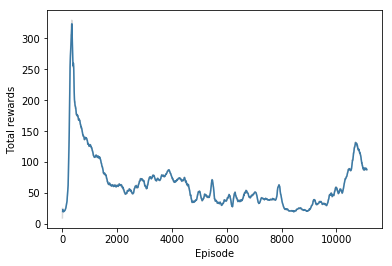

In [34]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

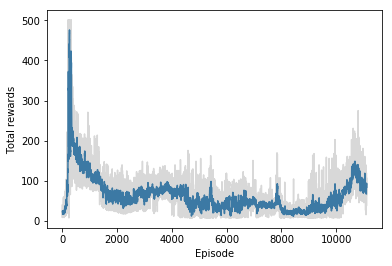

In [35]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

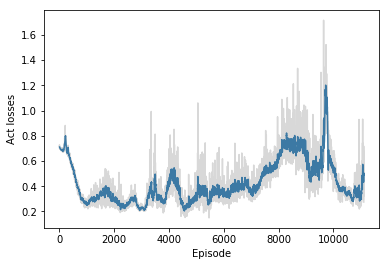

In [36]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

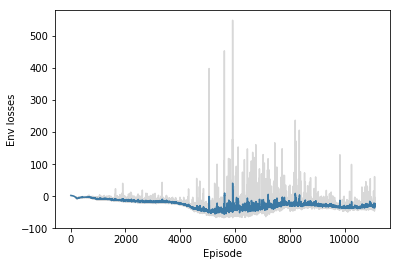

In [37]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

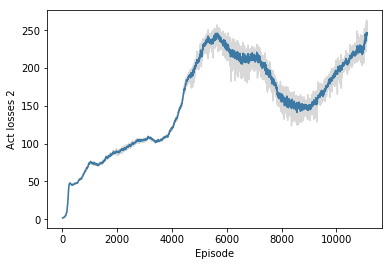

In [38]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
